In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Cell 2: force single‐threaded BLAS
os.environ["OMP_NUM_THREADS"]       = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"


In [2]:
# Cell 3: actually cap BLAS to 1 thread
from threadpoolctl import threadpool_limits

# 'blas' covers OpenBLAS, MKL, etc.
threadpool_limits(limits=1, user_api='blas')

# now import as usual, no more warning
import numpy as np
import scipy
# … any other packages that use OpenBLAS …


In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import scanpy as sc
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix, issparse
from sklearn.preprocessing import normalize
import ot 
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [4]:
def construct_graph_torch(X, k, mode='connectivity', metric = 'minkowski', p=2, device='cuda'):
    '''construct knn graph with torch and gpu
    args:
        X: input data containing features (torch tensor)
        k: number of neighbors for each data point
        mode: 'connectivity' or 'distance'
        metric: distance metric (now euclidean supported for gpu knn)
        p: param for minkowski (not used if metric is euclidean)
    
    Returns:
        knn graph as a pytorch sparse tensor (coo format) or dense tensor depending on mode     
    '''

    assert mode in ['connectivity', 'distance'], "mode must be 'connectivity' or 'distance'."
    assert metric == 'euclidean', "for gpu knn, only 'euclidean' metric is currently supported in this implementation"

    if mode == 'connectivity':
        include_self = True
        mode_knn = 'connectivity'
    else:
        include_self = False
        mode_knn = 'distance'

    n_samples = X.shape[0]
    knn = NearestNeighbors(n_neighbors=k, metric=metric, algorithm='auto')

    if device == 'cuda' and torch.cuda.is_available():
        X_cpu = X.cpu().numpy()
    else:
        X_cpu = X.numpy()

    knn.fit(X_cpu)
    knn_graph_cpu = kneighbors_graph(knn, k, mode=mode_knn, include_self=include_self, metric=metric) #scipy sparse matrix on cpu
    knn_graph_coo = knn_graph_cpu.tocoo()

    if mode == 'connectivity':
        knn_graph = torch.sparse_coo_tensor(torch.LongTensor([knn_graph_coo.row, knn_graph_coo.col]),
                                            torch.FloatTensor(knn_graph_coo.data),
                                            size = knn_graph_coo.shape).to(device)
    elif mode == 'distance':
        knn_graph_dense = torch.tensor(knn_graph_cpu.toarray(), dtype=torch.float32, device=device) #move to gpu as dense tensor
        knn_graph = knn_graph_dense
    
    return knn_graph
    
def distances_cal_torch(graph, type_aware=None, aware_power =2, device='cuda'):
    '''
    calculate distance matrix from graph using dijkstra's algo
    args:
        graph: knn graph (pytorch sparse or dense tensor)
        type_aware: not implemented in this torch version for simplicity
        aware_power: same ^^
        device (str): 'cpu' or 'cuda' device to use
    Returns:
        distance matrix as a torch tensor
    '''

    if isinstance(graph, torch.Tensor) and graph.is_sparse:
        graph_cpu_csr = csr_matrix(graph.cpu().to_dense().numpy())
    elif isinstance(graph, torch.Tensor) and not graph.is_sparse:
        graph_cpu_csr = csr_matrix(graph.cpu().numpy())
    else:
        graph_cpu_csr = csr_matrix(graph) #assume scipy sparse matrix if not torch tensor

    shortestPath_cpu = dijkstra(csgraph = graph_cpu_csr, directed=False, return_predecessors=False) #dijkstra on cpu
    shortestPath = torch.tensor(shortestPath_cpu, dtype=torch.float32, device=device)

    # the_max = torch.nanmax(shortestPath[shortestPath != float('inf')])
    # shortestPath[shortestPath > the_max] = the_max

    #mask out infinite distances
    mask = shortestPath != float('inf')
    if mask.any():
        the_max = torch.max(shortestPath[mask])
        shortestPath[~mask] = the_max #replace inf with max value
    else:
        the_max = 1.0 #fallback if all are inf (should not happen in connected graphs)

    original_max_distance = the_max.item()
    C_dis = shortestPath / the_max
    # C_dis = shortestPath
    # C_dis -= torch.mean(C_dis)
    return C_dis, original_max_distance

def calculate_D_sc_torch(X_sc, k_neighbors=10, graph_mode='connectivity', device='cpu'):
    '''calculate distance matrix from graph using dijkstra's algo
    args:
        graph: knn graph (torch sparse or dense tensor)
        type_aware: not implemented
        aware_power: same ^^
        
    returns:
        distanced matrix as torch tensor'''
    
    if not isinstance(X_sc, torch.Tensor):
        raise TypeError('Input X_sc must be a pytorch tensor')
    
    if device == 'cuda' and torch.cuda.is_available():
        X_sc = X_sc.cuda(device=device)
    else:
        X_sc = X_sc.cpu()
        device= 'cpu'

    print(f'using device: {device}')
    print(f'constructing knn graph...')
    # X_normalized = normalize(X_sc.cpu().numpy(), norm='l2') #normalize on cpu for sklearn knn
    X_normalized = X_sc
    X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)

    Xgraph = construct_graph_torch(X_normalized_torch, k=k_neighbors, mode=graph_mode, metric='euclidean', device=device)

    print('calculating distances from graph....')
    D_sc, sc_max_distance = distances_cal_torch(Xgraph, device=device)

    print('D_sc calculation complete')
    
    return D_sc, sc_max_distance


In [5]:
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix, issparse
from sklearn.preprocessing import normalize
import ot

def construct_graph_spatial(location_array, k, mode='distance', metric='euclidean', p=2):
    '''construct KNN graph based on spatial coordinates
    args:
        location_array: spatial coordinates of spots (n-spots * 2)
        k: number of neighbors for each spot
        mode: 'connectivity' or 'distance'
        metric: distance metric for knn (p=2 is euclidean)
        p: param for minkowski if connectivity
        
    returns:
        scipy.sparse.csr_matrix: knn graph in csr format
    '''

    assert mode in ['connectivity', 'distance'], "mode must be 'connectivity' or 'distance'"
    if mode == 'connectivity':
        include_self = True
    else:
        include_self = False
    
    c_graph = kneighbors_graph(location_array, k, mode=mode, metric=metric, include_self=include_self, p=p)
    return c_graph

def distances_cal_spatial(graph, spot_ids=None, spot_types=None, aware_power=2):
    '''calculate spatial distance matrix from knn graph
    args:
        graph (scipy.sparse.csr_matrix): knn graph
        spot_ids (list, optional): list of spot ids corresponding to the rows/cols of the graph. required if type_aware is used
        spot_types (pd.Series, optinal): pandas series of spot types for type aware distance adjustment. required if type_aware is used
        aware_power (int): power for type-aware distance adjustment
        
    returns:
        sptial distance matrix'''
    shortestPath = dijkstra(csgraph = csr_matrix(graph), directed=False, return_predecessors=False)
    shortestPath = np.nan_to_num(shortestPath, nan=np.inf) #handle potential inf valyes after dijkstra

    if spot_types is not None and spot_ids is not None:
        shortestPath_df = pd.DataFrame(shortestPath, index=spot_ids, columns=spot_ids)
        shortestPath_df['id1'] = shortestPath_df.index
        shortestPath_melted = shortestPath_df.melt(id_vars=['id1'], var_name='id2', value_name='value')

        type_aware_df = pd.DataFrame({'spot': spot_ids, 'spot_type': spot_types}, index=spot_ids)
        meta1 = type_aware_df.copy()
        meta1.columns = ['id1', 'type1']
        meta2 = type_aware_df.copy()
        meta2.columns = ['id2', 'type2']

        shortestPath_melted = pd.merge(shortestPath_melted, meta1, on='id1', how='left')
        shortestPath_melted = pd.merge(shortestPath_melted, meta2, on='id2', how='left')

        shortestPath_melted['same_type'] = shortestPath_melted['type1'] == shortestPath_melted['type2']
        shortestPath_melted.loc[(~shortestPath_melted.smae_type), 'value'] = shortestPath_melted.loc[(~shortestPath_melted.same_type),
                                                                                                     'value'] * aware_power
        shortestPath_melted.drop(['type1', 'type2', 'same_type'], axis=1, inplace=True)
        shortestPath_pivot = shortestPath_melted.pivot(index='id1', columns='id2', values='value')

        order = spot_ids
        shortestPath = shortestPath_pivot[order].loc[order].values
    else:
        shortestPath = np.asarray(shortestPath) #ensure it's a numpy array

    #mask out infinite distances
    mask = shortestPath != float('inf')
    if mask.any():
        the_max = np.max(shortestPath[mask])
        shortestPath[~mask] = the_max #replace inf with max value
    else:
        the_max = 1.0 #fallback if all are inf (should not happen in connected graphs)

    #store original max distance for scale reference
    original_max_distance = the_max
    C_dis = shortestPath / the_max
    # C_dis = shortestPath
    # C_dis -= np.mean(C_dis)

    return C_dis, original_max_distance

def calculate_D_st_from_coords(spatial_coords, X_st=None, k_neighbors=10, graph_mode='distance', aware_st=False, 
                               spot_types=None, aware_power_st=2, spot_ids=None):
    '''calculates the spatial distance matrix D_st for spatial transcriptomics data directly from coordinates and optional spot types
    args:
        spatial_coords: spatial coordinates of spots (n_spots * 2)
        X_st: St gene expression data (not used for D_st calculation itself)
        k_neighbors: number of neighbors for knn graph
        graph_mode: 'connectivity or 'distance' for knn graph
        aware_st: whether to use type-aware distance adjustment
        spot_types: pandas series of spot types for type-aware adjustment
        aware_power_st: power for type-aware distance adjustment
        spot_ids: list or index of spot ids, required if spot_ids is provided
        
    returns:
        np.ndarray: spatial disance matrix D_st'''
    
    if isinstance(spatial_coords, pd.DataFrame):
        location_array = spatial_coords.values
        if spot_ids is None:
            spot_ids = spatial_coords.index.tolist() #use index of dataframe if available
    elif isinstance(spatial_coords, np.ndarray):
        location_array = spatial_coords
        if spot_ids is None:
            spot_ids = list(range(location_array.shape[0])) #generate default ids if not provided

    else:
        raise TypeError('spatial_coords must be a pandas dataframe or a numpy array')
    
    print(f'constructing {graph_mode} graph for ST data with k={k_neighbors}.....')
    Xgraph_st = construct_graph_spatial(location_array, k=k_neighbors, mode=graph_mode)
    
    if aware_st:
        if spot_types is None or spot_ids is None:
            raise ValueError('spot_types and spot_ids must be provided when aware_st=True')
        if not isinstance(spot_types, pd.Series):
            spot_types = pd.Series(spot_types, idnex=spot_ids) 
        print('applying type aware distance adjustment for ST data')
        print(f'aware power for ST: {aware_power_st}')
    else:
        spot_types = None 

    print(f'calculating spatial distances.....')
    D_st, st_max_distance = distances_cal_spatial(Xgraph_st, spot_ids=spot_ids, spot_types=spot_types, aware_power=aware_power_st)

    print('D_st calculation complete')
    return D_st, st_max_distance


def calculate_D_st_euclidean(spatial_coords):
    """
    Calculate Euclidean distance matrix for ST spots.
    
    Args:
        spatial_coords: (m_spots, 2) spatial coordinates
        
    Returns:
        D_st_euclid: (m_spots, m_spots) normalized Euclidean distance matrix
    """
    from scipy.spatial.distance import pdist, squareform
    
    if isinstance(spatial_coords, pd.DataFrame):
        coords_array = spatial_coords.values
    elif isinstance(spatial_coords, np.ndarray):
        coords_array = spatial_coords
    else:
        coords_array = np.array(spatial_coords)
    
    # Compute pairwise Euclidean distances
    D_euclid = squareform(pdist(coords_array, metric='euclidean'))
    
    # Normalize to [0,1]
    max_dist = D_euclid.max()
    if max_dist > 0:
        D_euclid = D_euclid / max_dist
    
    return D_euclid.astype(np.float32)

In [6]:
import numpy as np
import torch
import ot
from tqdm import tqdm
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def compute_feature_cost_matrix(X_sc, X_st, metric='euclidean'):
    """
    Compute feature dissimilarity matrix M between SC cells and ST spots.
    
    Args:
        X_sc: SC gene expression (n_cells, n_genes)
        X_st: ST gene expression (m_spots, n_genes) 
        metric: Distance metric ('euclidean', 'cosine', 'correlation')
    
    Returns:
        M: Feature cost matrix (n_cells, m_spots)
    """
    if metric == 'euclidean':
        M = euclidean_distances(X_sc, X_st)
    elif metric == 'cosine':
        # Convert cosine similarity to distance
        cos_sim = cosine_similarity(X_sc, X_st)
        M = 1.0 - cos_sim
    elif metric == 'correlation':
        # Pearson correlation distance
        M = np.zeros((X_sc.shape[0], X_st.shape[0]))
        for i in range(X_sc.shape[0]):
            for j in range(X_st.shape[0]):
                corr = np.corrcoef(X_sc[i], X_st[j])[0,1]
                M[i,j] = 1.0 - corr if not np.isnan(corr) else 1.0
    
    return M.astype(np.float32)

def compute_marginal_weights(M, method='exponential'):
    """
    Compute marginal weights for unbalanced OT from feature cost matrix.
    
    Args:
        M: Feature cost matrix (n_cells, m_spots)
        method: How to compute weights ('uniform', 'exponential', 'softmax')
    
    Returns:
        w_a: Cell weights (n_cells,)
        w_b: Spot weights (m_spots,)
    """
    if method == 'uniform':
        w_a = np.ones(M.shape[0]) / M.shape[0]
        w_b = np.ones(M.shape[1]) / M.shape[1]
    elif method == 'exponential':
        # Use exp(-M) as similarity, then normalize
        weight_matrix = np.exp(-M)
        w_a = np.sum(weight_matrix, axis=1)
        w_b = np.sum(weight_matrix, axis=0)
        w_a = w_a / np.sum(w_a)
        w_b = w_b / np.sum(w_b)
    elif method == 'softmax':
        # Softmax over each row/column
        w_a = np.sum(np.exp(-M), axis=1)
        w_b = np.sum(np.exp(-M), axis=0)
        w_a = w_a / np.sum(w_a)
        w_b = w_b / np.sum(w_b)
    
    return w_a.astype(np.float32), w_b.astype(np.float32)

def unbalanced_optimal_transport(w_a, w_b, cost_matrix, epsilon=0.1, rho=100.0, max_iter=1000, tol=1e-7):
    """
    Solve unbalanced optimal transport using Sinkhorn-like iterations.
    
    Args:
        w_a: Source marginals (n,)
        w_b: Target marginals (m,)
        cost_matrix: Transport cost (n, m)
        epsilon: Entropic regularization
        rho: KL penalty weight for unbalanced transport
        max_iter: Maximum iterations
        tol: Convergence tolerance
    
    Returns:
        gamma: Transport plan (n, m)
    """
    lmbda = rho / (rho + epsilon) if not np.isinf(rho) else 1.0
    
    w_a = w_a.reshape(-1, 1)
    w_b = w_b.reshape(-1, 1)
    
    n, m = cost_matrix.shape
    u = np.zeros((n, 1))
    v = np.zeros((m, 1))
    
    for i in range(max_iter):
        u_old = u.copy()
        
        # Update u
        K = np.exp((-cost_matrix + u @ np.ones((1, m)) + np.ones((n, 1)) @ v.T) / epsilon)
        u = lmbda * epsilon * np.log(w_a) - lmbda * epsilon * np.log(np.sum(K, axis=1, keepdims=True)) + lmbda * u
        
        # Update v  
        K = np.exp((-cost_matrix + u @ np.ones((1, m)) + np.ones((n, 1)) @ v.T) / epsilon)
        v = lmbda * epsilon * np.log(w_b) - lmbda * epsilon * np.log(np.sum(K, axis=0, keepdims=True).T) + lmbda * v
        
        # Check convergence
        if np.linalg.norm(u - u_old) < tol:
            break
    
    # Final transport plan
    gamma = np.exp((-cost_matrix + u @ np.ones((1, m)) + np.ones((n, 1)) @ v.T) / epsilon)
    
    return gamma

def structured_optimal_transport(w_a, w_b, M, D_sc, D_st, alpha=0.1, epsilon=0.1, rho=100.0, max_iter=50):
    """
    Solve structured optimal transport that aligns both features and internal geometries.
    This is the core of SpaOTsc Stage 1.
    
    Args:
        w_a: Cell marginals (n_cells,)
        w_b: Spot marginals (m_spots,) 
        M: Feature cost matrix (n_cells, m_spots)
        D_sc: SC distance matrix (n_cells, n_cells)
        D_st: ST distance matrix (m_spots, m_spots)  
        alpha: Weight for structured term (0=pure feature, 1=pure structure)
        epsilon: Entropic regularization
        rho: Unbalanced transport penalty
        max_iter: Maximum iterations
    
    Returns:
        gamma: Transport plan (n_cells, m_spots)
    """
    # Normalize distance matrices
    # D_sc_norm = D_sc / np.max(D_sc) if np.max(D_sc) > 0 else D_sc
    # D_st_norm = D_st / np.max(D_st) if np.max(D_st) > 0 else D_st
    D_sc_norm = D_sc
    D_st_norm = D_st
    
    # Initialize with uniform coupling
    w_a = w_a.reshape(-1, 1) 
    w_b = w_b.reshape(-1, 1)
    gamma = w_a @ w_b.T
    
    n, m = M.shape
    
    for iteration in range(max_iter):
        gamma_old = gamma.copy()
        
        # === STRUCTURED COST COMPUTATION ===
        # This is the key innovation: align internal geometries
        
        # Feature cost component (1-α) * M  
        cost_feature = (1.0 - alpha) * M
        
        # Structured cost component α * GW_cost
        if alpha > 0:
            # Gromov-Wasserstein structured term
            # For squared loss: L(a,b) = 0.5 * (a-b)^2
            
            # Precompute constant terms
            constC1 = 0.5 * (D_sc_norm**2) @ w_a @ np.ones((1, m))
            constC2 = np.ones((n, 1)) @ w_b.T @ (0.5 * (D_st_norm**2)).T
            constC = constC1 + constC2
            
            # Variable term: -D_sc @ gamma @ D_st  
            variable_term = D_sc_norm @ gamma @ D_st_norm.T
            
            # Full structured cost
            cost_structured = alpha * 2.0 * (constC - variable_term)
        else:
            cost_structured = 0
        
        # Total cost matrix
        total_cost = cost_feature + cost_structured
        
        # === OPTIMAL TRANSPORT STEP ===
        # Solve unbalanced OT with combined cost
        if np.isinf(rho):
            # Balanced case: use standard Sinkhorn
            gamma_new = ot.sinkhorn(w_a.flatten(), w_b.flatten(), total_cost, epsilon)
        else:
            # Unbalanced case
            gamma_new = unbalanced_optimal_transport(w_a.flatten(), w_b.flatten(), total_cost, epsilon, rho)
        
        # === LINE SEARCH UPDATE ===
        # Optimal step size for convergence
        if alpha > 0:
            CxC_diff = D_sc_norm @ (gamma_new - gamma) @ D_st_norm.T
            a = -alpha * np.sum(CxC_diff * (gamma_new - gamma))
            b = np.sum((cost_feature + alpha * constC - 2.0 * alpha * (D_sc_norm @ gamma @ D_st_norm.T)) * (gamma_new - gamma))
            
            if a > 0:
                tau = min(1.0, max(0.0, -0.5 * b / a))
            elif a + b < 0:
                tau = 1.0
            else:
                tau = 0.0
        else:
            tau = 1.0
        
        # Update with line search
        gamma = (1.0 - tau) * gamma + tau * gamma_new
        
        # Check convergence
        if np.linalg.norm(gamma - gamma_old) < 1e-6:
            print(f"Structured OT converged at iteration {iteration}")
            break
    
    return gamma

import faiss
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import shortest_path
import ot
from tqdm import tqdm
from scipy.spatial.distance import pdist

def transport_aware_geodesic_distance(gamma, Y_st_coords, sigma=3.0, k_neighbors=30):
    '''
    compute sc-sc distances using transport-weighted approach
    '''
    print(f'computing transport-aware geodasic distances (sigma={sigma}, k={k_neighbors})')

    n_cells, m_spots = gamma.shape

    #1. compute euclidean distance matrix for ST spots
    print("Computing Euclidean D_st for transport weighting...")
    D_st_euclid = calculate_D_st_euclidean(Y_st_coords)

    # 2) Compute spatial affinity kernel using Euclidean distances
    print("Computing spatial affinity kernel...")
    K = np.exp(-(D_st_euclid**2) / (2 * sigma**2))  # (m_spots, m_spots)

    # 3) Compute transport-weighted similarity matrix W
    print("Computing transport-weighted similarity matrix...")
    W = gamma.dot(K).dot(gamma.T)  # (n_cells, n_cells)

    # Make symmetric for numerical stability
    W = (W + W.T) / 2
    
    print(f"Similarity matrix W: shape={W.shape}, range=[{W.min():.6f}, {W.max():.6f}]")
    
    # 4) Build sparse k-NN graph from similarity matrix W
    print(f"Building k-NN graph with k={k_neighbors}...")

    # For each cell, find k_neighbors with highest similarity
    neighbors = np.argpartition(-W, k_neighbors, axis=1)[:, :k_neighbors]  # (n_cells, k)
    
    # Create sparse graph edges
    rows = np.repeat(np.arange(n_cells), k_neighbors)
    cols = neighbors.flatten()
    similarities = W[rows, cols]
    
    # Convert similarities to costs using log distance (more stable than 1/similarity)
    epsilon = 1e-10
    costs = -np.log(similarities + epsilon)
    
    # Make graph symmetric (undirected)
    rows_sym = np.concatenate([rows, cols])
    cols_sym = np.concatenate([cols, rows]) 
    costs_sym = np.concatenate([costs, costs])
    
    # Create sparse CSR matrix
    graph_csr = coo_matrix((costs_sym, (rows_sym, cols_sym)), 
                          shape=(n_cells, n_cells)).tocsr()
    
    print(f"Sparse graph: {len(costs_sym)} edges, density={len(costs_sym)/(n_cells**2):.4f}")
    
    # 5) Compute all-pairs shortest path distances
    print("Computing shortest path distances...")
    
    D_geodesic = shortest_path(csgraph=graph_csr, directed=False, method='D')
    
    # 6) Handle infinite distances (disconnected components)
    inf_mask = ~np.isfinite(D_geodesic)
    if inf_mask.any():
        max_finite = D_geodesic[~inf_mask].max()
        D_geodesic[inf_mask] = max_finite * 2.0
        print(f"Warning: {inf_mask.sum()} infinite distances replaced with {max_finite*2.0:.4f}")
    
    # 7) Normalize to [0,1] range
    d_min, d_max = D_geodesic.min(), D_geodesic.max()
    if d_max > d_min:
        D_geodesic = (D_geodesic - d_min) / (d_max - d_min)
    
    print(f"Final geodesic distances: range=[{D_geodesic.min():.6f}, {D_geodesic.max():.6f}]")
    
    return D_geodesic.astype(np.float32)

def knn_sparse_ot_FAISS(gamma, D_st, Y_st_coords, k_neighbors=300, batch_size=1024, epsilon=0.01, device='cuda'):
    """
    Option 1: k-NN Graph + Sparse OT + Shortest-Path
    Complete implementation following ChatGPT's specifications exactly
    """    
    n_cells, m_spots = gamma.shape
    print(f"Processing {n_cells} cells, {m_spots} spots with k={k_neighbors}")
    
    # =================== STEP 1: FAISS k-NN SEARCH ===================
    print("Building FAISS-GPU index...")
    
    # Convert to float32 for FAISS
    gamma_faiss = gamma.astype(np.float32)
    
    # Build FAISS-GPU index
    res = faiss.StandardGpuResources()
    index_flat = faiss.IndexFlatL2(m_spots)  # L2 distance in gamma space
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index_flat)
    
    # Add vectors to index and search for neighbors
    gpu_index.add(gamma_faiss)
    _, indices_knn = gpu_index.search(gamma_faiss, k_neighbors + 1)  # +1 for self
    
    # =============== STEP 2: VECTORIZED NEIGHBOR EXTRACTION ===============
    # No Python loops - vectorized
    neighbors = indices_knn[:, 1:]  # Drop self-match (column 0)
    rows = np.repeat(np.arange(n_cells), k_neighbors)
    cols = neighbors.flatten()
    total_pairs = len(rows)
    
    print(f"Found {total_pairs} k-NN pairs instead of {n_cells*(n_cells-1)//2} total pairs")
    
    # ================= STEP 3: MOVE DATA TO GPU ONCE =================
    gamma_cuda = torch.from_numpy(gamma_faiss).to(device)
    spot_coords = torch.from_numpy(Y_st_coords.astype(np.float32)).to(device)  # [m, d]
    
    print(f"Spot coordinates shape: {spot_coords.shape}")
    
    # ============= STEP 4: INITIALIZE GEOMLOSS ONCE OUTSIDE LOOP =============
    try:
        from geomloss import SamplesLoss
        sinkhorn = SamplesLoss("sinkhorn", p=2, blur=epsilon)
        print("Using GeomLoss batch mode - no Python loops!")
    except ImportError:
        raise ImportError("GeomLoss required. Install with: pip install geomloss")
    
    # ========== STEP 5: BATCH PROCESSING - SINGLE GEOMLOSS CALLS ==========
    distances_list = []
    
    for batch_start in tqdm(range(0, total_pairs, batch_size), desc="Batch OT"):
        batch_end = min(batch_start + batch_size, total_pairs)
        B = batch_end - batch_start  # Actual batch size
        
        # Get batch probability distributions
        batch_rows = rows[batch_start:batch_end] 
        batch_cols = cols[batch_start:batch_end]

        P = gamma_cuda[batch_rows]  # [B, m] - source distributions
        Q = gamma_cuda[batch_cols]  # [B, m] - target distributions


        # Force consistent shapes
        P = P.reshape(B, -1)  # Force [B, m] shape
        Q = Q.reshape(B, -1)  # Force [B, m] shape

        # Ensure they have exactly the same shape
        assert P.shape == Q.shape, f"Shape mismatch: P {P.shape} vs Q {Q.shape}"

        # Normalization
        P = P / (P.sum(dim=1, keepdim=True) + 1e-8)
        Q = Q / (Q.sum(dim=1, keepdim=True) + 1e-8)

        # Clamp to avoid zeros
        P = torch.clamp(P, min=1e-8)
        Q = torch.clamp(Q, min=1e-8)

        # Re-normalize
        P = P / P.sum(dim=1, keepdim=True)
        Q = Q / Q.sum(dim=1, keepdim=True)

        # Final shape check
        # print(f"Final shapes - P: {P.shape}, Q: {Q.shape}, dims: P={P.dim()}, Q={Q.dim()}")
        
        # ONE SINGLE GEOMLOSS CALL - processes entire batch in parallel
        # GeomLoss expects: (x_i, x_j, a_i, a_j) where x are points, a are weights
        spot_coords_batch_i = spot_coords.unsqueeze(0).repeat(B, 1, 1)  # [B, m, d]
        spot_coords_batch_j = spot_coords.unsqueeze(0).repeat(B, 1, 1)  # [B, m, d]

        distances_cuda = sinkhorn(
            P,                      # [B, m]  weights for source
            spot_coords_batch_i,    # [B, m, d] points for source
            Q,                      # [B, m]  weights for target
            spot_coords_batch_j     # [B, m, d] points for target
        )
        
        # Convert to Python list and extend
        batch_distances = distances_cuda.cpu().tolist()
        distances_list.extend(batch_distances)
    
    # ============== STEP 6: BUILD SYMMETRIC SPARSE MATRIX ==============
    print("Building sparse matrix...")
    
    # Make symmetric by adding (i,j) and (j,i) entries
    all_rows = np.concatenate([rows, cols])
    all_cols = np.concatenate([cols, rows]) 
    all_distances = np.array(distances_list + distances_list)
    
    # Create sparse COO matrix
    sparse_matrix = coo_matrix((all_distances, (all_rows, all_cols)), 
                              shape=(n_cells, n_cells))
    
    # =============== STEP 7: SHORTEST PATH COMPLETION ===============
    print("Computing shortest paths to fill distance matrix...")
    
    # Convert to CSR for efficient shortest path computation
    D_spatial = shortest_path(sparse_matrix.tocsr(), directed=False, method='D')
    
    # Handle infinite distances (disconnected components)
    finite_mask = D_spatial != np.inf
    if finite_mask.any():
        max_finite_dist = np.max(D_spatial[finite_mask])
        D_spatial[~finite_mask] = max_finite_dist * 2  # Set to 2x max for disconnected pairs
    else:
        print("Warning: All distances are infinite - check k_neighbors value")
        D_spatial[D_spatial == np.inf] = 1.0  # Fallback
    
    print(f"Final distance matrix: {D_spatial.shape}, range [{D_spatial.min():.6f}, {D_spatial.max():.6f}]")
    D_min = D_spatial.min()
    D_max = D_spatial.max()

    if D_max > D_min:
        D_spatial_normalized = (D_spatial - D_min) / (D_max - D_min)
    else:
        D_spatial_normalized = D_spatial  # All same value, keep as is
    
    return D_spatial_normalized.astype(np.float32)


def spaotsc_spatial_distance_matrix(X_sc, X_st, D_sc, D_st, Y_st,
                                  alpha=0.1, epsilon_stage1=0.1, epsilon_stage2=0.01,
                                  rho=100.0, feature_metric='euclidean',
                                  marginal_method='exponential', max_iter_stage1=50, k_neighbors=50,
                                  use_landmarks=False, n_landmarks=500,
                                  verbose=True):
    """
    Main function implementing SpaOTsc's two-stage approach for spatial distance matrix.
    
    Stage 1: Structured & Unbalanced Optimal Transport
    Stage 2: Pairwise Wasserstein Distance Computation
    
    Args:
        X_sc: SC gene expression (n_cells, n_genes) 
        X_st: ST gene expression (m_spots, n_genes)
        D_sc: SC distance matrix from k-NN graph (n_cells, n_cells)
        D_st: ST spatial distance matrix (m_spots, m_spots)
        alpha: Structure vs feature weight (0=pure feature, 1=pure structure)
        epsilon_stage1: Entropic regularization for Stage 1
        epsilon_stage2: Entropic regularization for Stage 2
        rho: Unbalanced transport penalty (np.inf for balanced)
        feature_metric: Distance metric for gene expression ('euclidean', 'cosine', 'correlation')
        marginal_method: How to compute marginal weights ('uniform', 'exponential', 'softmax')
        max_iter_stage1: Maximum iterations for structured OT
        use_landmarks: Use landmark approximation in Stage 2
        n_landmarks: Number of landmarks for approximation
        verbose: Print progress information
    
    Returns:
        D_induced_spaotsc: Spatial distance matrix for SC cells (n_cells, n_cells)
        gamma_transport: Transport plan from Stage 1 (n_cells, m_spots)
    """
    
    if verbose:
        print("=== SpaOTsc Spatial Distance Matrix Computation ===")
        print(f"SC data: {X_sc.shape}, ST data: {X_st.shape}")
        print(f"Alpha (structure weight): {alpha}")
        print(f"Feature metric: {feature_metric}")
        print(f"Marginal method: {marginal_method}")
    
    # === STAGE 1: STRUCTURED & UNBALANCED OPTIMAL TRANSPORT ===
    if verbose:
        print("\n--- Stage 1: Structured Optimal Transport ---")
    
    # Step 1.1: Compute feature cost matrix M
    if verbose:
        print("Computing feature cost matrix...")
    M = compute_feature_cost_matrix(X_sc, X_st, metric=feature_metric)
    
    # Step 1.2: Compute marginal weights
    if verbose:
        print("Computing marginal weights...")
    w_a, w_b = compute_marginal_weights(M, method=marginal_method)
    
    # Step 1.3: Solve structured optimal transport
    if verbose:
        print("Solving structured optimal transport...")
    gamma_transport = structured_optimal_transport(
        w_a, w_b, M, D_sc, D_st, 
        alpha=alpha, epsilon=epsilon_stage1, rho=rho, max_iter=max_iter_stage1
    )
    
    if verbose:
        print(f"Transport plan shape: {gamma_transport.shape}")
        print(f"Transport plan mass: {np.sum(gamma_transport):.6f}")

    cell_idx = 0  # Pick any cell
    spot_weights = gamma_transport[cell_idx, :]
    top_spots = np.argsort(spot_weights)[-10:]  # Top 10 spots

    # 2. Are these spots spatially close?
    # Get their coordinates
    top_spot_coords = Y_st[top_spots]
    # Compute pairwise distances
    spatial_spread = np.std(pdist(top_spot_coords))
    print(f"Spatial spread of top spots: {spatial_spread}")

    # 3. Compare to random
    random_spots = np.random.choice(len(Y_st), 10)
    random_spread = np.std(pdist(Y_st[random_spots]))
    print(f"Random spread: {random_spread}")
        
    # === STAGE 2: PAIRWISE WASSERSTEIN DISTANCES ===
    if verbose:
        print("\n--- Stage 2: Pairwise Wasserstein Distances ---")
    
    # Step 2.1: FAST k-NN + Sparse OT using FAISS
    # D_induced_spaotsc = knn_sparse_ot_faiss(
    #     gamma_transport, D_st,
    #     k_neighbors=50,
    #     batch_size=1024,
    #     epsilon=epsilon_stage2,
    #     device='cuda'
    # )

    if isinstance(Y_st, torch.Tensor):
        Y_st_np = Y_st.cpu().numpy()
    else:
        Y_st_np = Y_st

    # Replace the slow compute_pairwise_wasserstein_distances with:
    # D_induced_spaotsc = knn_sparse_ot_FAISS(
    #     gamma_transport, D_st, Y_st_np,
    #     k_neighbors=k_neighbors,
    #     batch_size=512,  # Adjust based on GPU memory
    #     epsilon=epsilon_stage2,
    #     device='cuda'
    # )

    # Replace the knn_sparse_ot_FAISS call with:
    D_induced_spaotsc = transport_aware_geodesic_distance(
        gamma_transport, 
        Y_st_np,        # ST coordinates for Euclidean distances
        sigma=3.0,  # Repurpose epsilon_stage2 as sigma
        k_neighbors=k_neighbors
    )
    
    if verbose:
        print(f"Final spatial distance matrix shape: {D_induced_spaotsc.shape}")
        print(f"Distance range: [{np.min(D_induced_spaotsc):.6f}, {np.max(D_induced_spaotsc):.6f}]")
        print(f"Mean distance: {np.mean(D_induced_spaotsc):.6f}")
        print("=== SpaOTsc computation complete! ===")
    
    return D_induced_spaotsc, gamma_transport

# Example usage function to replace your current approach
def replace_fused_gw_with_spaotsc(X_sc, X_st, Y_st, k_neighbors=10, alpha=0.9, device='cuda'):
    """
    Drop-in replacement for your current fused_gw_torch function using SpaOTsc approach.
    
    Args:
        X_sc: SC gene expression tensor
        X_st: ST gene expression tensor  
        Y_st: ST spatial coordinates
        k_neighbors: Number of neighbors for k-NN graph
        alpha: Structure vs feature weight for SpaOTsc
        device: Device for computation
    
    Returns:
        gamma_transport: Transport plan (n_cells, m_spots)
        D_sc: SC distance matrix
        D_st: ST spatial distance matrix
        D_induced_spaotsc: SpaOTsc spatial distance matrix
        spaotsc_quality: Quality metric (transport plan mass)
    """
    
    # Convert tensors to numpy
    if isinstance(X_sc, torch.Tensor):
        X_sc_np = X_sc.cpu().numpy()
    else:
        X_sc_np = X_sc
        
    if isinstance(X_st, torch.Tensor):
        X_st_np = X_st.cpu().numpy()  
    else:
        X_st_np = X_st
        
    if isinstance(Y_st, torch.Tensor):
        Y_st_np = Y_st.cpu().numpy()
    else:
        Y_st_np = Y_st
    
    # Compute distance matrices (keeping your existing functions)
    print('Calculating SC distances with k-NN Dijkstra...')
    
    # D_sc_tensor = calculate_D_sc_torch(torch.tensor(X_sc_np), k_neighbors=k_neighbors, device=device)
    # D_sc = D_sc_tensor.cpu().numpy()

    D_sc_tensor, sc_max_distance = calculate_D_sc_torch(torch.tensor(X_sc_np), k_neighbors=k_neighbors, device=device)
    D_sc = D_sc_tensor.cpu().numpy()
    
    print('Calculating ST distances...')
    D_st, st_max_distance = calculate_D_st_from_coords(
        spatial_coords=Y_st_np, k_neighbors=50, graph_mode="distance"
    )
    
    # Apply SpaOTsc method
    print('Applying SpaOTsc spatial distance computation...')
    D_induced_spaotsc, gamma_transport = spaotsc_spatial_distance_matrix(
        X_sc_np, X_st_np, D_sc, D_st, Y_st=Y_st, k_neighbors=k_neighbors,
        alpha=alpha,  # Higher alpha = more emphasis on spatial structure
        epsilon_stage1=0.1,
        epsilon_stage2=0.1, 
        rho=50.0,
        feature_metric='euclidean',
        use_landmarks=True,  # Speed up computation
        n_landmarks=min(500, X_st_np.shape[0]),
        verbose=True
    )
    
    # Convert back to tensors if needed
    if device == 'cuda':
        D_sc = torch.tensor(D_sc, dtype=torch.float32, device=device)
        D_st = torch.tensor(D_st, dtype=torch.float32, device=device)
        D_induced_spaotsc = torch.tensor(D_induced_spaotsc, dtype=torch.float32, device=device)
        gamma_transport = torch.tensor(gamma_transport, dtype=torch.float32, device=device)
    
    # Quality metric (transport plan mass conservation)
    spaotsc_quality = np.sum(gamma_transport) if isinstance(gamma_transport, np.ndarray) else torch.sum(gamma_transport).item()
    
    print(f'SpaOTsc quality (transport mass): {spaotsc_quality:.6f}')
    
    return gamma_transport, D_sc, D_st, D_induced_spaotsc, spaotsc_quality


In [7]:
def compute_D_induced_proper_scaling(T, D_st, n_sc, n_st):
    '''compute D_induced with proper scaling'''
    #reweight transport matrix
    T_reweight = T * n_sc
    D_induced_raw = T_reweight @ D_st @ T_reweight.t()

    #normalize to [0,1] range
    D_induced_max = torch.max(D_induced_raw[D_induced_raw > 0])
    if D_induced_max > 1e-10: #avoid dvision by very small numbers
        D_induced = D_induced_raw / D_induced_max
    else:
        D_induced = D_induced_raw

    return D_induced

def fused_gw_torch(X_sc, X_st, Y_st, alpha, k=100, G0=None, max_iter = 100, tol=1e-9, device='cuda', n_iter = 1, D_st_precomputed=None):
    n = X_sc.shape[0]
    m = X_st.shape[0]

    X_sc = X_sc.to(device)
    X_st = X_st.to(device)

    if not torch.is_tensor(Y_st):
        Y_st_tensor = torch.tensor(Y_st, dtype=torch.float32, device=device)
    else:
        Y_st_tensor = Y_st.to(device, dtype=torch.float32)

    #calculate distance matrices
    print('calculating SC distances with knn-dijkstra.....')
    D_sc, sc_max_distance = calculate_D_sc_torch(X_sc, graph_mode='distance', k_neighbors=k, device=device)

    if D_st_precomputed is not None:
        print("Using precomputed block-diagonal D_st...")
        D_st = D_st_precomputed.to(device)
        st_max_distance = 1.0 #assume already normalized
    else:
        print('Calculating ST distances.....')
        D_st, st_max_distance = calculate_D_st_from_coords(spatial_coords=Y_st, k_neighbors=50, graph_mode="distance")
        D_st = torch.tensor(D_st, dtype=torch.float32, device=device)

    #get expression distance matrix
    C_exp = torch.cdist(X_sc, X_st, p=2) #euclidean distance
    C_exp = C_exp / (torch.max(C_exp) + 1e-16) #normalize

    #ensure distance matries are C-contiguouse numpy arrays for POT
    D_sc_np = D_sc.cpu().numpy()
    D_st_np = D_st.cpu().numpy()
    C_exp_np = C_exp.cpu().numpy()
    D_sc_np = np.ascontiguousarray(D_sc_np)
    D_st_np = np.ascontiguousarray(D_st_np)
    C_exp_np = np.ascontiguousarray(C_exp_np)

    #uniform distributions
    p = ot.unif(n)
    q = ot.unif(m)

    #anneal the reg param over several steps
    T_np = None
    for i in range(n_iter):
        #run fused gw with POT
        T_np, log = ot.gromov.fused_gromov_wasserstein(
            M=C_exp_np, C1=D_sc_np, C2=D_st_np,
            p=p, q=q, loss_fun='square_loss',
            alpha=alpha,
            G0=T_np if T_np is not None else (G0.cpu().numpy() if G0 is not None else None),
            log=True,
            verbose=True,
            max_iter = max_iter,
            tol_abs=tol
        )

        # T_np, log = ot.gromov.entropic_fused_gromov_wasserstein(
        #     M=C_exp_np, C1=D_sc_np, C2=D_st_np,
        #     p=p, q=q, loss_fun='square_loss',
        #     alpha=alpha,
        #     epsilon=0.001,  # START HERE - try 0.01, 0.001, 0.0001
        #     G0=T_np if T_np is not None else (G0.cpu().numpy() if G0 is not None else None),
        #     max_iter=max_iter,
        #     tol=tol,  # Note: tol instead of tol_abs
        #     solver='PGD',  # Projected Gradient Descent
        #     verbose=True,
        #     log=True
        # )

    fgw_dist = log['fgw_dist']

    print(f'fgw distance: {fgw_dist}')

    T = torch.tensor(T_np, dtype=torch.float32, device=device)

    n_sc = X_sc.shape[0]
    n_st = X_st.shape[0]

    D_induced = compute_D_induced_proper_scaling(T, D_st, n_sc, n_st)

    return T, D_sc, D_st, D_induced, fgw_dist, sc_max_distance, st_max_distance

# patient 2 data load

In [8]:
def load_and_process_cscc_data():
    """
    Load and process the cSCC dataset with multiple ST replicates.
    """
    print("Loading cSCC data...")
    
    # Load SC data
    scadata = sc.read_h5ad('/home/ehtesamul/sc_st/data/cSCC/processed/scP2.h5ad')
    
    # Load all 3 ST datasets
    stadata1 = sc.read_h5ad('/home/ehtesamul/sc_st/data/cSCC/processed/stP2.h5ad')
    stadata2 = sc.read_h5ad('/home/ehtesamul/sc_st/data/cSCC/processed/stP2rep2.h5ad')
    stadata3 = sc.read_h5ad('/home/ehtesamul/sc_st/data/cSCC/processed/stP2rep3.h5ad')
    
    # Normalize and log transform
    for adata in [scadata, stadata1, stadata2, stadata3]:
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
    
    # Create rough cell types for SC data
    scadata.obs['rough_celltype'] = scadata.obs['level1_celltype'].astype(str)
    scadata.obs.loc[scadata.obs['level1_celltype']=='CLEC9A','rough_celltype'] = 'DC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='CD1C','rough_celltype'] = 'DC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='ASDC','rough_celltype'] = 'DC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='PDC','rough_celltype'] = 'PDC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='MDSC','rough_celltype'] = 'DC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='LC','rough_celltype'] = 'DC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='Mac','rough_celltype'] = 'Myeloid cell'
    scadata.obs.loc[scadata.obs['level1_celltype']=='Tcell','rough_celltype'] = 'T cell'
    scadata.obs.loc[scadata.obs['level2_celltype']=='TSK','rough_celltype'] = 'TSK'
    scadata.obs.loc[scadata.obs['level2_celltype'].isin(['Tumor_KC_Basal', 'Tumor_KC_Diff','Tumor_KC_Cyc']),'rough_celltype'] = 'NonTSK'
    
    return scadata, stadata1, stadata2, stadata3

def prepare_combined_st_for_diffusion(stadata1, stadata2, stadata3, scadata):
    """
    Combine all ST datasets for diffusion training while maintaining gene alignment.
    Key innovation: Use ALL ST data points for better training.
    """
    print("Preparing combined ST data for diffusion training...")
    
    # Get common genes between SC and all ST datasets
    sc_genes = set(scadata.var_names)
    st1_genes = set(stadata1.var_names)
    st2_genes = set(stadata2.var_names)
    st3_genes = set(stadata3.var_names)
    
    common_genes = sorted(list(sc_genes & st1_genes & st2_genes & st3_genes))
    print(f"Common genes across all datasets: {len(common_genes)}")
    
    # Extract aligned expression data
    sc_expr = scadata[:, common_genes].X
    st1_expr = stadata1[:, common_genes].X
    st2_expr = stadata2[:, common_genes].X
    st3_expr = stadata3[:, common_genes].X
    
    # Convert to dense if sparse
    if hasattr(sc_expr, 'toarray'):
        sc_expr = sc_expr.toarray()
    if hasattr(st1_expr, 'toarray'):
        st1_expr = st1_expr.toarray()
    if hasattr(st2_expr, 'toarray'):
        st2_expr = st2_expr.toarray()
    if hasattr(st3_expr, 'toarray'):
        st3_expr = st3_expr.toarray()
    
    # Get spatial coordinates
    st1_coords = stadata1.obsm['spatial']
    st2_coords = stadata2.obsm['spatial']
    st3_coords = stadata3.obsm['spatial']

    # Store separate coordinate lists for block-diagonal graph
    st_coords_list = [st1_coords, st2_coords, st3_coords]
    
    # Combine all ST data
    st_expr_combined = np.vstack([st1_expr, st2_expr, st3_expr])

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    st_expr_combined = scaler.fit_transform(st_expr_combined)

    st_coords_combined = np.vstack([st1_coords, st2_coords, st3_coords])

    sc_expr = scaler.fit_transform(sc_expr)

    
    # Create dataset labels for tracking
    dataset_labels = (['dataset1'] * len(st1_expr) + 
                     ['dataset2'] * len(st2_expr) + 
                     ['dataset3'] * len(st3_expr))
    
    print(f"Combined ST data shape: {st_expr_combined.shape}")
    print(f"Combined ST coords shape: {st_coords_combined.shape}")
    print(f"SC data shape: {sc_expr.shape}")
    
    # Convert to tensors
    X_sc = torch.tensor(sc_expr, dtype=torch.float32)
    X_st_combined = torch.tensor(st_expr_combined, dtype=torch.float32)
    Y_st_combined = st_coords_combined.astype(np.float32)
    
    return X_sc, X_st_combined, Y_st_combined, dataset_labels, common_genes, st_coords_list

# Load and process data
scadata, stadata1, stadata2, stadata3 = load_and_process_cscc_data()

# Prepare combined data for diffusion
X_sc, X_st_combined, Y_st_combined, dataset_labels, common_genes, st_coords_list = prepare_combined_st_for_diffusion(
    stadata1, stadata2, stadata3, scadata
)

print(f"Data preparation complete!")
print(f"SC cells: {X_sc.shape[0]}")
print(f"Combined ST spots: {X_st_combined.shape[0]}")
print(f"Common genes: {len(common_genes)}")



Loading cSCC data...
Preparing combined ST data for diffusion training...
Common genes across all datasets: 2000
Combined ST data shape: (1950, 2000)
Combined ST coords shape: (1950, 2)
SC data shape: (2688, 2000)
Data preparation complete!
SC cells: 2688
Combined ST spots: 1950
Common genes: 2000


# diffusion model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from tqdm import tqdm
import os
import time
import scipy
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import cKDTree

class FeatureNet(nn.Module):
    def __init__(self, n_genes, n_embedding=[512, 256, 128], dp=0):
        super(FeatureNet, self).__init__()

        self.fc1 = nn.Linear(n_genes, n_embedding[0])
        self.bn1 = nn.LayerNorm(n_embedding[0])
        self.fc2 = nn.Linear(n_embedding[0], n_embedding[1])
        self.bn2 = nn.LayerNorm(n_embedding[1])
        self.fc3 = nn.Linear(n_embedding[1], n_embedding[2])
        
        self.dp = nn.Dropout(dp)
        
    def forward(self, x, isdp=False):
        if isdp:
            x = self.dp(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class MMDLoss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        super(MMDLoss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = fix_sigma
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul, kernel_num, fix_sigma):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        tmp = 0
        for x in kernel_val:
            tmp += x
        return tmp

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss

class SinusoidalEmbedding(nn.Module):
    """Sinusoidal embeddings for diffusion timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1, 0, 0))
        return emb

def normalize_coordinates_isotropic(coords):
    '''normalize coordinates to unit circle preserving aspect ratio'''
    if torch.is_tensor(coords):
        center = coords.mean(dim=0)
        centered = coords - center
        max_radius = torch.max(torch.norm(centered, dim=1))
        coords_norm = centered / max_radius
        return coords_norm, center, max_radius
    else:
        center = coords.mean(axis=0)
        centered = coords - center
        max_radius = np.max(np.linalg.norm(centered, axis=1))
        coords_norm = centered / max_radius
        return coords_norm, center, max_radius

class STEMDiffusion:
    def __init__(
        self, 
        st_gene_expr,
        st_coords,
        D_st,
        sc_gene_expr,
        D_induced=None,
        outf='./diffusion_output',
        device='cuda',
        n_genes=None,
        n_embedding=[512, 256, 128],
        hidden_dim=256,
        dp=0.1,
        n_timesteps=800,
        beta_start=1e-4,
        beta_end=0.02,
        sigma=3.0,
        alpha=0.8,
        mmdbatch=1000,
        batch_size=256,
        coord_space_diameter = 2.0,
        st_max_distance = None,
        sc_max_distance = None
    ):
        self.device = torch.device(device)

        self.sc_coord_predictor = nn.Sequential(
            nn.Linear(n_embedding[-1], hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.LayerNorm(hidden_dim//2),
            nn.SiLU(),
            nn.Linear(hidden_dim//2, 2)
        ).to(self.device)
        
        # Separate optimizer for SC head (will be used in Stage 2)
        self.optimizer_sc = torch.optim.AdamW(
            self.sc_coord_predictor.parameters(), 
            lr=1e-3, 
            weight_decay=1e-5
        )
        self.scheduler_sc = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer_sc, T_max=1000, eta_min=1e-6
        )
        
        # Create output directory
        self.outf = outf
        if not os.path.exists(outf):
            os.makedirs(outf)
        
        self.train_log = os.path.join(outf, 'train.log')
        
        # Store data
        self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
        self.st_coords = torch.tensor(st_coords, dtype=torch.float32).to(self.device)
        self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
        
        # Store distance matrices
        self.D_st = torch.tensor(D_st, dtype=torch.float32).to(self.device)
        if D_induced is not None:
            self.D_induced = torch.tensor(D_induced, dtype=torch.float32).to(self.device)
        else:
            self.D_induced = None
        
        # Normalize coordinates for diffusion model
        coords_min = self.st_coords.min(dim=0)[0]
        coords_max = self.st_coords.max(dim=0)[0]
        coords_range = coords_max - coords_min
        self.st_coords_norm = 2 * (self.st_coords - coords_min) / coords_range - 1
        self.coords_min, self.coords_max = coords_min, coords_max
        self.coords_range = coords_range

        self.coord_space_diameter = coord_space_diameter
        self.st_max_distance = st_max_distance
        self.sc_max_distance = sc_max_distance

        #use isotropic normalization
        self.st_coords_norm, self.coords_center, self.coords_radius = normalize_coordinates_isotropic(self.st_coords)
        

        # self.st_coords_norm = self.st_coords

        # STEM parameters
        self.n_genes = n_genes or st_gene_expr.shape[1]
        self.sigma = sigma
        self.alpha = alpha
        self.mmdbatch = mmdbatch
        self.batch_size = batch_size
        
        # Initialize feature encoder (shared between ST and SC data)
        self.netE = FeatureNet(self.n_genes, n_embedding=n_embedding, dp=dp).to(self.device)
        
        # Initialize diffusion model components
        
        # Time embedding
        self.time_embed = nn.Sequential(
            SinusoidalEmbedding(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ).to(self.device)
        
        # Coordinate encoder
        self.coord_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        ).to(self.device)
        
        # Feature to hidden projection
        self.feat_proj = nn.Sequential(
            nn.Linear(n_embedding[-1], hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        ).to(self.device)

        #coordinate head to get coords direct from gene expression
        self.coord_head = nn.Sequential(
            nn.Linear(n_embedding[-1], hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        ).to(self.device)
        
        # Main network blocks
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU()
            ).to(self.device) for _ in range(4)
        ])
        
        # Output layer
        self.final = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.SiLU(),
            nn.Linear(hidden_dim//2, 2)
        ).to(self.device)
        
        # Setup optimizers and losses
        self.optimizer_E = torch.optim.AdamW(self.netE.parameters(), lr=0.002)
        self.scheduler_E = lr_scheduler.StepLR(optimizer=self.optimizer_E, step_size=200, gamma=0.5)
        
        diffusion_params = list(self.time_embed.parameters()) + \
                           list(self.coord_encoder.parameters()) + \
                           list(self.feat_proj.parameters()) + \
                           list(self.blocks.parameters()) + \
                           list(self.final.parameters())
        
        self.optimizer_diff = torch.optim.AdamW(diffusion_params, lr=1e-4, weight_decay=1e-6)
        self.scheduler_diff = lr_scheduler.CosineAnnealingLR(self.optimizer_diff, T_max=3000, eta_min=1e-6)
        
        self.mmd_fn = MMDLoss()
        
        # Setup noise schedule for diffusion
        self.n_timesteps = n_timesteps
        self.noise_schedule = self.get_noise_schedule(n_timesteps, beta_start, beta_end)
        
        # Tracking losses
        self.loss_names = ['E', 'E_pred', 'E_circle', 'E_mmd', 'diffusion']
    
    def get_noise_schedule(self, timesteps=1000, beta1=1e-4, beta2=0.02):
        """Returns diffusion noise schedule parameters"""
        # Linear schedule
        betas = torch.linspace(beta1, beta2, timesteps, device=self.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        
        return {
            'betas': betas,
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod
        }
    
    def add_noise(self, x_0, t, noise_schedule):
        """Add noise to coordinates according to timestep t"""
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
        
        # Add noise according to schedule
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_t, noise
    
    def forward_diffusion(self, coords, t, features):
        """Forward pass of diffusion model, predicting noise from noisy coordinates and conditioning"""
        # Get feature embeddings
        feat_emb = self.netE(features, isdp=False)
        feat_proj = self.feat_proj(feat_emb)
        
        # Get time embedding
        t_emb = self.time_embed(t)
        
        # Get coordinate embedding
        coord_emb = self.coord_encoder(coords)
        
        # Combine all inputs
        h = coord_emb + t_emb + feat_proj
        
        # Process through residual blocks
        for block in self.blocks:
            h = h + block(h)  # Residual connection
        
        # Predict noise
        return self.final(h)
    
    def train_encoder(self, n_epochs=1000, ratio_start=0, ratio_end=1.0):
        """Train the STEM encoder to align ST and SC data"""
        print("Training STEM encoder...")
        
        # Log training start
        with open(self.train_log, 'a') as f:
            localtime = time.asctime(time.localtime(time.time()))
            f.write(f"{localtime} - Starting STEM encoder training\n")
            f.write(f"n_epochs={n_epochs}, ratio_start={ratio_start}, ratio_end={ratio_end}\n")
        
        # Calculate spatial adjacency matrix
        if self.sigma == 0:
            nettrue = torch.eye(self.st_coords.shape[0], device=self.device)
        else:
            nettrue = torch.tensor(scipy.spatial.distance.cdist(
                self.st_coords.cpu().numpy(), 
                self.st_coords.cpu().numpy()
            ), device=self.device).to(torch.float32)
            
            sigma = self.sigma
            nettrue = torch.exp(-nettrue**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
            nettrue = F.normalize(nettrue, p=1, dim=1)
        
        # Training loop
        for epoch in range(n_epochs):
            # Schedule for circle loss weight
            ratio = ratio_start + (ratio_end - ratio_start) * min(epoch / (n_epochs * 0.8), 1.0)
            
            # Forward pass ST data
            e_seq_st = self.netE(self.st_gene_expr, True)
            
            # Sample from SC data due to large size
            sc_idx = torch.randint(0, self.sc_gene_expr.shape[0], (min(self.batch_size, self.mmdbatch),), device=self.device)
            sc_batch = self.sc_gene_expr[sc_idx]
            e_seq_sc = self.netE(sc_batch, False)
            
            # Calculate losses
            self.optimizer_E.zero_grad()
            
            # Prediction loss (equivalent to netpred in STEM)
            netpred = e_seq_st.mm(e_seq_st.t())
            loss_E_pred = F.cross_entropy(netpred, nettrue, reduction='mean')
            
            # Mapping matrices
            st2sc = F.softmax(e_seq_st.mm(e_seq_sc.t()), dim=1)
            sc2st = F.softmax(e_seq_sc.mm(e_seq_st.t()), dim=1)
            
            # Circle loss
            st2st = torch.log(st2sc.mm(sc2st) + 1e-7)
            loss_E_circle = F.kl_div(st2st, nettrue, reduction='none').sum(1).mean()
            
            # MMD loss
            ranidx = torch.randint(0, e_seq_sc.shape[0], (min(self.mmdbatch, e_seq_sc.shape[0]),), device=self.device)
            loss_E_mmd = self.mmd_fn(e_seq_st, e_seq_sc[ranidx])
            
            # Total loss
            loss_E = loss_E_pred + self.alpha * loss_E_mmd + ratio * loss_E_circle
            
            # Backward and optimize
            loss_E.backward()
            self.optimizer_E.step()
            self.scheduler_E.step()
            
            # Log progress
            if epoch % 100 == 0:
                log_msg = (f"Encoder epoch {epoch}/{n_epochs}, "
                          f"Loss_E: {loss_E.item():.6f}, "
                          f"Loss_E_pred: {loss_E_pred.item():.6f}, "
                          f"Loss_E_circle: {loss_E_circle.item():.6f}, "
                          f"Loss_E_mmd: {loss_E_mmd.item():.6f}, "
                          f"Ratio: {ratio:.4f}")
                
                print(log_msg)
                with open(self.train_log, 'a') as f:
                    f.write(log_msg + '\n')
                
                # Save checkpoint
                if epoch % 500 == 0:
                    torch.save({
                        'epoch': epoch,
                        'netE_state_dict': self.netE.state_dict(),
                        'optimizer_state_dict': self.optimizer_E.state_dict(),
                        'scheduler_state_dict': self.scheduler_E.state_dict(),
                    }, os.path.join(self.outf, f'encoder_checkpoint_epoch_{epoch}.pt'))
        
        # Save final encoder
        torch.save({
            'netE_state_dict': self.netE.state_dict(),
        }, os.path.join(self.outf, 'final_encoder.pt'))
        
        print("Encoder training complete!")
    
    def train_diffusion(self, n_epochs=2000, lambda_struct=5.0):
        """Train diffusion model using the trained encoder"""
        print("Training diffusion model...")
        
        # Log training start
        with open(self.train_log, 'a') as f:
            localtime = time.asctime(time.localtime(time.time()))
            f.write(f"{localtime} - Starting diffusion model training\n")
            f.write(f"n_epochs={n_epochs}, lambda_struct={lambda_struct}\n")
        
        # Freeze encoder during diffusion training
        for param in self.netE.parameters():
            param.requires_grad = False
        
        # Precompute adjacency matrix for structure loss
        def compute_adjacency_matrix(distances, sigma=3.0):
            weights = torch.exp(-(distances ** 2) / (2 * sigma * sigma))
            # Zero out self-connections
            weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
            # Normalize rows to sum to 1
            row_sums = weights.sum(dim=1, keepdim=True)
            row_sums = torch.clamp(row_sums, min=1e-10)
            adjacency = weights / (row_sums + 1e-8)
            return adjacency
        
        st_adj = compute_adjacency_matrix(self.D_st, sigma=self.sigma)
        
        # Keep track of best model
        best_loss = float('inf')
        best_state = None
        
        # Training loop
        for epoch in range(n_epochs):
            # Sample batch of ST data
            idx = torch.randperm(len(self.st_coords_norm))[:self.batch_size]
            coords = self.st_coords_norm[idx]
            features = self.st_gene_expr[idx]
            sub_adj = st_adj[idx][:, idx]
            sub_adj = sub_adj / (sub_adj.sum(dim=1, keepdim=True) + 1e-8)

            
            # Sample timesteps with emphasis on early and late stages
            if np.random.random() < 0.3:
                # Focus on early timesteps (high noise)
                t = torch.randint(int(0.7 * self.n_timesteps), self.n_timesteps, (self.batch_size,), device=self.device)
            elif np.random.random() < 0.6:
                # Focus on late timesteps (low noise, more structure)
                t = torch.randint(0, int(0.3 * self.n_timesteps), (self.batch_size,), device=self.device)
            else:
                # Random timesteps across the range
                t = torch.randint(0, self.n_timesteps, (self.batch_size,), device=self.device)
            
            # Add noise to coordinates
            noisy_coords, target_noise = self.add_noise(coords, t, self.noise_schedule)
            
            # Forward pass to predict noise
            pred_noise = self.forward_diffusion(noisy_coords, t.unsqueeze(1).float() / self.n_timesteps, features)
            
            # Compute diffusion loss (noise prediction MSE)
            diffusion_loss = F.mse_loss(pred_noise, target_noise)
            
            # Compute denoised coordinates for structure loss
            sqrt_alphas_cumprod_t = self.noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
            sqrt_one_minus_alphas_cumprod_t = self.noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
            pred_coords = (noisy_coords - sqrt_one_minus_alphas_cumprod_t * pred_noise) / sqrt_alphas_cumprod_t
            
            # Compute pairwise distances and adjacency for predicted coordinates
            pred_distances = torch.cdist(pred_coords, pred_coords, p=2)
            pred_adj = compute_adjacency_matrix(pred_distances, sigma=self.sigma)

            # print(pred_adj.sum(dim=1))
            # print(sub_adj.sum(dim=1))
            
            # Structure loss (KL divergence between adjacency matrices)
            # Using KL divergence as you preferred
            struct_loss = F.kl_div(
                torch.log(pred_adj + 1e-10),
                sub_adj,
                reduction='batchmean'
            )
            # Total loss
            total_loss = diffusion_loss + lambda_struct * struct_loss
            
            # Optimize
            self.optimizer_diff.zero_grad()
            total_loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(
                list(self.time_embed.parameters()) + 
                list(self.coord_encoder.parameters()) + 
                list(self.feat_proj.parameters()) + 
                list(self.blocks.parameters()) + 
                list(self.final.parameters()) +
                list(self.coord_head.parameters()),
                1.0
            )
            self.optimizer_diff.step()
            self.scheduler_diff.step()
            
            # Save best model
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_state = {
                    'epoch': epoch,
                    'time_embed': self.time_embed.state_dict(),
                    'coord_encoder': self.coord_encoder.state_dict(),
                    'feat_proj': self.feat_proj.state_dict(),
                    'blocks': [block.state_dict() for block in self.blocks],
                    'final': self.final.state_dict(),
                    'loss': best_loss
                }
                # Save best model
                torch.save(best_state, os.path.join(self.outf, 'best_diffusion_model.pt'))
            
            # Log progress
            if epoch % 100 == 0:
                log_msg = (f"Diffusion epoch {epoch}/{n_epochs}, "
                          f"Loss: {total_loss.item():.6f}, "
                          f"Diffusion Loss: {diffusion_loss.item():.6f}, "
                          f"Structure Loss: {struct_loss.item():.6f}, "
                          f"LR: {self.scheduler_diff.get_last_lr()[0]:.6f}")
                
                print(log_msg)
                with open(self.train_log, 'a') as f:
                    f.write(log_msg + '\n')
                
                # Save checkpoint
                if epoch % 500 == 0:
                    torch.save({
                        'epoch': epoch,
                        'time_embed': self.time_embed.state_dict(),
                        'coord_encoder': self.coord_encoder.state_dict(),
                        'feat_proj': self.feat_proj.state_dict(),
                        'blocks': [block.state_dict() for block in self.blocks],
                        'final': self.final.state_dict(),
                        'optimizer_state_dict': self.optimizer_diff.state_dict(),
                        'scheduler_state_dict': self.scheduler_diff.state_dict(),
                        'loss': total_loss.item()
                    }, os.path.join(self.outf, f'diffusion_checkpoint_epoch_{epoch}.pt'))
        
        # Restore best model
        if best_state:
            self.time_embed.load_state_dict(best_state['time_embed'])
            self.coord_encoder.load_state_dict(best_state['coord_encoder'])
            self.feat_proj.load_state_dict(best_state['feat_proj'])
            for i, block_state in enumerate(best_state['blocks']):
                self.blocks[i].load_state_dict(block_state)
            self.final.load_state_dict(best_state['final'])
            print(f"Restored best model from epoch {best_state['epoch']} with loss {best_state['loss']:.6f}")
        
        print("Diffusion training complete!")
    
    def train_diffusion_stage1_st_only(self, n_epochs=2000, lambda_struct=5.0):
        """
        STAGE 1: Train diffusion model ONLY on ST data for clean spatial learning.
        This is your original working approach - keep it clean and focused.
        """
        print("STAGE 1: Training diffusion model on ST data only...")
        
        # Freeze encoder during diffusion training
        for param in self.netE.parameters():
            param.requires_grad = False
        
        # Precompute adjacency matrix for structure loss
        def compute_adjacency_matrix(distances, sigma=3.0):
            weights = torch.exp(-(distances ** 2) / (2 * sigma * sigma))
            weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
            row_sums = weights.sum(dim=1, keepdim=True)
            row_sums = torch.clamp(row_sums, min=1e-10)
            adjacency = weights / (row_sums + 1e-8)
            return adjacency
        
        st_adj = compute_adjacency_matrix(self.D_st, sigma=self.sigma)
        
        # Keep track of best model
        best_loss = float('inf')
        best_state = None
        
        # Training loop - ONLY ST data
        for epoch in range(n_epochs):
            # Sample batch of ST data
            idx = torch.randperm(len(self.st_coords_norm))[:self.batch_size]
            coords = self.st_coords_norm[idx]
            features = self.st_gene_expr[idx]
            sub_adj = st_adj[idx][:, idx]
            sub_adj = sub_adj / (sub_adj.sum(dim=1, keepdim=True) + 1e-8)
            
            # Sample timesteps with emphasis on early and late stages
            if np.random.random() < 0.3:
                t = torch.randint(int(0.7 * self.n_timesteps), self.n_timesteps, (self.batch_size,), device=self.device)
            elif np.random.random() < 0.6:
                t = torch.randint(0, int(0.3 * self.n_timesteps), (self.batch_size,), device=self.device)
            else:
                t = torch.randint(0, self.n_timesteps, (self.batch_size,), device=self.device)
            
            # Add noise to coordinates
            noisy_coords, target_noise = self.add_noise(coords, t, self.noise_schedule)
            
            # Forward pass to predict noise
            pred_noise = self.forward_diffusion(noisy_coords, t.unsqueeze(1).float() / self.n_timesteps, features)
            
            # Compute diffusion loss (noise prediction MSE)
            diffusion_loss = F.mse_loss(pred_noise, target_noise)
            
            # Compute denoised coordinates for structure loss
            sqrt_alphas_cumprod_t = self.noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
            sqrt_one_minus_alphas_cumprod_t = self.noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
            pred_coords = (noisy_coords - sqrt_one_minus_alphas_cumprod_t * pred_noise) / sqrt_alphas_cumprod_t
            
            # Compute pairwise distances and adjacency for predicted coordinates
            pred_distances = torch.cdist(pred_coords, pred_coords, p=2)
            pred_adj = compute_adjacency_matrix(pred_distances, sigma=self.sigma)
            
            # Structure loss (KL divergence between adjacency matrices)
            struct_loss = F.kl_div(
                torch.log(pred_adj + 1e-10),
                sub_adj,
                reduction='batchmean'
            )
            
            # Total loss
            total_loss = diffusion_loss + lambda_struct * struct_loss
            
            # Optimize
            self.optimizer_diff.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(
                list(self.time_embed.parameters()) +
                list(self.coord_encoder.parameters()) +
                list(self.feat_proj.parameters()) +
                list(self.blocks.parameters()) +
                list(self.final.parameters()),
                1.0
            )
            self.optimizer_diff.step()
            self.scheduler_diff.step()
            
            # Save best model
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_state = {
                    'epoch': epoch,
                    'time_embed': self.time_embed.state_dict(),
                    'coord_encoder': self.coord_encoder.state_dict(),
                    'feat_proj': self.feat_proj.state_dict(),
                    'blocks': [block.state_dict() for block in self.blocks],
                    'final': self.final.state_dict(),
                    'loss': best_loss
                }
            
            # Log progress
            if epoch % 100 == 0:
                log_msg = (f"STAGE 1 - Epoch {epoch}/{n_epochs}, "
                        f"Loss: {total_loss.item():.6f}, "
                        f"Diffusion: {diffusion_loss.item():.6f}, "
                        f"Structure: {struct_loss.item():.6f}")
                print(log_msg)
                
                if epoch % 500 == 0:
                    torch.save({
                        'epoch': epoch,
                        'time_embed': self.time_embed.state_dict(),
                        'coord_encoder': self.coord_encoder.state_dict(),
                        'feat_proj': self.feat_proj.state_dict(),
                        'blocks': [block.state_dict() for block in self.blocks],
                        'final': self.final.state_dict(),
                        'optimizer_state_dict': self.optimizer_diff.state_dict(),
                        'scheduler_state_dict': self.scheduler_diff.state_dict(),
                    }, os.path.join(self.outf, f'stage1_checkpoint_epoch_{epoch}.pt'))
        
        # Restore best model
        if best_state:
            self.time_embed.load_state_dict(best_state['time_embed'])
            self.coord_encoder.load_state_dict(best_state['coord_encoder'])
            self.feat_proj.load_state_dict(best_state['feat_proj'])
            for i, block_state in enumerate(best_state['blocks']):
                self.blocks[i].load_state_dict(block_state)
            self.final.load_state_dict(best_state['final'])
            print(f"Restored best ST model from epoch {best_state['epoch']} with loss {best_state['loss']:.6f}")
        
        # Save final Stage 1 model
        torch.save({
            'netE_state_dict': self.netE.state_dict(),
            'time_embed': self.time_embed.state_dict(),
            'coord_encoder': self.coord_encoder.state_dict(),
            'feat_proj': self.feat_proj.state_dict(),
            'blocks': [block.state_dict() for block in self.blocks],
            'final': self.final.state_dict(),
        }, os.path.join(self.outf, 'stage1_final_model.pt'))
        
        print("STAGE 1 complete! ST-based spatial diffusion model trained.")


    def train_stage2_sc_transfer(self, n_epochs=1000, lambda_struct=2.0, lambda_consist=0.5):
        """
        STAGE 2: Train SC coordinate predictor using frozen ST diffusion model.
        """
        print("STAGE 2: Training SC coordinate predictor...")
        
        # FREEZE everything except SC predictor
        for param in self.netE.parameters():
            param.requires_grad = False
        for param in self.time_embed.parameters():
            param.requires_grad = False
        for param in self.coord_encoder.parameters():
            param.requires_grad = False
        for param in self.feat_proj.parameters():
            param.requires_grad = False
        for param in self.blocks.parameters():
            param.requires_grad = False
        for param in self.final.parameters():
            param.requires_grad = False
        
        # Only SC predictor is trainable
        for param in self.sc_coord_predictor.parameters():
            param.requires_grad = True
        
        # Manually collect all parameters from individual modules
        all_params = (list(self.netE.parameters()) + 
                    list(self.time_embed.parameters()) + 
                    list(self.coord_encoder.parameters()) + 
                    list(self.feat_proj.parameters()) + 
                    list(self.blocks.parameters()) + 
                    list(self.final.parameters()) + 
                    list(self.sc_coord_predictor.parameters()))

        print("Frozen parameters:", sum(p.numel() for p in all_params if not p.requires_grad))
        print("Trainable parameters:", sum(p.numel() for p in all_params if p.requires_grad))
        
        # Precompute SC adjacency from D_induced
        def compute_adjacency_matrix(distances, sigma=3.0):
            weights = torch.exp(-(distances ** 2) / (2 * sigma * sigma))
            weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
            row_sums = weights.sum(dim=1, keepdim=True)
            row_sums = torch.clamp(row_sums, min=1e-10)
            return weights / (row_sums + 1e-8)
        
        # Scale D_induced to coordinate space
        D_induced_scaled = self.D_induced * self.coord_space_diameter
        sc_adj_target = compute_adjacency_matrix(D_induced_scaled, sigma=self.sigma)
        
        best_loss = float('inf')
        
        for epoch in range(n_epochs):
            # Sample SC batch
            sc_idx = torch.randperm(len(self.sc_gene_expr))[:self.batch_size]
            sc_features = self.sc_gene_expr[sc_idx]
            sc_sub_adj = sc_adj_target[sc_idx][:, sc_idx]
            sc_sub_adj = sc_sub_adj / (sc_sub_adj.sum(dim=1, keepdim=True) + 1e-8)
            
            # Get SC feature embeddings (frozen encoder)
            with torch.no_grad():
                sc_embeddings = self.netE(sc_features, isdp=False)
            
            # Predict SC coordinates using new head
            sc_coords_pred = self.sc_coord_predictor(sc_embeddings)
            
            # Compute structure loss based on D_induced
            pred_distances = torch.cdist(sc_coords_pred, sc_coords_pred, p=2)
            pred_adj = compute_adjacency_matrix(pred_distances, sigma=self.sigma)
            
            structure_loss = F.kl_div(
                torch.log(pred_adj + 1e-10),
                sc_sub_adj,
                reduction='batchmean'
            )
            
            # Consistency loss: SC coordinates should have similar statistics to ST
            with torch.no_grad():
                # Sample some ST coordinates for comparison
                st_sample_idx = torch.randperm(len(self.st_coords_norm))[:self.batch_size]
                st_coords_sample = self.st_coords_norm[st_sample_idx]
            
            # Compare coordinate distributions
            sc_mean = sc_coords_pred.mean(dim=0)
            sc_std = sc_coords_pred.std(dim=0)
            st_mean = st_coords_sample.mean(dim=0)
            st_std = st_coords_sample.std(dim=0)
            
            consistency_loss = F.mse_loss(sc_mean, st_mean) + F.mse_loss(sc_std, st_std)
            
            # Total loss
            total_loss = lambda_struct * structure_loss + lambda_consist * consistency_loss
            
            # Optimize
            self.optimizer_sc.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.sc_coord_predictor.parameters(), 1.0)
            self.optimizer_sc.step()
            self.scheduler_sc.step()
            
            # Save best model
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                torch.save({
                    'sc_coord_predictor': self.sc_coord_predictor.state_dict(),
                    'epoch': epoch,
                    'loss': best_loss
                }, os.path.join(self.outf, 'best_sc_predictor.pt'))
            
            # Log progress
            if epoch % 100 == 0:
                log_msg = (f"STAGE 2 - Epoch {epoch}/{n_epochs}, "
                        f"Total: {total_loss.item():.6f}, "
                        f"Structure: {structure_loss.item():.6f}, "
                        f"Consistency: {consistency_loss.item():.6f}")
                print(log_msg)
        
        print("STAGE 2 complete! SC coordinate predictor trained.")


    def train_two_stage(self, 
                    stage1_epochs=2000, 
                    stage2_epochs=1000,
                    lambda_struct_st=5.0,
                    lambda_struct_sc=2.0,
                    lambda_consist=0.5):
        """Combined two-stage training"""
        print("Starting two-stage training...")
        
        # Stage 1: Clean ST training
        self.train_diffusion_stage1_st_only(
            n_epochs=stage1_epochs, 
            lambda_struct=lambda_struct_st
        )
        
        # Stage 2: SC transfer learning
        self.train_stage2_sc_transfer(
            n_epochs=stage2_epochs,
            lambda_struct=lambda_struct_sc,
            lambda_consist=lambda_consist
        )
        
        print("Two-stage training complete!")
    
    def train(self, encoder_epochs=1000, diffusion_epochs=2000, ratio_start=0, ratio_end=1.0, lambda_struct=10.0):
        """Combined training of encoder and diffusion model"""
        # First train the encoder to align ST and SC
        self.train_encoder(n_epochs=encoder_epochs, ratio_start=ratio_start, ratio_end=ratio_end)
        
        # Then train the diffusion model
        self.train_diffusion(n_epochs=diffusion_epochs, lambda_struct=lambda_struct)

        # self.train_two_stage(stage1_epochs=2500,    # ST diffusion training
        #     stage2_epochs=1000,    # SC transfer learning
        #     lambda_struct_st=5.0,  # ST structure weight
        #     lambda_struct_sc=2.0,  # SC structure weight (from D_induced)
        #     lambda_consist=0.5     # Cross-modality consistency
        # )

    def generate_sc_coordinates_two_stage(self, return_normalized=True):
        """Generate SC coordinates using the trained SC predictor"""
        print("Generating SC coordinates using Stage 2 predictor...")
        
        self.netE.eval()
        self.sc_coord_predictor.eval()
        
        with torch.no_grad():
            # Get SC feature embeddings
            sc_embeddings = self.netE(self.sc_gene_expr, isdp=False)
            
            # Predict coordinates using SC head
            sc_coords_pred = self.sc_coord_predictor(sc_embeddings)
        
        if return_normalized:
            return sc_coords_pred.cpu()
        else:
            return self.denormalize_coordinates(sc_coords_pred).cpu()
    
    def generate_st_coordinates_batched(self, batch_size=64, timesteps=None):
        """Generate ST coordinates in batches to avoid memory issues"""
        print("Generating ST coordinates for evaluation in batches...")
        self.netE.eval()
        
        timesteps = timesteps or self.n_timesteps
        n_spots = len(self.st_gene_expr)
        n_batches = (n_spots + batch_size - 1) // batch_size
        
        all_coords = []
        
        for b in range(n_batches):
            start_idx = b * batch_size
            end_idx = min((b + 1) * batch_size, n_spots)
            batch_size_actual = end_idx - start_idx
            
            # Get batch features
            features = self.st_gene_expr[start_idx:end_idx]
            
            # Start from random noise
            x = torch.randn(batch_size_actual, 2, device=self.device)
            
            # Gradually denoise
            for t in tqdm(range(timesteps-1, -1, -1), 
                         desc=f"Generating batch {b+1}/{n_batches}",
                         leave=(b == n_batches-1)):  # Only keep last progress bar
                
                # Create timestep tensor
                time_tensor = torch.ones(batch_size_actual, 1, device=self.device) * t / timesteps
                
                # Predict noise
                pred_noise = self.forward_diffusion(x, time_tensor, features)
                
                # Get parameters for this timestep
                alpha_t = self.noise_schedule['alphas'][t]
                alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
                beta_t = self.noise_schedule['betas'][t]
                
                # Apply noise (except for last step)
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0
                
                # Update sample with reverse diffusion step
                x = (1 / torch.sqrt(alpha_t)) * (
                    x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
                ) + torch.sqrt(beta_t) * noise
            
            # Store batch results
            all_coords.append(x.detach().cpu())
        
        # Combine all batches
        st_gen_coords_norm = torch.cat(all_coords, dim=0)
        
        # Denormalize coordinates
        st_gen_coords = self.denormalize_coordinates(st_gen_coords_norm)
        
        print("Generation complete!")
        return st_gen_coords    

    def sample_sc_with_soft_springs(
        self,
        batch_size=64,
        timesteps=None,
        use_springs=True,
        spring_lr=0.01,
        spring_iters=100,
        k_neighbors=20,
        lambda_s=0.1,
        min_dist=None,
        overlap_jitter=1e-3,
        return_normalized=True  # ADD this parameter
    ):
        """
        Hybrid sampling: pure diffusion followed by a global spring refinement.
        """
        # 1) Diffusion generation (unchanged)
        coords_list = []
        self.netE.eval()
        timesteps = timesteps or self.n_timesteps
        n_cells = len(self.sc_gene_expr)
        n_batches = (n_cells + batch_size - 1) // batch_size
        
        for b in range(n_batches):
            start = b * batch_size
            end = min(n_cells, (b + 1) * batch_size)
            bs_actual = end - start
            features = self.sc_gene_expr[start:end]
            x = torch.randn(bs_actual, 2, device=self.device)
            
            for t in range(timesteps - 1, -1, -1):
                time_tensor = torch.full((bs_actual, 1), t / timesteps, device=self.device)
                pred_noise = self.forward_diffusion(x, time_tensor, features)
                a_t = self.noise_schedule['alphas'][t]
                acp = self.noise_schedule['alphas_cumprod'][t]
                b_t = self.noise_schedule['betas'][t]
                noise = torch.randn_like(x) if t > 0 else 0
                x = (1/torch.sqrt(a_t)) * (
                    x - ((1 - a_t)/torch.sqrt(1 - acp)) * pred_noise
                ) + torch.sqrt(b_t) * noise
                
            coords_list.append(x.detach().cpu())
        
        coords_norm = torch.cat(coords_list, dim=0)

        if not use_springs:
            if return_normalized:
                return coords_norm
            else:
                return self.denormalize_coordinates(coords_norm)

        # 2) Spring refinement (FIXED!)
        neighbor_idx, target_dists = self._precompute_spring_graph(k_neighbors)
        
        # CRITICAL: Scale D_induced to match coordinate space AND use the scaled version
        target_dists_scaled = target_dists * self.coord_space_diameter
        
        coords_np = coords_norm.numpy().astype(np.float64)
        for _ in range(spring_iters):
            coords_np = self._spring_step(coords_np, neighbor_idx, target_dists_scaled, spring_lr)
            #                                                      ^^^^^^^^^^^^^^^^^^^ FIXED!

        # 3) Enforce minimum distance (if specified, should be in normalized space)
        if min_dist is not None:
            # Scale min_dist to normalized space if it was given in original space
            min_dist_normalized = min_dist  # Assume it's already in normalized space
            coords_np = self._enforce_minimum_distance(coords_np, min_dist_normalized, overlap_jitter)   

        # 4) Blend
        coords_refined = torch.from_numpy(coords_np).to(coords_list[0].dtype)
        coords_orig = torch.cat(coords_list, dim=0)

        # After spring refinement, before blending
        coords_diff = coords_refined - coords_orig
        print(f"Coordinate difference stats:")
        print(f"  Mean shift: {np.abs(coords_diff).mean():.4f}")
        print(f"  Max shift: {np.abs(coords_diff).max():.4f}")
        print(f"  Relative shift: {np.linalg.norm(coords_diff, axis=1).mean() / 2.0:.4f}")  # relative to diameter

        # 1. Distribution of movements (not just average)
        shifts = np.linalg.norm(coords_diff, axis=1)
        print(f"\nMovement distribution:")
        print(f"  10th percentile: {np.percentile(shifts, 10):.4f}")
        print(f"  50th percentile: {np.percentile(shifts, 50):.4f}")  
        print(f"  90th percentile: {np.percentile(shifts, 90):.4f}")
        print(f"  99th percentile: {np.percentile(shifts, 99):.4f}")

        # 2. Check spatial density changes
        from scipy.stats import gaussian_kde
        kde_orig = gaussian_kde(coords_orig.T)
        kde_refined = gaussian_kde(coords_refined.T)

        # Sample points to compare densities
        grid = np.mgrid[-1:1:50j, -1:1:50j]
        density_orig = kde_orig(grid.reshape(2, -1))
        density_refined = kde_refined(grid.reshape(2, -1))
        density_change = np.abs(density_orig - density_refined).mean()
        print(f"\nDensity change: {density_change:.4f}")

        # 3. Check if movements are systematic (all in one direction) or random
        mean_movement = coords_diff.mean(axis=0)
        print(f"\nSystematic bias: {np.linalg.norm(mean_movement):.4f}")
        print(f"  X-bias: {mean_movement[0]:.4f}, Y-bias: {mean_movement[1]:.4f}")

        # 4. Most importantly - check local neighborhood preservation
        from sklearn.neighbors import NearestNeighbors
        nbrs_orig = NearestNeighbors(n_neighbors=10).fit(coords_orig)
        _, indices_orig = nbrs_orig.kneighbors(coords_orig)

        nbrs_refined = NearestNeighbors(n_neighbors=10).fit(coords_refined)  
        _, indices_refined = nbrs_refined.kneighbors(coords_refined)

        # How many cells kept their local neighbors?
        neighbor_preservation = []
        for i in range(len(coords_orig)):
            overlap = len(set(indices_orig[i]) & set(indices_refined[i])) / 10
            neighbor_preservation.append(overlap)
            
        print(f"\nLocal structure preservation: {np.mean(neighbor_preservation):.4f}")
        print(f"  Cells with >50% neighbors preserved: {np.mean(np.array(neighbor_preservation) > 0.5):.2%}")
        
        coords_final = (1-lambda_s) * coords_orig + lambda_s * coords_refined

        # 5) Return in requested space
        if return_normalized:
            return coords_final
        else:
            return self.denormalize_coordinates(coords_final)
    
    def _enforce_minimum_distance(self, X, min_dist, jitter):
        """
        For any pair (i,j) with ||X[i]-X[j]|| < min_dist, push them apart along their line-of-centers.
        X: np.ndarray (n,2)
        """
        tree = cKDTree(X)
        pairs = tree.query_pairs(r=min_dist)
        for i,j in pairs:
            diff = X[i] - X[j]
            if np.allclose(diff, 0):
                # exact overlap: nudge by random direction
                diff = np.random.randn(2) * jitter
            dist = np.linalg.norm(diff)
            # how much to push each point
            delta = (min_dist - dist) / 2
            direction = diff / (dist + 1e-16)
            X[i] +=  direction * delta
            X[j] -=  direction * delta
        return X

    def _spring_step(self, X, neighbor_idx, target_dists, lr, eps=1e-6, clip=1.0):
        """
        Single spring update (Hooke's law) on coords X (n,2).
        """
        diffs = X[:, None, :] - X[neighbor_idx]             # (n,k,2)
        d_cur = np.linalg.norm(diffs, axis=2) + eps         # (n,k)
        # compute normalized force magnitude
        f_mag = np.clip((d_cur - target_dists) / d_cur, -clip, clip)
        # forces on each spring
        forces = diffs * f_mag[..., None]                  # (n,k,2)
        F_mean = forces.mean(axis=1)                       # (n,2)
        # update
        X_new = X - lr * F_mean
        return X_new
    
    def _precompute_spring_graph(self, k):
        if isinstance(self.D_induced, torch.Tensor):
            D_cpu = self.D_induced.cpu().numpy()
        else:
            D_cpu = self.D_induced
        
        n = D_cpu.shape[0]
        k = min(k, n - 1)
        
        nbrs = NearestNeighbors(n_neighbors=k+1, metric='precomputed').fit(D_cpu)
        distances, indices = nbrs.kneighbors(D_cpu)
        
        neighbor_idx = indices[:, 1:].astype(np.int64)
        target_dists = distances[:, 1:].astype(np.float32)
        
        print(f"Built spring graph: {n} cells, {k} neighbors each")
        print("Target distance stats (before scaling):",
            target_dists.min(), target_dists.mean(), target_dists.max(), np.median(target_dists))
        
        return neighbor_idx, target_dists

    # def denormalize_coordinates(self, normalized_coords):
    #     """Convert normalized coordinates back to original scale"""
    #     if isinstance(normalized_coords, torch.Tensor):
    #         # Make sure coords_range and coords_min are on the same device
    #         coords_range = self.coords_range.to(normalized_coords.device)
    #         coords_min = self.coords_min.to(normalized_coords.device)
            
    #         # Convert from [-1,1] to original scale
    #         original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
    #         return original_coords
    #     else:
    #         # Handle numpy arrays
    #         coords_range = self.coords_range.cpu().numpy()
    #         coords_min = self.coords_min.cpu().numpy()
    #         original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
    #         return original_coords

    def sample_sc_with_smacof(
        self,
        batch_size=256,
        timesteps=None,
        smacof_iters=500,
        k_neighbors=500,  # Keep for compatibility 
        lambda_s=0.5,
        return_normalized=True
    ):
        """
        Hybrid sampling: pure diffusion followed by SMACOF refinement.
        Based exactly on sample_sc_with_soft_springs structure.
        """
        from sklearn.manifold import MDS
        
        # 1) Diffusion generation (EXACT COPY from your code)
        coords_list = []
        self.netE.eval()
        timesteps = timesteps or self.n_timesteps
        n_cells = len(self.sc_gene_expr)
        n_batches = (n_cells + batch_size - 1) // batch_size
        
        for b in range(n_batches):
            start = b * batch_size
            end = min(n_cells, (b + 1) * batch_size)
            bs_actual = end - start
            features = self.sc_gene_expr[start:end]
            x = torch.randn(bs_actual, 2, device=self.device)
            
            for t in range(timesteps - 1, -1, -1):
                time_tensor = torch.full((bs_actual, 1), t / timesteps, device=self.device)
                pred_noise = self.forward_diffusion(x, time_tensor, features)
                a_t = self.noise_schedule['alphas'][t]
                acp = self.noise_schedule['alphas_cumprod'][t]
                b_t = self.noise_schedule['betas'][t]
                noise = torch.randn_like(x) if t > 0 else 0
                x = (1/torch.sqrt(a_t)) * (
                    x - ((1 - a_t)/torch.sqrt(1 - acp)) * pred_noise
                ) + torch.sqrt(b_t) * noise
            
            coords_list.append(x.detach().cpu())
        
        # Combine all batches
        coords_diffused = torch.cat(coords_list, dim=0)
        coords_diffused = coords_diffused.detach().cpu().numpy()
        print(f"Diffusion sampling complete: {coords_diffused.shape}")

        
        # 2) If no refinement desired, return diffusion result
        if smacof_iters <= 0 or lambda_s == 0.0:
            print("Skipping SMACOF refinement (lambda_s=0 or smacof_iters=0)")
            return coords_diffused if return_normalized else self.denormalize_coordinates(coords_diffused)
        
        # 3) SMACOF post-processing to match D_induced distances
        print(f"Running SMACOF with {smacof_iters} iterations, lambda_s={lambda_s}")
        

        # Step 1: grab whatever self.D_induced is...
        raw = self.D_induced
        if torch.is_tensor(raw):
            # detach in case it has gradients, move to CPU, then to numpy
            raw = raw.detach().cpu().numpy()

        D_target = raw.astype(np.float64, copy=True)
        # Step 2: force into a bona-fide numpy float64 array
        # Step 3: enforce symmetry & zero diagonal
        D_target = 0.5 * (D_target + D_target.T)
        np.fill_diagonal(D_target, 0.0)
        
        try:
            # Use low-level SMACOF to avoid PyTorch dispatch issues
            from sklearn.manifold import smacof

            
            # Call SMACOF core directly  
            mds_coords, stress = smacof(
                D_target,
                n_components=2,
                metric=True,
                n_init=1,
                max_iter=smacof_iters,
                verbose=False,
                random_state=42, normalized_stress=True
            )
            
            print(f"SMACOF stress: {stress:.6f}")
            
            # Align MDS result with diffusion coordinates (rest stays same)
            diffused_center = np.mean(coords_diffused, axis=0)
            diffused_scale = np.std(coords_diffused)
            
            mds_center = np.mean(mds_coords, axis=0) 
            mds_scale = np.std(mds_coords)
            
            if mds_scale > 1e-8:
                mds_coords_aligned = (mds_coords - mds_center) * (diffused_scale / mds_scale) + diffused_center
            else:
                mds_coords_aligned = mds_coords
                
        except Exception as e:
            print(f"SMACOF failed: {e}. Using diffusion coordinates only.")
            mds_coords_aligned = coords_diffused
        
        # 4) Blend diffusion and SMACOF coordinates
        coords_final = (1.0 - lambda_s) * coords_diffused + lambda_s * mds_coords_aligned
        
        print(f"Final coordinates: diffusion weight={1.0-lambda_s:.2f}, SMACOF weight={lambda_s:.2f}")
        
        return coords_final if return_normalized else self.denormalize_coordinates(coords_final)
        
    def denormalize_coordinates(self, normalized_coords):
        '''convert normalized coords back to original scale'''
        if isinstance(normalized_coords, torch.Tensor):
            coords_radius = self.coords_radius.to(normalized_coords.device)
            coords_center = self.coords_center.to(normalized_coords.device)
            original_coords = normalized_coords * coords_radius + coords_center
            return original_coords
        else:
            coords_radius = self.coords_radius.cpu().numpy()
            coords_center = self.coords_center.cpu().numpy()
            original_coords = normalized_coords * coords_radius + coords_center
            return original_coords

In [10]:
def load_and_process_cscc_data_individual_norm():
    """
    Load and process cSCC data with individual normalization per ST dataset.
    """
    print("Loading cSCC data with individual normalization...")
    
    # Load SC data
    scadata = sc.read_h5ad('/home/ehtesamul/sc_st/data/cSCC/processed/scP2.h5ad')
    
    # Load all 3 ST datasets
    stadata1 = sc.read_h5ad('/home/ehtesamul/sc_st/data/cSCC/processed/stP2.h5ad')
    stadata2 = sc.read_h5ad('/home/ehtesamul/sc_st/data/cSCC/processed/stP2rep2.h5ad')
    stadata3 = sc.read_h5ad('/home/ehtesamul/sc_st/data/cSCC/processed/stP2rep3.h5ad')
    
    # Normalize expression data (same for all)
    for adata in [scadata, stadata1, stadata2, stadata3]:
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
    
    # Create rough cell types for SC data
    scadata.obs['rough_celltype'] = scadata.obs['level1_celltype'].astype(str)
    scadata.obs.loc[scadata.obs['level1_celltype']=='CLEC9A','rough_celltype'] = 'DC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='CD1C','rough_celltype'] = 'DC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='ASDC','rough_celltype'] = 'DC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='PDC','rough_celltype'] = 'PDC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='MDSC','rough_celltype'] = 'DC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='LC','rough_celltype'] = 'DC'
    scadata.obs.loc[scadata.obs['level1_celltype']=='Mac','rough_celltype'] = 'Myeloid cell'
    scadata.obs.loc[scadata.obs['level1_celltype']=='Tcell','rough_celltype'] = 'T cell'
    scadata.obs.loc[scadata.obs['level2_celltype']=='TSK','rough_celltype'] = 'TSK'
    scadata.obs.loc[scadata.obs['level2_celltype'].isin(['Tumor_KC_Basal', 'Tumor_KC_Diff','Tumor_KC_Cyc']),'rough_celltype'] = 'NonTSK'
    
    return scadata, stadata1, stadata2, stadata3

def normalize_coordinates_individually(coords):
    """
    Normalize coordinates to [-1, 1] range individually.
    """
    coords_min = coords.min(axis=0)
    coords_max = coords.max(axis=0)
    coords_range = coords_max - coords_min
    
    # Avoid division by zero
    coords_range[coords_range == 0] = 1.0
    
    # Normalize to [-1, 1]
    coords_normalized = 2 * (coords - coords_min) / coords_range - 1
    
    return coords_normalized, coords_min, coords_max, coords_range

def prepare_individually_normalized_st_data(stadata1, stadata2, stadata3, scadata):
    """
    Normalize each ST dataset individually, then combine.
    """
    print("Preparing individually normalized ST data...")
    
    # Get common genes
    sc_genes = set(scadata.var_names)
    st1_genes = set(stadata1.var_names)
    st2_genes = set(stadata2.var_names)
    st3_genes = set(stadata3.var_names)
    
    common_genes = sorted(list(sc_genes & st1_genes & st2_genes & st3_genes))
    print(f"Common genes across all datasets: {len(common_genes)}")
    
    # Extract aligned expression data
    sc_expr = scadata[:, common_genes].X
    st1_expr = stadata1[:, common_genes].X
    st2_expr = stadata2[:, common_genes].X
    st3_expr = stadata3[:, common_genes].X
    
    # Convert to dense if sparse
    if hasattr(sc_expr, 'toarray'):
        sc_expr = sc_expr.toarray()
    if hasattr(st1_expr, 'toarray'):
        st1_expr = st1_expr.toarray()
    if hasattr(st2_expr, 'toarray'):
        st2_expr = st2_expr.toarray()
    if hasattr(st3_expr, 'toarray'):
        st3_expr = st3_expr.toarray()
    
    # Get spatial coordinates and normalize individually
    st1_coords = stadata1.obsm['spatial']
    st2_coords = stadata2.obsm['spatial']
    st3_coords = stadata3.obsm['spatial']
    
    print("Normalizing coordinates individually...")
    st1_coords_norm, st1_min, st1_max, st1_range = normalize_coordinates_individually(st1_coords)
    st2_coords_norm, st2_min, st2_max, st2_range = normalize_coordinates_individually(st2_coords)
    st3_coords_norm, st3_min, st3_max, st3_range = normalize_coordinates_individually(st3_coords)
    
    print(f"ST1 coord range: [{st1_coords_norm.min():.3f}, {st1_coords_norm.max():.3f}]")
    print(f"ST2 coord range: [{st2_coords_norm.min():.3f}, {st2_coords_norm.max():.3f}]")
    print(f"ST3 coord range: [{st3_coords_norm.min():.3f}, {st3_coords_norm.max():.3f}]")
    
    # Combine all ST data
    st_expr_combined = np.vstack([st1_expr, st2_expr, st3_expr])
    st_coords_combined = np.vstack([st1_coords_norm, st2_coords_norm, st3_coords_norm])
    
    # Create dataset metadata
    dataset_info = {
        'labels': (['dataset1'] * len(st1_expr) + 
                  ['dataset2'] * len(st2_expr) + 
                  ['dataset3'] * len(st3_expr)),
        'normalization_params': {
            'dataset1': {'min': st1_min, 'max': st1_max, 'range': st1_range},
            'dataset2': {'min': st2_min, 'max': st2_max, 'range': st2_range},
            'dataset3': {'min': st3_min, 'max': st3_max, 'range': st3_range}
        }
    }
    
    print(f"Combined ST data shape: {st_expr_combined.shape}")
    print(f"Combined ST coords shape: {st_coords_combined.shape}")
    print(f"SC data shape: {sc_expr.shape}")
    
    # Convert to tensors
    X_sc = torch.tensor(sc_expr, dtype=torch.float32)
    X_st_combined = torch.tensor(st_expr_combined, dtype=torch.float32)
    Y_st_combined = st_coords_combined.astype(np.float32)
    
    return X_sc, X_st_combined, Y_st_combined, dataset_info, common_genes

In [28]:
def train_individual_diffusion_models_spaotsc(scadata, stadata1, stadata2, stadata3):
    """
    Train separate diffusion models for each ST dataset using SpaOTsc and average the results.
    
    Returns:
        scadata: Updated with averaged coordinates in obsm['diffusion_coords_avg']
        T_all: All transport plans from SpaOTsc
        D_induced_all: All induced distance matrices from SpaOTsc  
        D_st_all: All ST distance matrices
        D_sc_all: All SC distance matrices
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Store results from each model
    sc_coords_results = []
    
    # List of ST datasets for iteration
    st_datasets = [
        (stadata1, "dataset1"),
        (stadata2, "dataset2"), 
        (stadata3, "dataset3")
    ]

    T_all = []
    D_induced_all = []
    D_st_all = []
    D_sc_all = []
    spaotsc_quality_all = []

    
    for i, (stadata, dataset_name) in enumerate(st_datasets):
        print(f"\n{'='*50}")
        print(f"Training diffusion model {i+1}/3 for {dataset_name} using SpaOTsc")
        print(f"{'='*50}")
        
        # Get common genes between SC and current ST dataset
        sc_genes = set(scadata.var_names)
        st_genes = set(stadata.var_names)
        common_genes = sorted(list(sc_genes & st_genes))
        
        print(f"Common genes for {dataset_name}: {len(common_genes)}")
        
        # Extract aligned expression data
        sc_expr = scadata[:, common_genes].X
        st_expr = stadata[:, common_genes].X
        
        # Convert to dense if sparse
        if hasattr(sc_expr, 'toarray'):
            sc_expr = sc_expr.toarray()
        if hasattr(st_expr, 'toarray'):
            st_expr = st_expr.toarray()
            
        # Get spatial coordinates
        st_coords = stadata.obsm['spatial'].astype(np.float32)
        
        # Convert to tensors
        X_sc = torch.tensor(sc_expr, dtype=torch.float32)
        X_st = torch.tensor(st_expr, dtype=torch.float32)
        
        print(f"SC shape: {X_sc.shape}, ST shape: {X_st.shape}")
        
        # === REPLACE FUSED_GW_TORCH WITH SPAOTSC ===
        print(f"Running SpaOTsc for {dataset_name}...")

        # gamma_transport, D_sc, D_st, D_induced, spaotsc_quality = replace_fused_gw_with_spaotsc(
        #     X_sc=X_sc,
        #     X_st=X_st,
        #     Y_st=st_coords,
        #     k_neighbors=30,  # Keep same as your original k
        #     alpha=0.25,       # Keep same as your original alpha
        #     device=device
        # )
        
        # print(f"SpaOTsc completed for {dataset_name}! Quality: {spaotsc_quality:.4f}")

        # # Store all matrices for testing
        # T_all.append(gamma_transport.cpu().numpy())
        # D_induced_all.append(D_induced.cpu().numpy())
        # D_st_all.append(D_st.cpu().numpy()) 
        # D_sc_all.append(D_sc.cpu().numpy())
        # spaotsc_quality_all.append(spaotsc_quality)


        T, D_sc, D_st, D_induced, fgw_dist, sc_max_dist, st_max_dist = fused_gw_torch(
            X_sc=X_sc,
            X_st=X_st,
            Y_st=st_coords,
            alpha=0.4,
            k=35,
            max_iter=1000,
            device=device
        )
        
        print(f"FGW completed for {dataset_name}! Distance: {fgw_dist:.4f}")

        T_all.append(T.cpu().numpy())
        D_induced_all.append(D_induced.cpu().numpy())
        D_st_all.append(D_st.cpu().numpy())
        D_sc_all.append(D_sc.cpu().numpy())

        # Initialize diffusion model (EXACTLY THE SAME as before)
        output_dir = f'./cscc_stem_diffusion_spaotsc_{dataset_name}'
        stem_diffusion = STEMDiffusion(
            st_gene_expr=X_st.cpu().numpy(),
            st_coords=st_coords,
            D_st=D_st.cpu().numpy(),
            sc_gene_expr=X_sc.cpu().numpy(),
            D_induced=D_induced.cpu().numpy(),  # ← This is the key difference!
            outf=output_dir,
            device=device,
            n_genes=len(common_genes),
            n_embedding=[512, 256, 128],
            hidden_dim=256,
            dp=0.2,
            n_timesteps=800,
            beta_start=1e-4,
            beta_end=0.02,
            sigma=3.0,
            alpha=0.8,
            mmdbatch=1000,
            batch_size=300,
            coord_space_diameter=2.0,
            # Note: SpaOTsc doesn't return max distances, so we'll compute them
            st_max_distance=np.max(D_st.cpu().numpy()),
            sc_max_distance=np.max(D_sc.cpu().numpy())
        )
        
        # Train the model (EXACTLY THE SAME as before)
        print(f"Training diffusion model for {dataset_name}...")
        stem_diffusion.train(encoder_epochs=800)
        
        # Generate SC coordinates (EXACTLY THE SAME as before)
        print(f"Generating SC coordinates for {dataset_name}...")

        sc_coords = stem_diffusion.sample_sc_with_soft_springs(
            batch_size   = 256,
            timesteps    = 800,
            use_springs  = True,
            spring_lr    = 0.01,
            spring_iters = 500,
            k_neighbors  = 500,
            lambda_s     = 0.0,
            min_dist     = None,   # ensure no two cells end up closer than 0.05 (in normalized space)
            return_normalized=True
        )
        # sc_coords = stem_diffusion.generate_sc_coordinates_two_stage(return_normalized=True)
        
        # Convert to numpy if needed
        if isinstance(sc_coords, torch.Tensor):
            sc_coords_np = sc_coords.cpu().numpy()
        else:
            sc_coords_np = sc_coords
            
        sc_coords_results.append(sc_coords_np)
        print(f"Completed {dataset_name}: {sc_coords_np.shape}")
        
        # Clean up GPU memory
        del T, D_sc, D_st, D_induced, stem_diffusion, X_st
        torch.cuda.empty_cache()
    
    # Average the results (EXACTLY THE SAME as before)
    print(f"\nAveraging results from {len(sc_coords_results)} models...")
    sc_coords_avg = np.mean(sc_coords_results, axis=0)
    
    # Verify shapes match
    shapes = [coords.shape for coords in sc_coords_results]
    assert all(shape == shapes[0] for shape in shapes), f"Shape mismatch: {shapes}"
    
    print(f"Final averaged coordinates shape: {sc_coords_avg.shape}")
    
    # Add to AnnData
    scadata.obsm['diffusion_coords_avg'] = sc_coords_avg
    
    # Optionally, save individual results too
    for i, coords in enumerate(sc_coords_results):
        scadata.obsm[f'diffusion_coords_rep{i+1}'] = coords
    
    # Print SpaOTsc quality metrics
    print(f"\nSpaOTsc Quality Metrics:")
    for i, quality in enumerate(spaotsc_quality_all):
        print(f"  Dataset {i+1}: {quality:.6f}")
    print(f"  Average: {np.mean(spaotsc_quality_all):.6f}")
    
    return scadata, T_all, D_induced_all, D_st_all, D_sc_all

# Load and process data (keeping your existing function)
scadata, stadata1, stadata2, stadata3 = load_and_process_cscc_data()

# Train individual models using SpaOTsc and get averaged results
scadata, T_all, D_induced_all, D_st_all, D_sc_all = train_individual_diffusion_models_spaotsc(
    scadata, stadata1, stadata2, stadata3
)

print("SpaOTsc training complete! Results saved in scadata.obsm['diffusion_coords_avg']")

# Now you have all the matrices for testing:
print(f"\nMatrices available for testing:")
print(f"T_spaotsc_all: {len(T_all)} transport plans")
print(f"D_induced_spaotsc_all: {len(D_induced_all)} induced distance matrices")
print(f"D_st_all: {len(D_st_all)} ST distance matrices") 
print(f"D_sc_all: {len(D_sc_all)} SC distance matrices")

Loading cSCC data...

Training diffusion model 1/3 for dataset1 using SpaOTsc
Common genes for dataset1: 2000
SC shape: torch.Size([2688, 2000]), ST shape: torch.Size([666, 2000])
Running SpaOTsc for dataset1...
calculating SC distances with knn-dijkstra.....
using device: cuda
constructing knn graph...


/tmp/ipykernel_2861244/1005213891.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)


calculating distances from graph....
D_sc calculation complete
Calculating ST distances.....
constructing distance graph for ST data with k=50.....
calculating spatial distances.....
D_st calculation complete
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.816377e-01|0.000000e+00|0.000000e+00
    1|4.417018e-01|9.041377e-02|3.993593e-02
    2|4.357457e-01|1.366883e-02|5.956134e-03
    3|4.354191e-01|7.500800e-04|3.265991e-04
    4|4.353855e-01|7.704992e-05|3.354642e-05
    5|4.353802e-01|1.222907e-05|5.324297e-06
    6|4.353791e-01|2.613322e-06|1.137786e-06
    7|4.353787e-01|7.568613e-07|3.295213e-07
    8|4.353786e-01|2.423945e-07|1.055334e-07
    9|4.353786e-01|1.817437e-07|7.912730e-08
   10|4.353785e-01|1.110213e-07|4.833627e-08
   11|4.353785e-01|4.307812e-08|1.875529e-08
   12|4.353785e-01|7.946356e-08|3.459672e-08
   13|4.353784e-01|3.683548e-08|1.603737e-08
   14|4.353784e-01|1.392712e-08|6.063567e-09
   15|4.353784e-01|7

/tmp/ipykernel_2861244/1005213891.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)


calculating distances from graph....
D_sc calculation complete
Calculating ST distances.....
constructing distance graph for ST data with k=50.....
calculating spatial distances.....
D_st calculation complete
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.859961e-01|0.000000e+00|0.000000e+00
    1|4.473478e-01|8.639415e-02|3.864824e-02
    2|4.409590e-01|1.448861e-02|6.388882e-03
    3|4.407019e-01|5.832931e-04|2.570584e-04
    4|4.406641e-01|8.576734e-05|3.779459e-05
    5|4.406532e-01|2.465346e-05|1.086363e-05
    6|4.406495e-01|8.588742e-06|3.784625e-06
    7|4.406479e-01|3.575457e-06|1.575518e-06
    8|4.406474e-01|1.189417e-06|5.241133e-07
    9|4.406471e-01|5.159602e-07|2.273564e-07
   10|4.406470e-01|2.057825e-07|9.067746e-08
   11|4.406470e-01|5.574626e-08|2.456442e-08
   12|4.406470e-01|1.288813e-08|5.679115e-09
   13|4.406470e-01|9.989782e-10|4.401968e-10
fgw distance: 0.4406470030616972
FGW completed for dataset2! Dist

/tmp/ipykernel_2861244/1005213891.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)


calculating distances from graph....
D_sc calculation complete
Calculating ST distances.....
constructing distance graph for ST data with k=50.....
calculating spatial distances.....
D_st calculation complete
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.817153e-01|0.000000e+00|0.000000e+00
    1|4.451076e-01|8.224451e-02|3.660766e-02
    2|4.387239e-01|1.455059e-02|6.383691e-03
    3|4.384267e-01|6.779086e-04|2.972132e-04
    4|4.383724e-01|1.239884e-04|5.435307e-05
    5|4.383488e-01|5.364634e-05|2.351581e-05
    6|4.383391e-01|2.225489e-05|9.755189e-06
    7|4.383365e-01|5.938076e-06|2.602875e-06
    8|4.383357e-01|1.773577e-06|7.774222e-07
    9|4.383355e-01|5.352885e-07|2.346359e-07
   10|4.383354e-01|2.506707e-07|1.098778e-07
   11|4.383353e-01|1.739128e-07|7.623213e-08
   12|4.383352e-01|2.016768e-07|8.840205e-08
   13|4.383351e-01|1.582737e-07|6.937692e-08
   14|4.383350e-01|2.102106e-07|9.214265e-08
   15|4.383350e-01|1

/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 400x400 with 0 Axes>

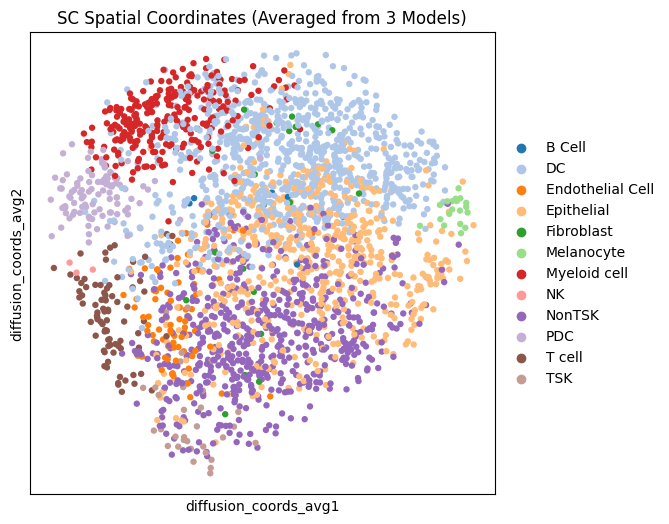

<Figure size 400x400 with 0 Axes>

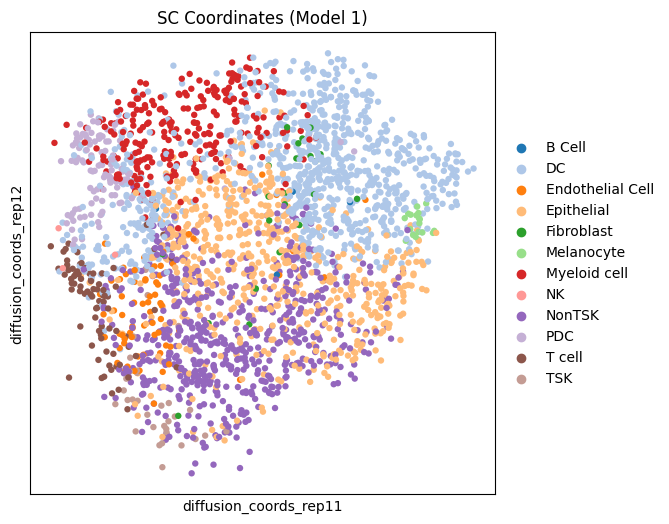

<Figure size 400x400 with 0 Axes>

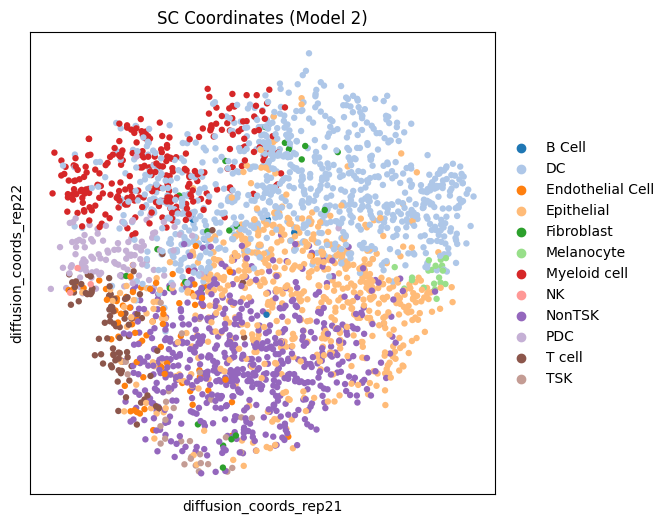

<Figure size 400x400 with 0 Axes>

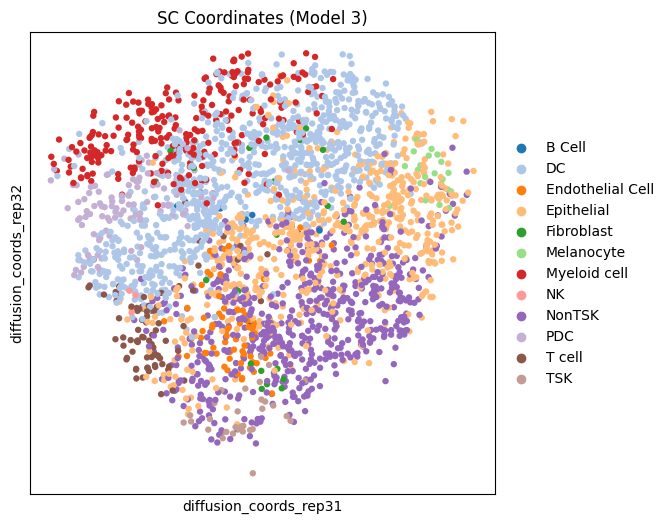

In [29]:
# Visualize results with separate plots
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)


import seaborn as sns
my_tab20 = sns.color_palette("tab20", n_colors=20).as_hex()

# Plot 1: Averaged coordinates
plt.figure(figsize=(4, 4))
sc.pl.embedding(scadata, basis='diffusion_coords_avg', color='rough_celltype',
               size=85, title='SC Spatial Coordinates (Averaged from 3 Models)',
               palette=my_tab20, legend_loc='right margin', legend_fontsize=10)
plt.show()

# Plot 2: Model 1 results
plt.figure(figsize=(4, 4))
sc.pl.embedding(scadata, basis='diffusion_coords_rep1', color='rough_celltype',
               size=85, title='SC Coordinates (Model 1)',
               palette=my_tab20, legend_loc='right margin', legend_fontsize=10)
plt.show()

# Plot 3: Model 2 results
plt.figure(figsize=(4, 4))
sc.pl.embedding(scadata, basis='diffusion_coords_rep2', color='rough_celltype',
               size=85, title='SC Coordinates (Model 2)',
               palette=my_tab20, legend_loc='right margin', legend_fontsize=10)
plt.show()



# Plot 4: Model 3 results
plt.figure(figsize=(4, 4))
sc.pl.embedding(scadata, basis='diffusion_coords_rep3', color='rough_celltype',
               size=85, title='SC Coordinates (Model 3)',
             palette=my_tab20, legend_loc='right margin', legend_fontsize=10)
plt.show()

In [ ]:
def train_individual_diffusion_models_spaotsc(scadata, stadata1, stadata2, stadata3):
    """
    Train separate diffusion models for each ST dataset using SpaOTsc and average the results.
    
    Returns:
        scadata: Updated with averaged coordinates in obsm['diffusion_coords_avg']
        T_all: All transport plans from SpaOTsc
        D_induced_all: All induced distance matrices from SpaOTsc  
        D_st_all: All ST distance matrices
        D_sc_all: All SC distance matrices
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Store results from each model
    sc_coords_results = []
    
    # List of ST datasets for iteration
    st_datasets = [
        (stadata1, "dataset1"),
        (stadata2, "dataset2"), 
        (stadata3, "dataset3")
    ]

    T_all = []
    D_induced_all = []
    D_st_all = []
    D_sc_all = []
    spaotsc_quality_all = []

    
    for i, (stadata, dataset_name) in enumerate(st_datasets):
        print(f"\n{'='*50}")
        print(f"Training diffusion model {i+1}/3 for {dataset_name} using SpaOTsc")
        print(f"{'='*50}")
        
        # Get common genes between SC and current ST dataset
        sc_genes = set(scadata.var_names)
        st_genes = set(stadata.var_names)
        common_genes = sorted(list(sc_genes & st_genes))
        
        print(f"Common genes for {dataset_name}: {len(common_genes)}")
        
        # Extract aligned expression data
        sc_expr = scadata[:, common_genes].X
        st_expr = stadata[:, common_genes].X
        
        # Convert to dense if sparse
        if hasattr(sc_expr, 'toarray'):
            sc_expr = sc_expr.toarray()
        if hasattr(st_expr, 'toarray'):
            st_expr = st_expr.toarray()
            
        # Get spatial coordinates
        st_coords = stadata.obsm['spatial'].astype(np.float32)
        
        # Convert to tensors
        X_sc = torch.tensor(sc_expr, dtype=torch.float32)
        X_st = torch.tensor(st_expr, dtype=torch.float32)
        
        print(f"SC shape: {X_sc.shape}, ST shape: {X_st.shape}")
        
        # === REPLACE FUSED_GW_TORCH WITH SPAOTSC ===
        print(f"Running SpaOTsc for {dataset_name}...")

        gamma_transport, D_sc, D_st, D_induced, spaotsc_quality = replace_fused_gw_with_spaotsc(
            X_sc=X_sc,
            X_st=X_st,
            Y_st=st_coords,
            k_neighbors=30,  # Keep same as your original k
            alpha=0.9,       # Keep same as your original alpha
            device=device
        )
        
        print(f"SpaOTsc completed for {dataset_name}! Quality: {spaotsc_quality:.4f}")

        # Store all matrices for testing
        T_all.append(gamma_transport.cpu().numpy())
        D_induced_all.append(D_induced.cpu().numpy())
        D_st_all.append(D_st.cpu().numpy()) 
        D_sc_all.append(D_sc.cpu().numpy())
        spaotsc_quality_all.append(spaotsc_quality)


        # Initialize diffusion model (EXACTLY THE SAME as before)
        output_dir = f'./cscc_stem_diffusion_spaotsc_{dataset_name}'
        stem_diffusion = STEMDiffusion(
            st_gene_expr=X_st.cpu().numpy(),
            st_coords=st_coords,
            D_st=D_st.cpu().numpy(),
            sc_gene_expr=X_sc.cpu().numpy(),
            D_induced=D_induced.cpu().numpy(),  # ← This is the key difference!
            outf=output_dir,
            device=device,
            n_genes=len(common_genes),
            n_embedding=[512, 256, 128],
            hidden_dim=256,
            dp=0.2,
            n_timesteps=800,
            beta_start=1e-4,
            beta_end=0.02,
            sigma=3.0,
            alpha=0.8,
            mmdbatch=1000,
            batch_size=300,
            coord_space_diameter=2.0,
            # Note: SpaOTsc doesn't return max distances, so we'll compute them
            st_max_distance=np.max(D_st.cpu().numpy()),
            sc_max_distance=np.max(D_sc.cpu().numpy())
        )
        
        # Train the model (EXACTLY THE SAME as before)
        print(f"Training diffusion model for {dataset_name}...")
        stem_diffusion.train(encoder_epochs=800)
        
        # Generate SC coordinates (EXACTLY THE SAME as before)
        print(f"Generating SC coordinates for {dataset_name}...")

        # sc_coords = stem_diffusion.sample_sc_with_soft_springs(
        #     batch_size   = 256,
        #     timesteps    = 800,
        #     use_springs  = True,
        #     spring_lr    = 0.01,
        #     spring_iters = 500,
        #     k_neighbors  = 500,
        #     lambda_s     = 0.5,
        #     min_dist     = None,   # ensure no two cells end up closer than 0.05 (in normalized space)
        #     return_normalized=True
        # )

        sc_coords = stem_diffusion.sample_sc_with_smacof(
            batch_size=256,
            timesteps=800,
            k_neighbors=500,  # Not used but kept for compatibility
            smacof_iters=500,  # Replaces spring_iters
            lambda_s=0.0,
            return_normalized=True
        )
        # sc_coords = stem_diffusion.generate_sc_coordinates_two_stage(return_normalized=True)
        
        # Convert to numpy if needed
        if isinstance(sc_coords, torch.Tensor):
            sc_coords_np = sc_coords.cpu().numpy()
        else:
            sc_coords_np = sc_coords
            
        sc_coords_results.append(sc_coords_np)
        print(f"Completed {dataset_name}: {sc_coords_np.shape}")
        
        # Clean up GPU memory
        # del gamma_transport, D_sc, D_st, D_induced, stem_diffusion, X_st
        torch.cuda.empty_cache()
    
    # Average the results (EXACTLY THE SAME as before)
    print(f"\nAveraging results from {len(sc_coords_results)} models...")
    sc_coords_avg = np.mean(sc_coords_results, axis=0)
    
    # Verify shapes match
    shapes = [coords.shape for coords in sc_coords_results]
    assert all(shape == shapes[0] for shape in shapes), f"Shape mismatch: {shapes}"
    
    print(f"Final averaged coordinates shape: {sc_coords_avg.shape}")
    
    # Add to AnnData
    scadata.obsm['diffusion_coords_avg'] = sc_coords_avg
    
    # Optionally, save individual results too
    for i, coords in enumerate(sc_coords_results):
        scadata.obsm[f'diffusion_coords_rep{i+1}'] = coords
    
    # Print SpaOTsc quality metrics
    print(f"\nSpaOTsc Quality Metrics:")
    for i, quality in enumerate(spaotsc_quality_all):
        print(f"  Dataset {i+1}: {quality:.6f}")
    print(f"  Average: {np.mean(spaotsc_quality_all):.6f}")
    
    return scadata, T_all, D_induced_all, D_st_all, D_sc_all

# Load and process data (keeping your existing function)
scadata, stadata1, stadata2, stadata3 = load_and_process_cscc_data()

# Train individual models using SpaOTsc and get averaged results
scadata, T_spaotsc_all, D_induced_spaotsc_all, D_st_all, D_sc_all = train_individual_diffusion_models_spaotsc(
    scadata, stadata1, stadata2, stadata3
)

print("SpaOTsc training complete! Results saved in scadata.obsm['diffusion_coords_avg']")

# Now you have all the matrices for testing:
print(f"\nMatrices available for testing:")
print(f"T_spaotsc_all: {len(T_spaotsc_all)} transport plans")
print(f"D_induced_spaotsc_all: {len(D_induced_spaotsc_all)} induced distance matrices")
print(f"D_st_all: {len(D_st_all)} ST distance matrices") 
print(f"D_sc_all: {len(D_sc_all)} SC distance matrices")

Loading cSCC data...

Training diffusion model 1/3 for dataset1 using SpaOTsc
Common genes for dataset1: 2000
SC shape: torch.Size([2688, 2000]), ST shape: torch.Size([666, 2000])
Running SpaOTsc for dataset1...
Calculating SC distances with k-NN Dijkstra...
using device: cuda
constructing knn graph...


/tmp/ipykernel_3018293/1005213891.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)
/tmp/ipykernel_3018293/1005213891.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  knn_graph = torch.sparse_coo_tensor(torch.LongTensor([knn_graph_coo.row, knn_graph_coo.col]),


calculating distances from graph....
D_sc calculation complete
Calculating ST distances...
constructing distance graph for ST data with k=50.....
calculating spatial distances.....
D_st calculation complete
Applying SpaOTsc spatial distance computation...
=== SpaOTsc Spatial Distance Matrix Computation ===
SC data: (2688, 2000), ST data: (666, 2000)
Alpha (structure weight): 0.9
Feature metric: euclidean
Marginal method: exponential

--- Stage 1: Structured Optimal Transport ---
Computing feature cost matrix...
Computing marginal weights...
Solving structured optimal transport...
Structured OT converged at iteration 3
Transport plan shape: (2688, 666)
Transport plan mass: 0.995663
Spatial spread of top spots: 5.8976923751596875
Random spread: 6.148006810006037

--- Stage 2: Pairwise Wasserstein Distances ---
computing transport-aware geodasic distances (sigma=3.0, k=30)
Computing Euclidean D_st for transport weighting...
Computing spatial affinity kernel...
Computing transport-weighted

/tmp/ipykernel_3018293/1005213891.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)


calculating distances from graph....
D_sc calculation complete
Calculating ST distances...
constructing distance graph for ST data with k=50.....
calculating spatial distances.....
D_st calculation complete
Applying SpaOTsc spatial distance computation...
=== SpaOTsc Spatial Distance Matrix Computation ===
SC data: (2688, 2000), ST data: (646, 2000)
Alpha (structure weight): 0.9
Feature metric: euclidean
Marginal method: exponential

--- Stage 1: Structured Optimal Transport ---
Computing feature cost matrix...
Computing marginal weights...
Solving structured optimal transport...


<Figure size 400x400 with 0 Axes>

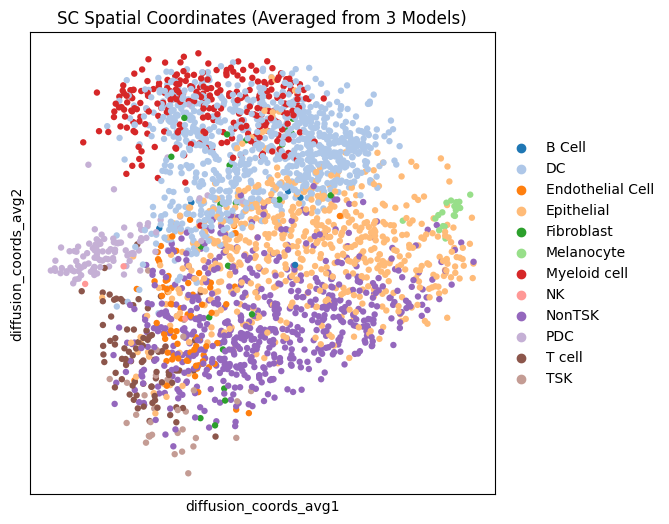

<Figure size 400x400 with 0 Axes>

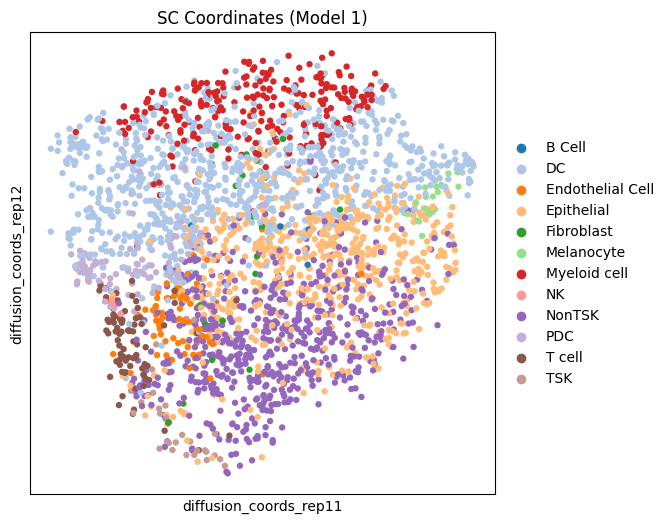

<Figure size 400x400 with 0 Axes>

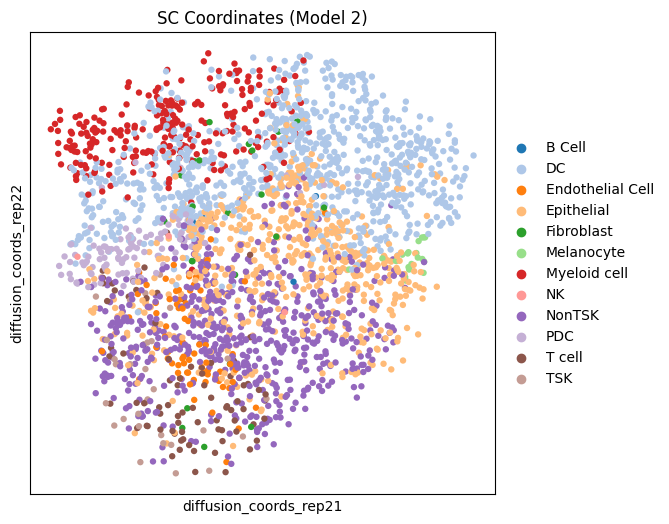

<Figure size 400x400 with 0 Axes>

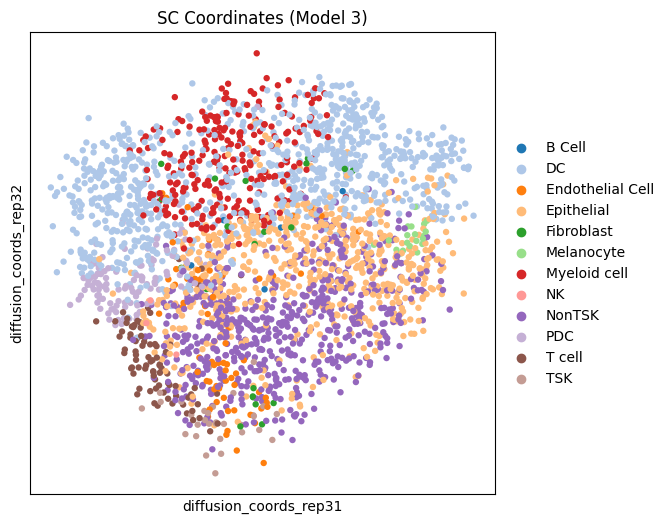

In [35]:
# Visualize results with separate plots
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)


import seaborn as sns
my_tab20 = sns.color_palette("tab20", n_colors=20).as_hex()

# Plot 1: Averaged coordinates
plt.figure(figsize=(4, 4))
sc.pl.embedding(scadata, basis='diffusion_coords_avg', color='rough_celltype',
               size=85, title='SC Spatial Coordinates (Averaged from 3 Models)',
               palette=my_tab20, legend_loc='right margin', legend_fontsize=10)
plt.show()

# Plot 2: Model 1 results
plt.figure(figsize=(4, 4))
sc.pl.embedding(scadata, basis='diffusion_coords_rep1', color='rough_celltype',
               size=85, title='SC Coordinates (Model 1)',
               palette=my_tab20, legend_loc='right margin', legend_fontsize=10)
plt.show()

# Plot 3: Model 2 results
plt.figure(figsize=(4, 4))
sc.pl.embedding(scadata, basis='diffusion_coords_rep2', color='rough_celltype',
               size=85, title='SC Coordinates (Model 2)',
               palette=my_tab20, legend_loc='right margin', legend_fontsize=10)
plt.show()



# Plot 4: Model 3 results
plt.figure(figsize=(4, 4))
sc.pl.embedding(scadata, basis='diffusion_coords_rep3', color='rough_celltype',
               size=85, title='SC Coordinates (Model 3)',
             palette=my_tab20, legend_loc='right margin', legend_fontsize=10)
plt.show()

In [ ]:
D_sc_all[0].max()

In [ ]:
D_induced_all

In [ ]:
D_induced_spaotsc_all

🎯 Generating SMACOF coordinates from D_induced matrices...

🔬 Processing Dataset 1
   Distance matrix shape: (2688, 2688)
   Distance range: [0.0000, 1.0000]
   SMACOF stress: 0.193242

🔬 Processing Dataset 2
   Distance matrix shape: (2688, 2688)
   Distance range: [0.0000, 1.0000]
   SMACOF stress: 0.181985

🔬 Processing Dataset 3
   Distance matrix shape: (2688, 2688)
   Distance range: [0.0000, 1.0000]
   SMACOF stress: 0.189253


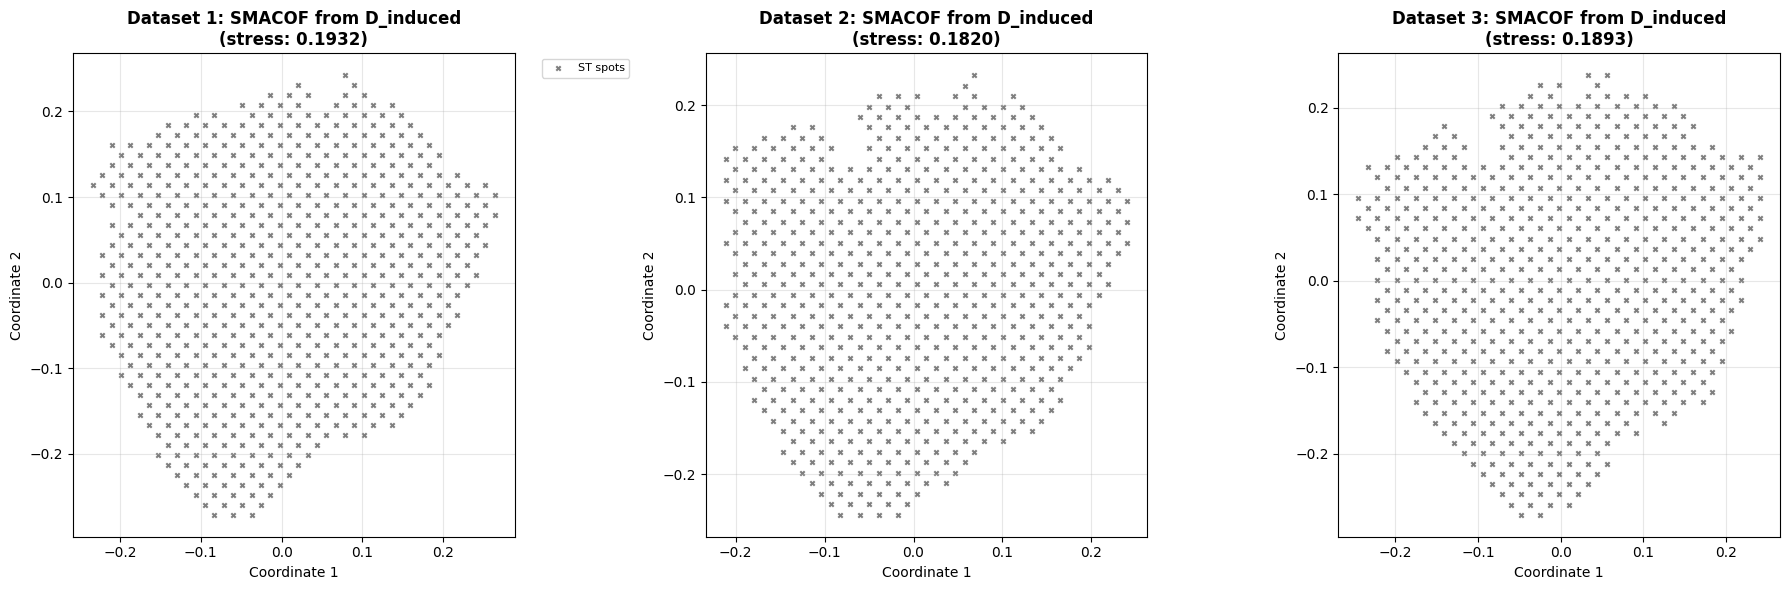


📊 SUMMARY:
   Generated coordinates for 3 datasets
   Cell types: ['DC', 'Endothelial Cell', 'Epithelial', 'NonTSK', 'Fibroblast', 'Myeloid cell', 'T cell', 'PDC', 'TSK', 'B Cell', 'Melanocyte', 'NK']
   Plot saved as 'smacof_coordinates_from_d_induced.png'


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import smacof

def plot_smacof_from_distance_matrices(D_induced_spaotsc_all, scadata, st_datasets=None):
    """
    Apply SMACOF to each D_induced matrix and plot coordinates colored by cell type.
    
    Args:
        D_induced_spaotsc_all: List of 3 D_induced distance matrices
        scadata: AnnData with cell type info in obs['rough_celltype']
        st_datasets: Optional list of (stadata1, stadata2, stadata3) for overlay
    """
    
    # Set up colors for cell types
    my_tab20 = sns.color_palette("tab20", n_colors=20).as_hex()
    cell_types = scadata.obs['rough_celltype'].unique()
    color_map = {ct: my_tab20[i % len(my_tab20)] for i, ct in enumerate(cell_types)}
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, D_induced in enumerate(D_induced_spaotsc_all):
        print(f"\n🔬 Processing Dataset {i+1}")
        print(f"   Distance matrix shape: {D_induced.shape}")
        
        # Step 1: Prepare distance matrix
        if torch.is_tensor(D_induced):
            D_target = D_induced.detach().cpu().numpy()
        else:
            D_target = D_induced.copy()
            
        D_target = D_target.astype(np.float64)
        
        # Step 2: Enforce symmetry & zero diagonal
        D_target = 0.5 * (D_target + D_target.T)
        np.fill_diagonal(D_target, 0.0)
        
        print(f"   Distance range: [{D_target.min():.4f}, {D_target.max():.4f}]")
        
        # Step 3: Apply SMACOF
        try:
            mds_coords, stress = smacof(
                D_target,
                n_components=2,
                metric=True,
                n_init=1,
                max_iter=300,
                verbose=False,
                random_state=42,
                normalized_stress=True
            )
            
            print(f"   SMACOF stress: {stress:.6f}")
            
        except Exception as e:
            print(f"   ❌ SMACOF failed: {e}")
            # Fallback to random coordinates
            mds_coords = np.random.randn(D_target.shape[0], 2)
            stress = float('inf')
        
        # Step 4: Plot coordinates colored by cell type
        ax = axes[i]
        
        # Get cell types for coloring
        cell_types_list = scadata.obs['rough_celltype'].values
        
        # Plot each cell type separately for legend
        # for ct in cell_types:
        #     mask = cell_types_list == ct
        #     if np.any(mask):
        #         ax.scatter(mds_coords[mask, 0], mds_coords[mask, 1], 
        #                   c=color_map[ct], label=ct, s=20, alpha=0.7)
        
        # Optional: Overlay ST spots if provided
        if st_datasets is not None and i < len(st_datasets):
            stadata = st_datasets[i]
            st_coords = stadata.obsm['spatial']
            
            # Normalize ST coordinates to roughly match SC coordinate range
            st_coords_norm = (st_coords - st_coords.mean(axis=0)) / st_coords.std(axis=0)
            sc_scale = mds_coords.std()
            st_coords_scaled = st_coords_norm * sc_scale
            
            ax.scatter(st_coords_scaled[:, 0], st_coords_scaled[:, 1], 
                      c='black', marker='x', s=10, alpha=0.5, label='ST spots')
        
        ax.set_title(f'Dataset {i+1}: SMACOF from D_induced\n(stress: {stress:.4f})', 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('Coordinate 1')
        ax.set_ylabel('Coordinate 2')
        ax.grid(True, alpha=0.3)
        
        # Add legend (only for first plot to avoid clutter)
        if i == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('smacof_coordinates_from_d_induced.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"\n📊 SUMMARY:")
    print(f"   Generated coordinates for {len(D_induced_spaotsc_all)} datasets")
    print(f"   Cell types: {list(cell_types)}")
    print(f"   Plot saved as 'smacof_coordinates_from_d_induced.png'")

# Usage:
print("🎯 Generating SMACOF coordinates from D_induced matrices...")

# With ST overlay (optional)
st_datasets = [stadata1, stadata2, stadata3]
plot_smacof_from_distance_matrices(D_induced_spaotsc_all, scadata, st_datasets)

# Or without ST overlay
# plot_smacof_from_distance_matrices(D_induced_spaotsc_all, scadata)

In [ ]:
st

🎯 Generating MDS embeddings from D_induced matrices...

📊 Processing Dataset 1
   Distance matrix shape: (2688, 2688)
   Distance range: [0.0000, 1.0000]
   MDS stress: 230.096793

📊 Processing Dataset 2
   Distance matrix shape: (2688, 2688)
   Distance range: [0.0000, 1.0000]
   MDS stress: 639.380224

📊 Processing Dataset 3
   Distance matrix shape: (2688, 2688)
   Distance range: [0.0000, 1.0000]
   MDS stress: 670.137147


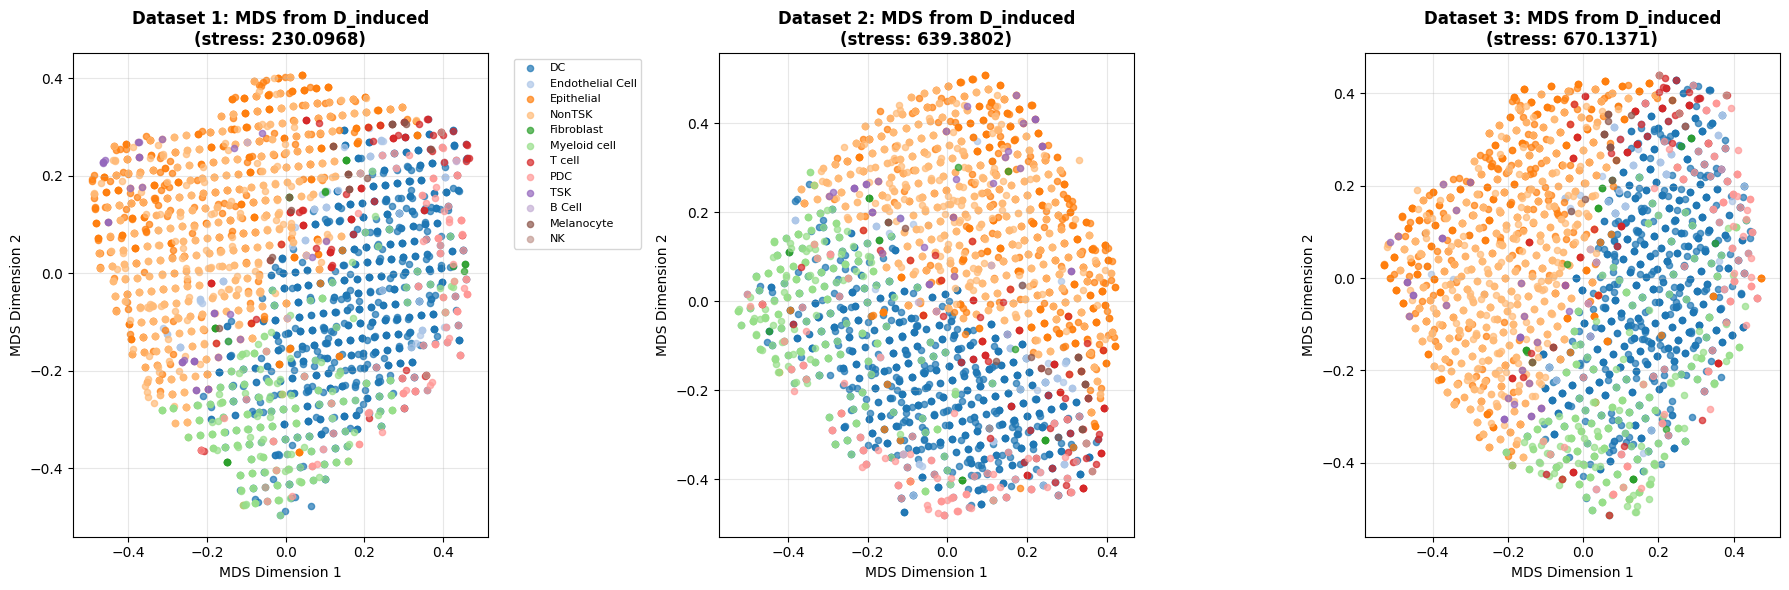


📋 SUMMARY:
   Generated MDS embeddings for 3 datasets
   Cell types: ['DC', 'Endothelial Cell', 'Epithelial', 'NonTSK', 'Fibroblast', 'Myeloid cell', 'T cell', 'PDC', 'TSK', 'B Cell', 'Melanocyte', 'NK']
   Plot saved as 'mds_coordinates_from_d_induced.png'


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS

def plot_mds_from_distance_matrices(D_induced_spaotsc_all, scadata):
    """
    Apply standard MDS to each D_induced matrix and plot coordinates colored by cell type.
    
    Args:
        D_induced_spaotsc_all: List of 3 D_induced distance matrices
        scadata: AnnData with cell type info in obs['rough_celltype']
    """
    
    # Set up colors for cell types
    my_tab20 = sns.color_palette("tab20", n_colors=20).as_hex()
    cell_types = scadata.obs['rough_celltype'].unique()
    color_map = {ct: my_tab20[i % len(my_tab20)] for i, ct in enumerate(cell_types)}
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, D_induced in enumerate(D_induced_spaotsc_all):
        print(f"\n📊 Processing Dataset {i+1}")
        print(f"   Distance matrix shape: {D_induced.shape}")
        
        # Step 1: Prepare distance matrix
        if torch.is_tensor(D_induced):
            D_target = D_induced.detach().cpu().numpy()
        else:
            D_target = D_induced.copy()
            
        D_target = D_target.astype(np.float64)
        
        # Step 2: Enforce symmetry & zero diagonal
        D_target = 0.5 * (D_target + D_target.T)
        np.fill_diagonal(D_target, 0.0)
        
        print(f"   Distance range: [{D_target.min():.4f}, {D_target.max():.4f}]")
        
        # Step 3: Apply standard MDS
        try:
            mds = MDS(
                n_components=2,
                dissimilarity="precomputed",
                metric=True,  # Use metric MDS
                n_init=4,     # Multiple random initializations
                max_iter=300,
                eps=1e-6,
                random_state=42,
                verbose=0
            )
            
            mds_coords = mds.fit_transform(D_target)
            stress = mds.stress_
            
            print(f"   MDS stress: {stress:.6f}")
            
        except Exception as e:
            print(f"   ❌ MDS failed: {e}")
            # Fallback to random coordinates
            mds_coords = np.random.randn(D_target.shape[0], 2)
            stress = float('inf')
        
        # Step 4: Plot coordinates colored by cell type
        ax = axes[i]
        
        # Get cell types for coloring
        cell_types_list = scadata.obs['rough_celltype'].values
        
        # Plot each cell type separately for legend
        for ct in cell_types:
            mask = cell_types_list == ct
            if np.any(mask):
                ax.scatter(mds_coords[mask, 0], mds_coords[mask, 1], 
                          c=color_map[ct], label=ct, s=20, alpha=0.7)
        
        ax.set_title(f'Dataset {i+1}: MDS from D_induced\n(stress: {stress:.4f})', 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('MDS Dimension 1')
        ax.set_ylabel('MDS Dimension 2')
        ax.grid(True, alpha=0.3)
        
        # Add legend (only for first plot to avoid clutter)
        if i == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('mds_coordinates_from_d_induced.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"\n📋 SUMMARY:")
    print(f"   Generated MDS embeddings for {len(D_induced_spaotsc_all)} datasets")
    print(f"   Cell types: {list(cell_types)}")
    print(f"   Plot saved as 'mds_coordinates_from_d_induced.png'")

# Usage:
print("🎯 Generating MDS embeddings from D_induced matrices...")
plot_mds_from_distance_matrices(D_induced_all, scadata)

🎯 Generating MDS embeddings from D_induced matrices...

📊 Processing Dataset 1
   Distance matrix shape: (2688, 2688)
   Distance range: [0.0000, 1.0000]


   MDS stress: 246079.997675

📊 Processing Dataset 2
   Distance matrix shape: (2688, 2688)
   Distance range: [0.0000, 1.0000]
   MDS stress: 250907.964812

📊 Processing Dataset 3
   Distance matrix shape: (2688, 2688)
   Distance range: [0.0000, 1.0000]
   MDS stress: 254504.519318


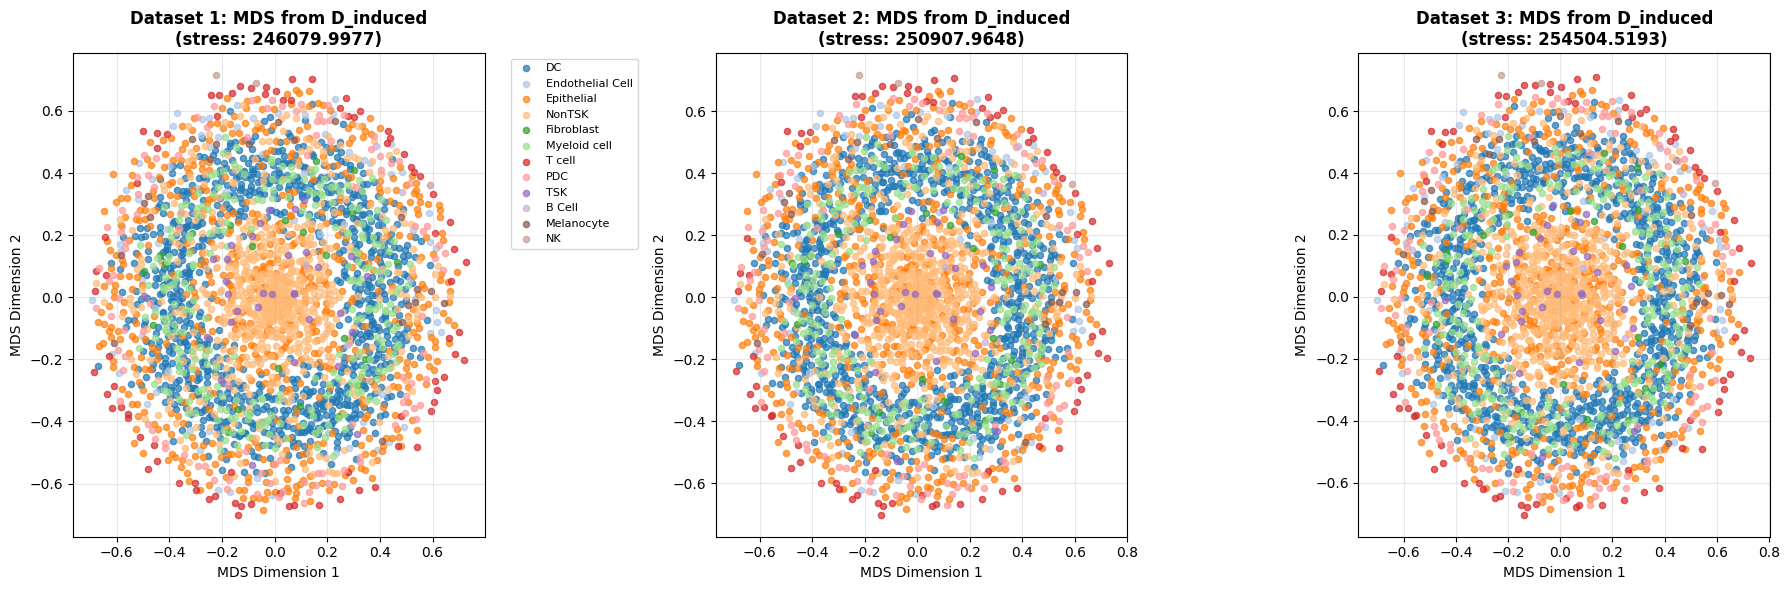


📋 SUMMARY:
   Generated MDS embeddings for 3 datasets
   Cell types: ['DC', 'Endothelial Cell', 'Epithelial', 'NonTSK', 'Fibroblast', 'Myeloid cell', 'T cell', 'PDC', 'TSK', 'B Cell', 'Melanocyte', 'NK']
   Plot saved as 'mds_coordinates_from_d_induced.png'


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS

def plot_mds_from_distance_matrices(D_induced_spaotsc_all, scadata):
    """
    Apply standard MDS to each D_induced matrix and plot coordinates colored by cell type.
    
    Args:
        D_induced_spaotsc_all: List of 3 D_induced distance matrices
        scadata: AnnData with cell type info in obs['rough_celltype']
    """
    
    # Set up colors for cell types
    my_tab20 = sns.color_palette("tab20", n_colors=20).as_hex()
    cell_types = scadata.obs['rough_celltype'].unique()
    color_map = {ct: my_tab20[i % len(my_tab20)] for i, ct in enumerate(cell_types)}
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, D_induced in enumerate(D_induced_spaotsc_all):
        print(f"\n📊 Processing Dataset {i+1}")
        print(f"   Distance matrix shape: {D_induced.shape}")
        
        # Step 1: Prepare distance matrix
        if torch.is_tensor(D_induced):
            D_target = D_induced.detach().cpu().numpy()
        else:
            D_target = D_induced.copy()
            
        D_target = D_target.astype(np.float64)
        
        # Step 2: Enforce symmetry & zero diagonal
        D_target = 0.5 * (D_target + D_target.T)
        np.fill_diagonal(D_target, 0.0)
        
        print(f"   Distance range: [{D_target.min():.4f}, {D_target.max():.4f}]")
        
        # Step 3: Apply standard MDS
        try:
            mds = MDS(
                n_components=2,
                dissimilarity="precomputed",
                metric=True,  # Use metric MDS
                n_init=4,     # Multiple random initializations
                max_iter=300,
                eps=1e-6,
                random_state=42,
                verbose=0
            )
            
            mds_coords = mds.fit_transform(D_target)
            stress = mds.stress_
            
            print(f"   MDS stress: {stress:.6f}")
            
        except Exception as e:
            print(f"   ❌ MDS failed: {e}")
            # Fallback to random coordinates
            mds_coords = np.random.randn(D_target.shape[0], 2)
            stress = float('inf')
        
        # Step 4: Plot coordinates colored by cell type
        ax = axes[i]
        
        # Get cell types for coloring
        cell_types_list = scadata.obs['rough_celltype'].values
        
        # Plot each cell type separately for legend
        for ct in cell_types:
            mask = cell_types_list == ct
            if np.any(mask):
                ax.scatter(mds_coords[mask, 0], mds_coords[mask, 1], 
                          c=color_map[ct], label=ct, s=20, alpha=0.7)
        
        ax.set_title(f'Dataset {i+1}: MDS from D_induced\n(stress: {stress:.4f})', 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('MDS Dimension 1')
        ax.set_ylabel('MDS Dimension 2')
        ax.grid(True, alpha=0.3)
        
        # Add legend (only for first plot to avoid clutter)
        if i == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('mds_coordinates_from_d_induced.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"\n📋 SUMMARY:")
    print(f"   Generated MDS embeddings for {len(D_induced_spaotsc_all)} datasets")
    print(f"   Cell types: {list(cell_types)}")
    print(f"   Plot saved as 'mds_coordinates_from_d_induced.png'")

# Usage:
print("🎯 Generating MDS embeddings from D_induced matrices...")
plot_mds_from_distance_matrices(D_induced_spaotsc_all, scadata)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compare_d_induced_matrices(D_induced_spaotsc_all, D_induced_all, save_plots=True):
    """
    Comprehensive comparison of D_induced matrices from SpaOTsc vs FGW methods.
    
    Args:
        D_induced_spaotsc_all: List of 3 D_induced matrices from SpaOTsc
        D_induced_all: List of 3 D_induced matrices from FGW  
        save_plots: Whether to save plots to files
    """
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # Storage for statistics
    stats_summary = []
    
    for dataset_idx in range(3):
        print(f"\n{'='*60}")
        print(f"DATASET {dataset_idx + 1} COMPARISON")
        print(f"{'='*60}")
        
        # Get matrices for current dataset
        D_spaotsc = D_induced_spaotsc_all[dataset_idx]
        D_fgw = D_induced_all[dataset_idx]
        
        print(f"SpaOTsc matrix shape: {D_spaotsc.shape}")
        print(f"FGW matrix shape: {D_fgw.shape}")
        
        # Ensure matrices are the same size
        min_size = min(D_spaotsc.shape[0], D_fgw.shape[0])
        D_spaotsc_trimmed = D_spaotsc[:min_size, :min_size]
        D_fgw_trimmed = D_fgw[:min_size, :min_size]
        
        # Get upper triangular indices (excluding diagonal) for comparison
        triu_indices = np.triu_indices(min_size, k=1)
        spaotsc_values = D_spaotsc_trimmed[triu_indices]
        fgw_values = D_fgw_trimmed[triu_indices]
        
        # Calculate statistics
        pearson_corr, pearson_p = pearsonr(spaotsc_values, fgw_values)
        spearman_corr, spearman_p = spearmanr(spaotsc_values, fgw_values)
        mse = mean_squared_error(spaotsc_values, fgw_values)
        mae = mean_absolute_error(spaotsc_values, fgw_values)
        
        # Store statistics
        stats_summary.append({
            'Dataset': f'Dataset {dataset_idx + 1}',
            'Pearson_r': pearson_corr,
            'Pearson_p': pearson_p,
            'Spearman_r': spearman_corr,
            'Spearman_p': spearman_p,
            'MSE': mse,
            'MAE': mae,
            'SpaOTsc_mean': np.mean(spaotsc_values),
            'FGW_mean': np.mean(fgw_values),
            'SpaOTsc_std': np.std(spaotsc_values),
            'FGW_std': np.std(fgw_values)
        })
        
        print(f"Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.2e})")
        print(f"Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.2e})")
        print(f"MSE: {mse:.6f}")
        print(f"MAE: {mae:.6f}")
        
        # Row 1: Heatmaps of distance matrices
        # SpaOTsc heatmap
        ax1 = plt.subplot(4, 9, dataset_idx * 3 + 1)
        im1 = plt.imshow(D_spaotsc_trimmed, cmap='viridis', aspect='auto')
        plt.title(f'Dataset {dataset_idx + 1}\nSpaOTsc D_induced', fontsize=10)
        plt.colorbar(im1, shrink=0.8)
        
        # FGW heatmap  
        ax2 = plt.subplot(4, 9, dataset_idx * 3 + 2)
        im2 = plt.imshow(D_fgw_trimmed, cmap='viridis', aspect='auto')
        plt.title(f'Dataset {dataset_idx + 1}\nFGW D_induced', fontsize=10)
        plt.colorbar(im2, shrink=0.8)
        
        # Difference heatmap
        ax3 = plt.subplot(4, 9, dataset_idx * 3 + 3)
        diff_matrix = D_spaotsc_trimmed - D_fgw_trimmed
        im3 = plt.imshow(diff_matrix, cmap='RdBu_r', aspect='auto')
        plt.title(f'Dataset {dataset_idx + 1}\nDifference\n(SpaOTsc - FGW)', fontsize=10)
        plt.colorbar(im3, shrink=0.8)
        
        # Row 2: Scatter plots
        ax4 = plt.subplot(4, 3, dataset_idx + 4)
        
        # Subsample for clearer visualization if too many points
        if len(spaotsc_values) > 10000:
            indices = np.random.choice(len(spaotsc_values), 10000, replace=False)
            x_plot = spaotsc_values[indices]
            y_plot = fgw_values[indices]
        else:
            x_plot = spaotsc_values
            y_plot = fgw_values
            
        plt.scatter(x_plot, y_plot, alpha=0.5, s=1)
        plt.plot([min(x_plot.min(), y_plot.min()), max(x_plot.max(), y_plot.max())], 
                [min(x_plot.min(), y_plot.min()), max(x_plot.max(), y_plot.max())], 
                'r--', alpha=0.8)
        plt.xlabel('SpaOTsc D_induced values')
        plt.ylabel('FGW D_induced values')
        plt.title(f'Dataset {dataset_idx + 1} Scatter Plot\nr={pearson_corr:.3f}')
        plt.grid(True, alpha=0.3)
        
        # Row 3: Distribution comparisons
        ax5 = plt.subplot(4, 3, dataset_idx + 7)
        
        # Histogram comparison
        plt.hist(spaotsc_values, bins=50, alpha=0.7, label='SpaOTsc', density=True)
        plt.hist(fgw_values, bins=50, alpha=0.7, label='FGW', density=True)
        plt.xlabel('Distance values')
        plt.ylabel('Density')
        plt.title(f'Dataset {dataset_idx + 1} Distributions')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Row 4: Difference distribution
        ax6 = plt.subplot(4, 3, dataset_idx + 10)
        differences = spaotsc_values - fgw_values
        plt.hist(differences, bins=50, alpha=0.7, color='purple')
        plt.axvline(np.mean(differences), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(differences):.4f}')
        plt.xlabel('Difference (SpaOTsc - FGW)')
        plt.ylabel('Frequency')
        plt.title(f'Dataset {dataset_idx + 1} Difference Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('d_induced_comparison_comprehensive.png', dpi=300, bbox_inches='tight')
        print(f"\nPlot saved as 'd_induced_comparison_comprehensive.png'")
    
    plt.show()
    
    # Create summary statistics table
    stats_df = pd.DataFrame(stats_summary)
    
    print(f"\n{'='*80}")
    print("SUMMARY STATISTICS")
    print(f"{'='*80}")
    print(stats_df.round(4))
    
    # Create a focused correlation plot
    create_correlation_summary_plot(stats_df, save_plots)
    
    return stats_df

def create_correlation_summary_plot(stats_df, save_plots=True):
    """Create a summary plot focusing on correlations across datasets."""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Correlation comparison
    ax1 = axes[0, 0]
    x = np.arange(len(stats_df))
    width = 0.35
    
    ax1.bar(x - width/2, stats_df['Pearson_r'], width, label='Pearson', alpha=0.8)
    ax1.bar(x + width/2, stats_df['Spearman_r'], width, label='Spearman', alpha=0.8)
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Correlation Coefficient')
    ax1.set_title('Correlation between SpaOTsc and FGW')
    ax1.set_xticks(x)
    ax1.set_xticklabels(stats_df['Dataset'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Error metrics
    ax2 = axes[0, 1]
    ax2_twin = ax2.twinx()
    
    line1 = ax2.plot(stats_df['Dataset'], stats_df['MSE'], 'ro-', label='MSE')
    line2 = ax2_twin.plot(stats_df['Dataset'], stats_df['MAE'], 'bo-', label='MAE')
    
    ax2.set_xlabel('Dataset')
    ax2.set_ylabel('MSE', color='r')
    ax2_twin.set_ylabel('MAE', color='b')
    ax2.set_title('Error Metrics')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2_twin.tick_params(axis='y', labelcolor='b')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Mean values comparison
    ax3 = axes[1, 0]
    ax3.plot(stats_df['Dataset'], stats_df['SpaOTsc_mean'], 'o-', label='SpaOTsc', linewidth=2)
    ax3.plot(stats_df['Dataset'], stats_df['FGW_mean'], 's-', label='FGW', linewidth=2)
    ax3.set_xlabel('Dataset')
    ax3.set_ylabel('Mean Distance Value')
    ax3.set_title('Mean Distance Values Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Standard deviation comparison
    ax4 = axes[1, 1]
    ax4.plot(stats_df['Dataset'], stats_df['SpaOTsc_std'], 'o-', label='SpaOTsc', linewidth=2)
    ax4.plot(stats_df['Dataset'], stats_df['FGW_std'], 's-', label='FGW', linewidth=2)
    ax4.set_xlabel('Dataset')
    ax4.set_ylabel('Standard Deviation')
    ax4.set_title('Standard Deviation Comparison')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('d_induced_correlation_summary.png', dpi=300, bbox_inches='tight')
        print(f"Summary plot saved as 'd_induced_correlation_summary.png'")
    
    plt.show()

def analyze_matrix_properties(D_induced_spaotsc_all, D_induced_all):
    """Analyze mathematical properties of the distance matrices."""
    
    print(f"\n{'='*80}")
    print("MATRIX PROPERTIES ANALYSIS")
    print(f"{'='*80}")
    
    for dataset_idx in range(3):
        print(f"\nDataset {dataset_idx + 1}:")
        print("-" * 40)
        
        D_spaotsc = D_induced_spaotsc_all[dataset_idx]
        D_fgw = D_induced_all[dataset_idx]
        
        # Check symmetry
        spaotsc_symmetric = np.allclose(D_spaotsc, D_spaotsc.T, rtol=1e-5)
        fgw_symmetric = np.allclose(D_fgw, D_fgw.T, rtol=1e-5)
        
        # Check if diagonal is zero (distance from cell to itself)
        spaotsc_diag_zero = np.allclose(np.diag(D_spaotsc), 0, atol=1e-5)
        fgw_diag_zero = np.allclose(np.diag(D_fgw), 0, atol=1e-5)
        
        # Matrix statistics
        spaotsc_stats = {
            'min': np.min(D_spaotsc),
            'max': np.max(D_spaotsc),
            'mean': np.mean(D_spaotsc),
            'std': np.std(D_spaotsc)
        }
        
        fgw_stats = {
            'min': np.min(D_fgw),
            'max': np.max(D_fgw),
            'mean': np.mean(D_fgw),
            'std': np.std(D_fgw)
        }
        
        print(f"SpaOTsc - Symmetric: {spaotsc_symmetric}, Diagonal=0: {spaotsc_diag_zero}")
        print(f"FGW     - Symmetric: {fgw_symmetric}, Diagonal=0: {fgw_diag_zero}")
        print(f"SpaOTsc stats: {spaotsc_stats}")
        print(f"FGW stats:     {fgw_stats}")

# Main execution
if __name__ == "__main__":
    # This assumes you have the variables D_induced_spaotsc_all and D_induced_all 
    # available in your notebook environment
    
    print("Starting comprehensive D_induced matrix comparison...")
    print("Make sure you have run the cells that generate:")
    print("- D_induced_spaotsc_all (from SpaOTsc method)")
    print("- D_induced_all (from FGW method)")
    print("\nUsage:")
    print("stats_df = compare_d_induced_matrices(D_induced_spaotsc_all, D_induced_all)")
    print("analyze_matrix_properties(D_induced_spaotsc_all, D_induced_all)")

Starting comprehensive D_induced matrix comparison...
Make sure you have run the cells that generate:
- D_induced_spaotsc_all (from SpaOTsc method)
- D_induced_all (from FGW method)

Usage:
stats_df = compare_d_induced_matrices(D_induced_spaotsc_all, D_induced_all)
analyze_matrix_properties(D_induced_spaotsc_all, D_induced_all)


🎯 D_INDUCED COMPARISON TOOL
This will compare SpaOTsc vs FGW D_induced matrices
across your 3 datasets with comprehensive visualizations.

📋 Usage:
1. stats_df = compare_methods()
2. quick_matrix_check()

🔍 COMPARING SpaOTsc vs FGW D_induced MATRICES
✓ D_induced_spaotsc_all: 3 matrices
✓ D_induced_all: 3 matrices

📊 DATASET 1 ANALYSIS
----------------------------------------
SpaOTsc shape: (2688, 2688)
FGW shape:     (2688, 2688)
Pearson r:  0.2791 (p=0.00e+00)
Spearman r: 0.2935 (p=0.00e+00)
MSE:        0.076727
MAE:        0.229295

📊 DATASET 2 ANALYSIS
----------------------------------------
SpaOTsc shape: (2688, 2688)
FGW shape:     (2688, 2688)
Pearson r:  0.2656 (p=0.00e+00)
Spearman r: 0.2858 (p=0.00e+00)
MSE:        0.077635
MAE:        0.229862

📊 DATASET 3 ANALYSIS
----------------------------------------
SpaOTsc shape: (2688, 2688)
FGW shape:     (2688, 2688)
Pearson r:  0.2578 (p=0.00e+00)
Spearman r: 0.2816 (p=0.00e+00)
MSE:        0.086058
MAE:        0.243355


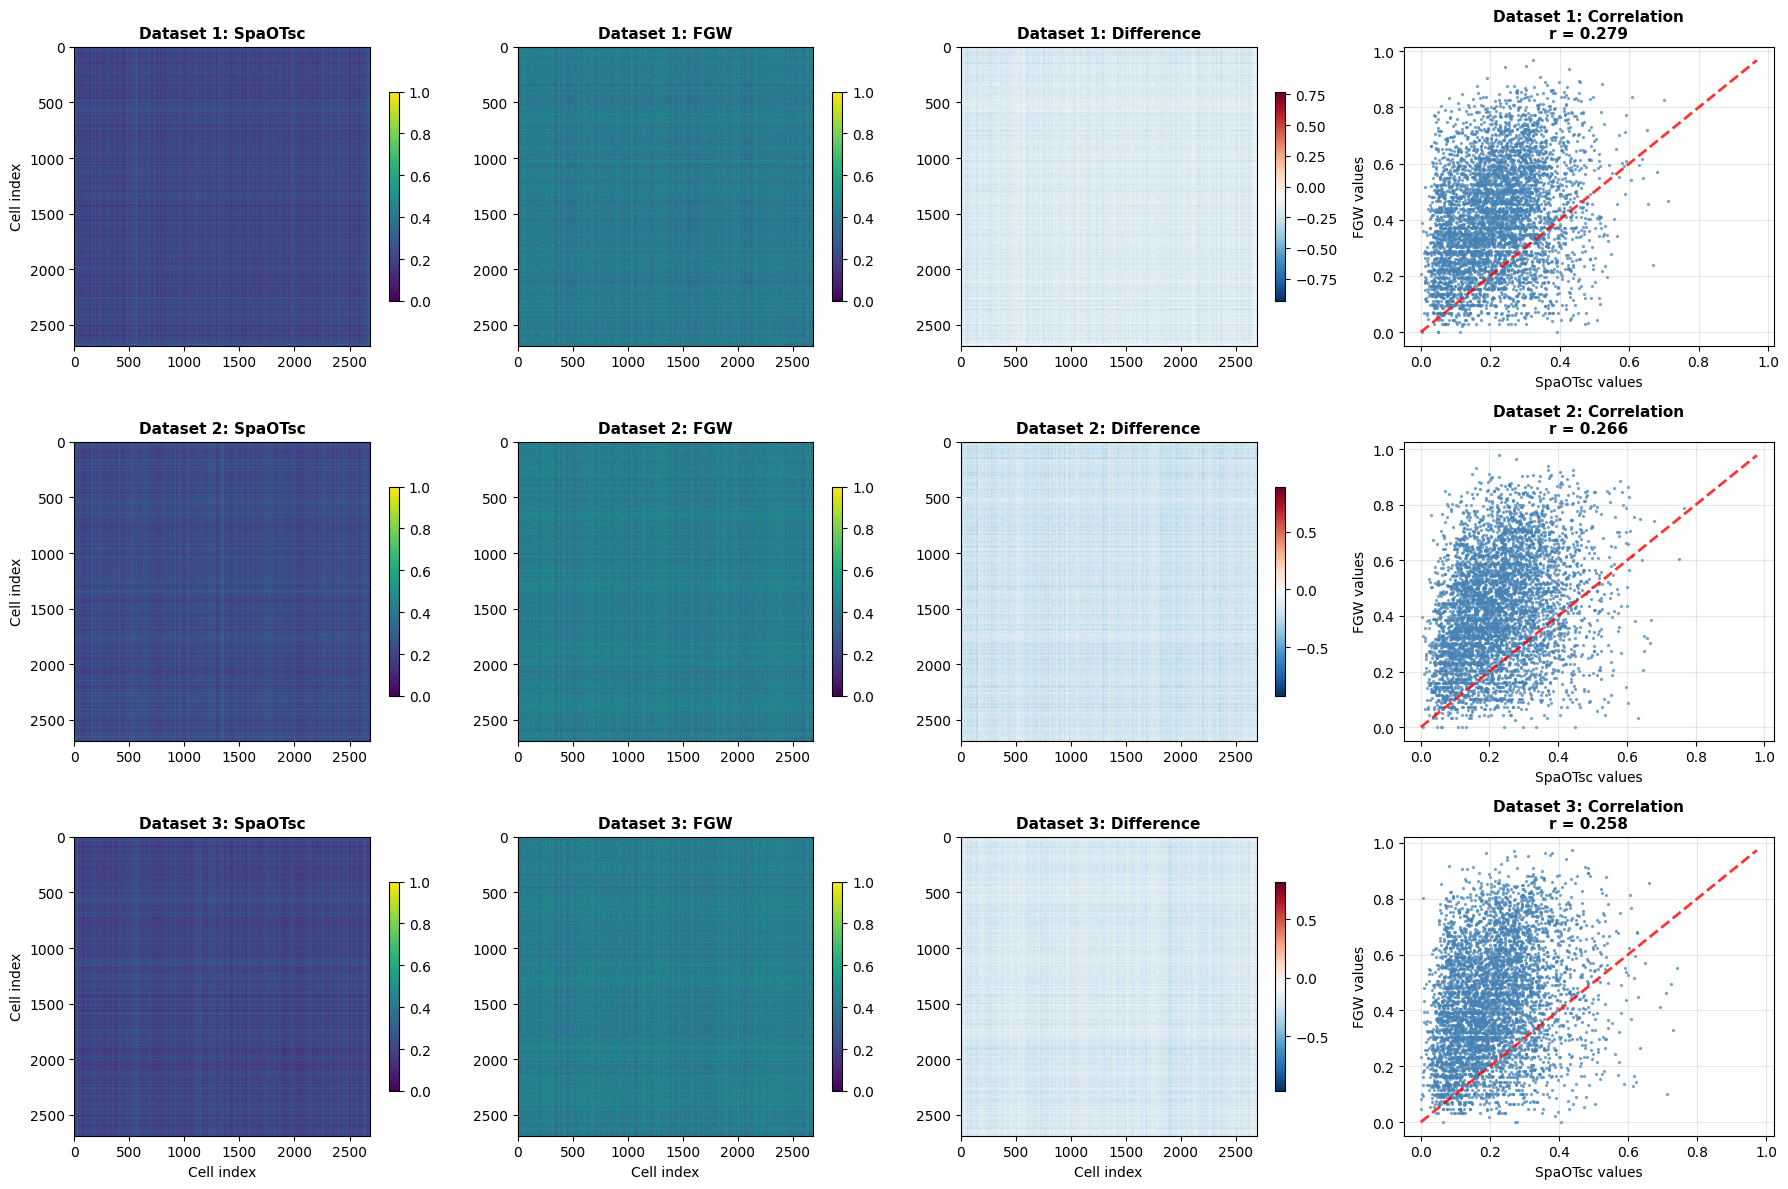


📈 SUMMARY STATISTICS
  Dataset  Pearson_r  Spearman_r    MSE    MAE  SpaOTsc_mean  FGW_mean  SpaOTsc_std  FGW_std
Dataset 1     0.2791      0.2935 0.0767 0.2293        0.2154    0.4112       0.1146   0.1941
Dataset 2     0.2656      0.2858 0.0776 0.2299        0.2315    0.4232       0.1187   0.1983
Dataset 3     0.2578      0.2816 0.0861 0.2434        0.2104    0.4233       0.1144   0.1983


/tmp/ipykernel_2680504/303777808.py:227: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2680504/303777808.py:227: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2680504/303777808.py:228: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig('d_induced_summary.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2680504/303777808.py:228: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.savefig('d_induced_summary.png', dpi=300, bbox_inches='tight')
/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Gl

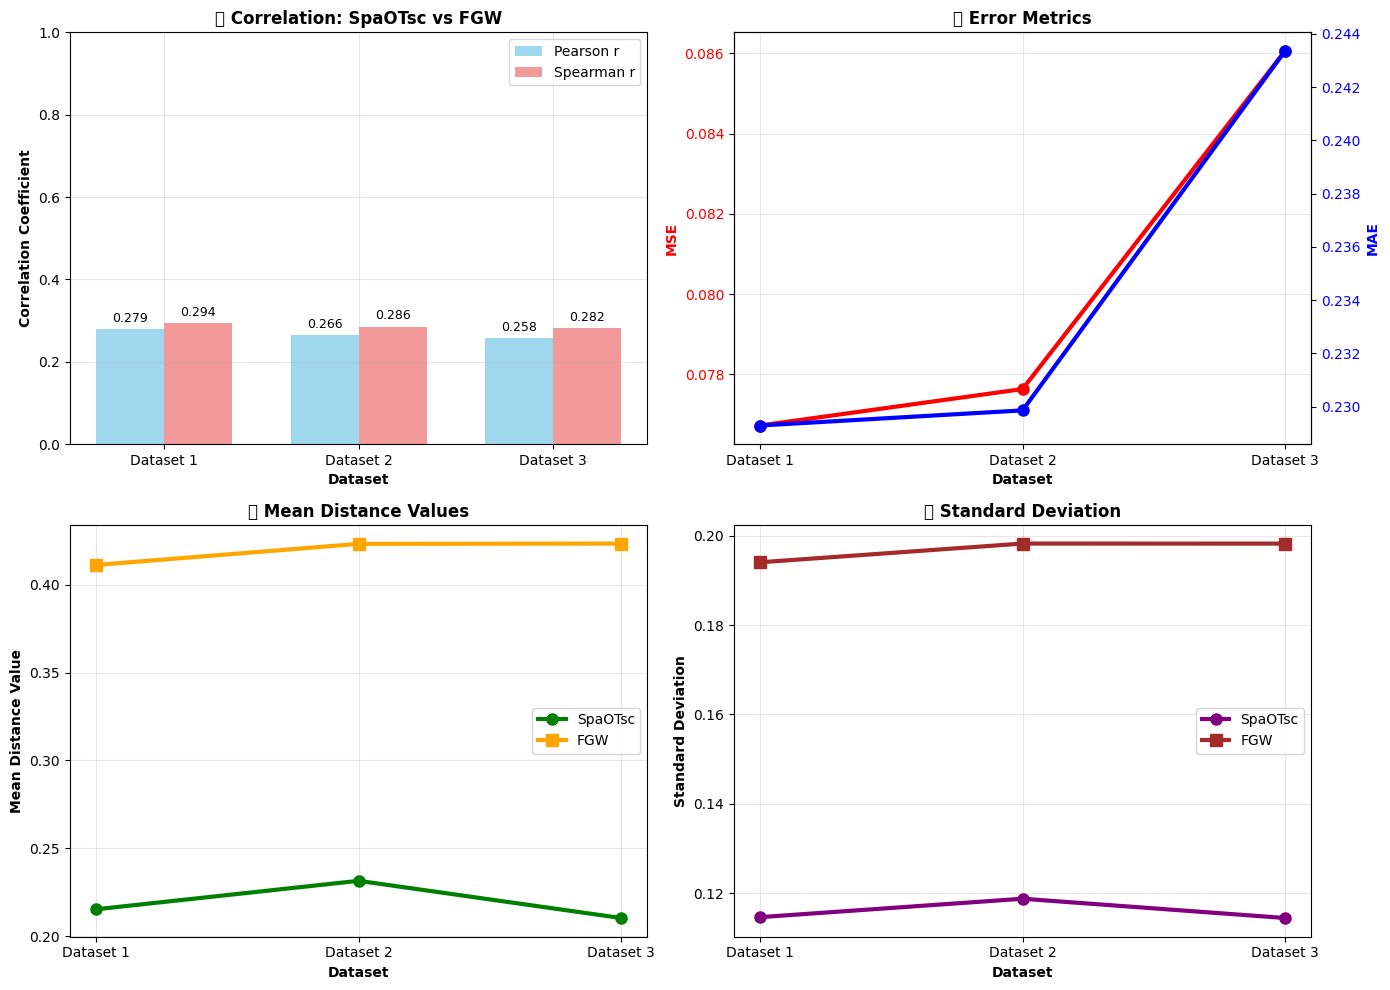


🔧 MATRIX PROPERTIES CHECK

Dataset 1:
--------------------
SpaOTsc: Symmetric=False, Diag=0=False
FGW:     Symmetric=True, Diag=0=False
SpaOTsc range: [0.0000, 1.0000]
FGW range:     [0.0000, 1.0000]

Dataset 2:
--------------------
SpaOTsc: Symmetric=False, Diag=0=False
FGW:     Symmetric=True, Diag=0=False
SpaOTsc range: [0.0000, 1.0000]
FGW range:     [0.0000, 1.0000]

Dataset 3:
--------------------
SpaOTsc: Symmetric=False, Diag=0=False
FGW:     Symmetric=True, Diag=0=False
SpaOTsc range: [0.0000, 1.0000]
FGW range:     [0.0000, 1.0000]


In [41]:
# Run this cell after you have both D_induced_spaotsc_all and D_induced_all available

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def compare_methods():
    """
    Compare SpaOTsc and FGW D_induced matrices across all 3 datasets
    """
    
    print("🔍 COMPARING SpaOTsc vs FGW D_induced MATRICES")
    print("=" * 60)
    
    # Verify we have the right variables
    try:
        print(f"✓ D_induced_spaotsc_all: {len(D_induced_spaotsc_all)} matrices")
        print(f"✓ D_induced_all: {len(D_induced_all)} matrices")
    except NameError:
        print("❌ Missing variables! Make sure you have run the cells that create:")
        print("   - D_induced_spaotsc_all")  
        print("   - D_induced_all")
        return
    
    # Create comprehensive comparison plot
    fig = plt.figure(figsize=(18, 12))
    
    stats_summary = []
    
    for i in range(3):
        print(f"\n📊 DATASET {i+1} ANALYSIS")
        print("-" * 40)
        
        # Get matrices
        D_spaotsc = D_induced_spaotsc_all[i]
        D_fgw = D_induced_all[i]
        
        print(f"SpaOTsc shape: {D_spaotsc.shape}")
        print(f"FGW shape:     {D_fgw.shape}")
        
        # Ensure same size for comparison
        min_size = min(D_spaotsc.shape[0], D_fgw.shape[0])
        D_spaotsc = D_spaotsc[:min_size, :min_size]
        D_fgw = D_fgw[:min_size, :min_size]
        
        # Get upper triangular values (excluding diagonal)
        triu_idx = np.triu_indices(min_size, k=1)
        vals_spaotsc = D_spaotsc[triu_idx]
        vals_fgw = D_fgw[triu_idx]
        
        # Calculate statistics
        r_pearson, p_pearson = pearsonr(vals_spaotsc, vals_fgw)
        r_spearman, p_spearman = spearmanr(vals_spaotsc, vals_fgw)
        mse = mean_squared_error(vals_spaotsc, vals_fgw)
        mae = mean_absolute_error(vals_spaotsc, vals_fgw)
        
        print(f"Pearson r:  {r_pearson:.4f} (p={p_pearson:.2e})")
        print(f"Spearman r: {r_spearman:.4f} (p={p_spearman:.2e})")
        print(f"MSE:        {mse:.6f}")
        print(f"MAE:        {mae:.6f}")
        
        # Store stats
        stats_summary.append({
            'Dataset': f'Dataset {i+1}',
            'Pearson_r': r_pearson,
            'Spearman_r': r_spearman,
            'MSE': mse,
            'MAE': mae,
            'SpaOTsc_mean': np.mean(vals_spaotsc),
            'FGW_mean': np.mean(vals_fgw),
            'SpaOTsc_std': np.std(vals_spaotsc),
            'FGW_std': np.std(vals_fgw)
        })
        
        # Create visualizations for this dataset
        
        # Row 1: Heatmaps
        # SpaOTsc heatmap
        ax1 = plt.subplot(3, 4, i*4 + 1)
        im1 = plt.imshow(D_spaotsc, cmap='viridis', aspect='auto')
        plt.title(f'Dataset {i+1}: SpaOTsc', fontsize=11, fontweight='bold')
        plt.colorbar(im1, shrink=0.7)
        if i == 2:
            plt.xlabel('Cell index')
        plt.ylabel('Cell index')
        
        # FGW heatmap  
        ax2 = plt.subplot(3, 4, i*4 + 2)
        im2 = plt.imshow(D_fgw, cmap='viridis', aspect='auto')
        plt.title(f'Dataset {i+1}: FGW', fontsize=11, fontweight='bold')
        plt.colorbar(im2, shrink=0.7)
        if i == 2:
            plt.xlabel('Cell index')
        
        # Difference heatmap
        ax3 = plt.subplot(3, 4, i*4 + 3)
        diff = D_spaotsc - D_fgw
        im3 = plt.imshow(diff, cmap='RdBu_r', aspect='auto')
        plt.title(f'Dataset {i+1}: Difference', fontsize=11, fontweight='bold')
        plt.colorbar(im3, shrink=0.7)
        if i == 2:
            plt.xlabel('Cell index')
        
        # Scatter plot
        ax4 = plt.subplot(3, 4, i*4 + 4)
        
        # Subsample if too many points for clearer visualization
        if len(vals_spaotsc) > 5000:
            idx = np.random.choice(len(vals_spaotsc), 5000, replace=False)
            x_plot, y_plot = vals_spaotsc[idx], vals_fgw[idx]
        else:
            x_plot, y_plot = vals_spaotsc, vals_fgw
            
        plt.scatter(x_plot, y_plot, alpha=0.6, s=2, c='steelblue')
        
        # Add diagonal line
        min_val, max_val = min(x_plot.min(), y_plot.min()), max(x_plot.max(), y_plot.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
        
        plt.xlabel('SpaOTsc values')
        plt.ylabel('FGW values')
        plt.title(f'Dataset {i+1}: Correlation\nr = {r_pearson:.3f}', 
                 fontsize=11, fontweight='bold')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('d_induced_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create summary statistics table and plots
    stats_df = pd.DataFrame(stats_summary)
    
    print(f"\n📈 SUMMARY STATISTICS")
    print("=" * 60)
    print(stats_df.round(4).to_string(index=False))
    
    # Summary plots
    create_summary_plots(stats_df)
    
    return stats_df

def create_summary_plots(stats_df):
    """Create summary visualization plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Correlation comparison
    ax1 = axes[0, 0]
    x_pos = np.arange(len(stats_df))
    width = 0.35
    
    bars1 = ax1.bar(x_pos - width/2, stats_df['Pearson_r'], width, 
                   label='Pearson r', alpha=0.8, color='skyblue')
    bars2 = ax1.bar(x_pos + width/2, stats_df['Spearman_r'], width, 
                   label='Spearman r', alpha=0.8, color='lightcoral')
    
    ax1.set_xlabel('Dataset', fontweight='bold')
    ax1.set_ylabel('Correlation Coefficient', fontweight='bold')
    ax1.set_title('📊 Correlation: SpaOTsc vs FGW', fontweight='bold', fontsize=12)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(stats_df['Dataset'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Error metrics
    ax2 = axes[0, 1]
    ax2_twin = ax2.twinx()
    
    line1 = ax2.plot(stats_df['Dataset'], stats_df['MSE'], 'ro-', 
                    linewidth=3, markersize=8, label='MSE')
    line2 = ax2_twin.plot(stats_df['Dataset'], stats_df['MAE'], 'bo-', 
                         linewidth=3, markersize=8, label='MAE')
    
    ax2.set_xlabel('Dataset', fontweight='bold')
    ax2.set_ylabel('MSE', color='red', fontweight='bold')
    ax2_twin.set_ylabel('MAE', color='blue', fontweight='bold')
    ax2.set_title('📉 Error Metrics', fontweight='bold', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2_twin.tick_params(axis='y', labelcolor='blue')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Mean values comparison
    ax3 = axes[1, 0]
    ax3.plot(stats_df['Dataset'], stats_df['SpaOTsc_mean'], 'o-', 
            linewidth=3, markersize=8, label='SpaOTsc', color='green')
    ax3.plot(stats_df['Dataset'], stats_df['FGW_mean'], 's-', 
            linewidth=3, markersize=8, label='FGW', color='orange')
    
    ax3.set_xlabel('Dataset', fontweight='bold')
    ax3.set_ylabel('Mean Distance Value', fontweight='bold')
    ax3.set_title('📊 Mean Distance Values', fontweight='bold', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Standard deviation comparison
    ax4 = axes[1, 1]
    ax4.plot(stats_df['Dataset'], stats_df['SpaOTsc_std'], 'o-', 
            linewidth=3, markersize=8, label='SpaOTsc', color='purple')
    ax4.plot(stats_df['Dataset'], stats_df['FGW_std'], 's-', 
            linewidth=3, markersize=8, label='FGW', color='brown')
    
    ax4.set_xlabel('Dataset', fontweight='bold')
    ax4.set_ylabel('Standard Deviation', fontweight='bold')
    ax4.set_title('📊 Standard Deviation', fontweight='bold', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('d_induced_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

def quick_matrix_check():
    """Quick check of matrix properties"""
    
    print("\n🔧 MATRIX PROPERTIES CHECK")
    print("=" * 50)
    
    for i in range(3):
        print(f"\nDataset {i+1}:")
        print("-" * 20)
        
        D_spa = D_induced_spaotsc_all[i]
        D_fgw = D_induced_all[i]
        
        # Check basic properties
        spa_symmetric = np.allclose(D_spa, D_spa.T, rtol=1e-5)
        fgw_symmetric = np.allclose(D_fgw, D_fgw.T, rtol=1e-5)
        
        spa_diag_zero = np.allclose(np.diag(D_spa), 0, atol=1e-5)
        fgw_diag_zero = np.allclose(np.diag(D_fgw), 0, atol=1e-5)
        
        print(f"SpaOTsc: Symmetric={spa_symmetric}, Diag=0={spa_diag_zero}")
        print(f"FGW:     Symmetric={fgw_symmetric}, Diag=0={fgw_diag_zero}")
        print(f"SpaOTsc range: [{D_spa.min():.4f}, {D_spa.max():.4f}]")
        print(f"FGW range:     [{D_fgw.min():.4f}, {D_fgw.max():.4f}]")

# 🚀 MAIN EXECUTION
print("🎯 D_INDUCED COMPARISON TOOL")
print("=" * 50)
print("This will compare SpaOTsc vs FGW D_induced matrices")
print("across your 3 datasets with comprehensive visualizations.")
print("\n📋 Usage:")
print("1. stats_df = compare_methods()")
print("2. quick_matrix_check()")
print("\n" + "="*50)

# Uncomment these lines to run automatically:
stats_df = compare_methods()
quick_matrix_check()

🧪 RUNNING SIMPLE TESTS...
This will help you decide which D_induced is better!

🧪 TESTING: Which D_induced is better?

📊 DATASET 1
------------------------------
SpaOTsc shape: (2688, 2688)
FGW shape: (2688, 2688)

✅ Test 1: Distance Range & Scale
SpaOTsc: [0.000, 1.000], mean=0.215, std=0.115
FGW:     [0.000, 1.000], mean=0.411, std=0.194
Diagonal = 0? SpaOTsc: False, FGW: False
Symmetric? SpaOTsc: False, FGW: True

✅ Test 2: Local Neighborhood Structure
Neighbor overlap: 0.006 (higher = more consistent)

✅ Test 3: Visual Comparison


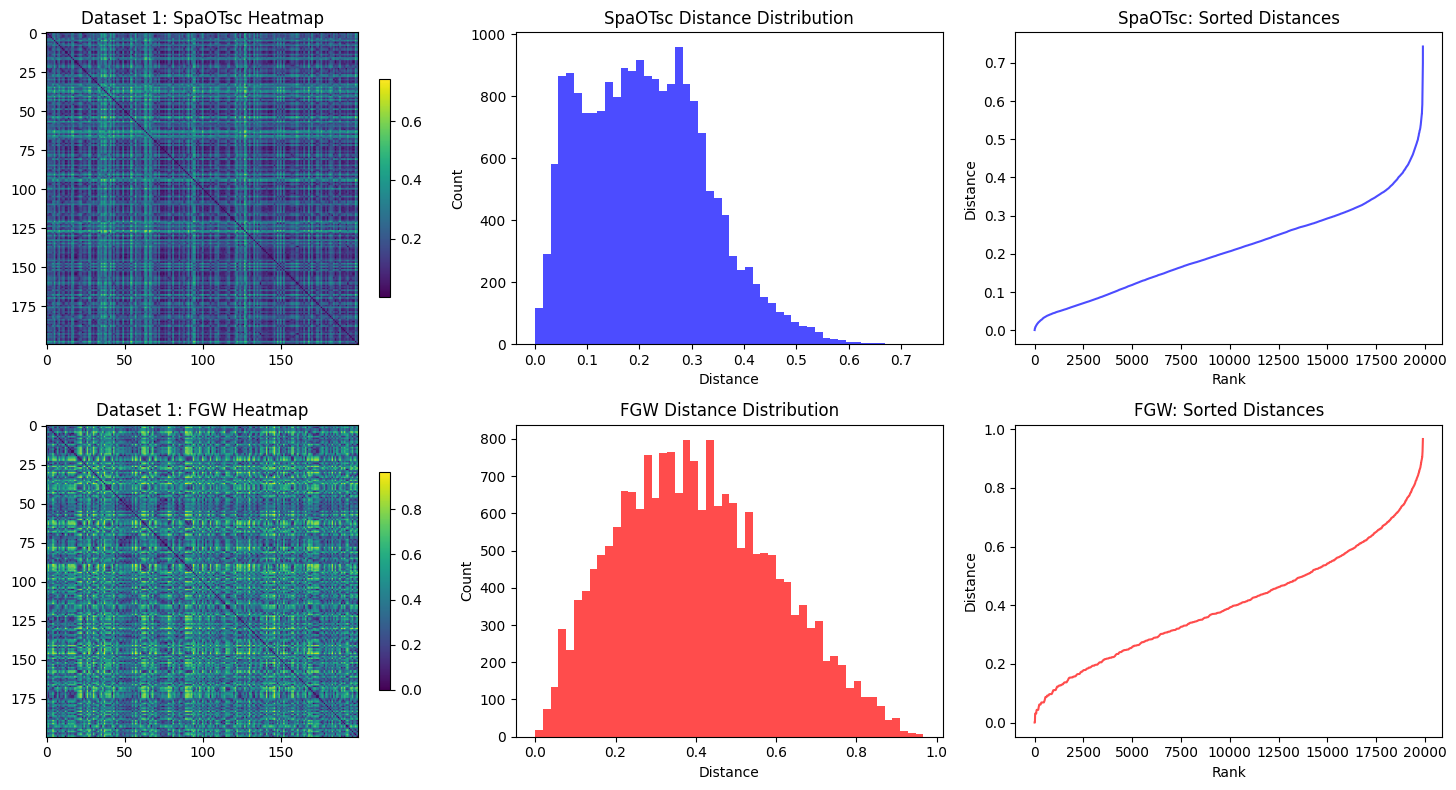

Correlation between methods: 0.306

📊 DATASET 2
------------------------------
SpaOTsc shape: (2688, 2688)
FGW shape: (2688, 2688)

✅ Test 1: Distance Range & Scale
SpaOTsc: [0.000, 1.000], mean=0.231, std=0.119
FGW:     [0.000, 1.000], mean=0.423, std=0.198
Diagonal = 0? SpaOTsc: False, FGW: False
Symmetric? SpaOTsc: False, FGW: True

✅ Test 2: Local Neighborhood Structure
Neighbor overlap: 0.024 (higher = more consistent)

✅ Test 3: Visual Comparison


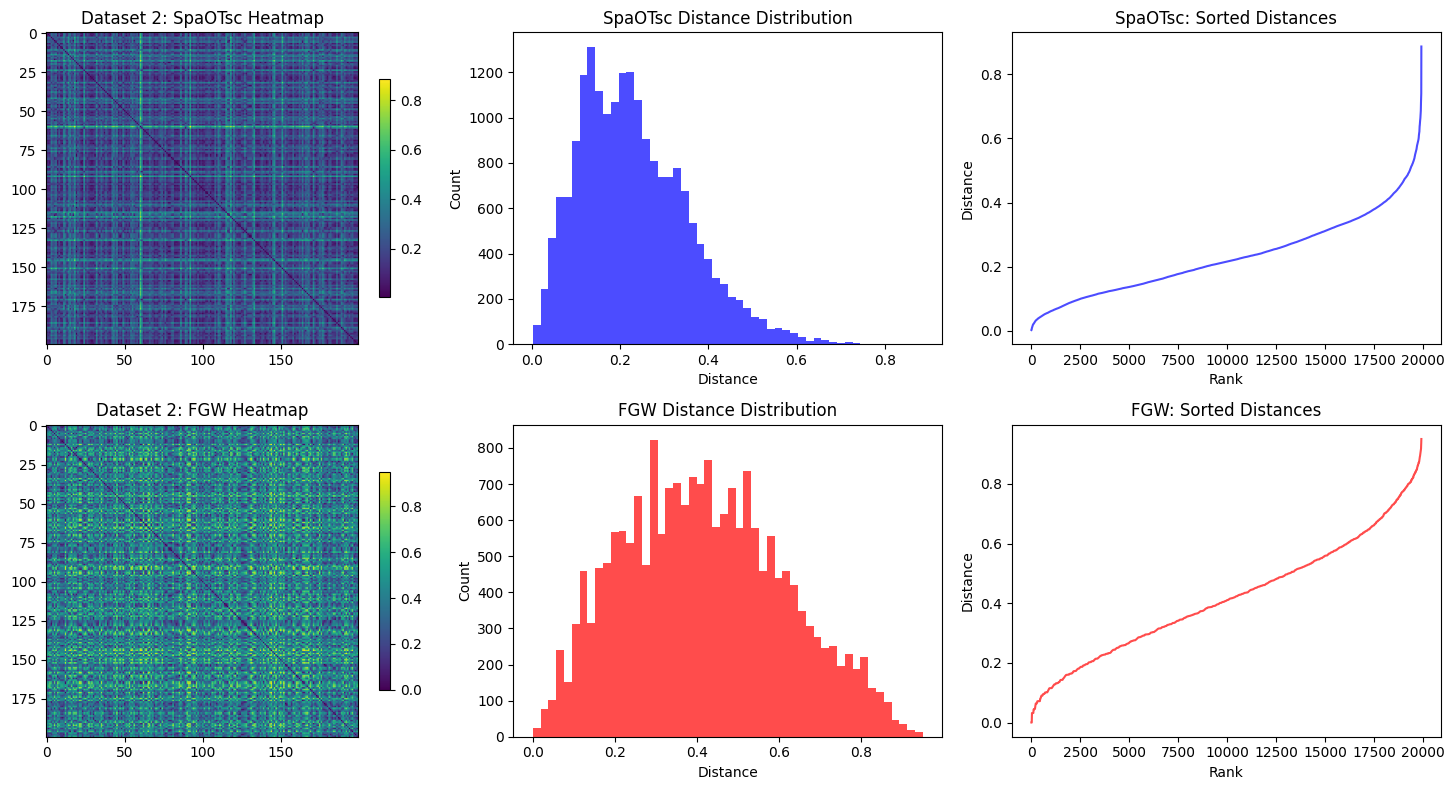

Correlation between methods: 0.238

📊 DATASET 3
------------------------------
SpaOTsc shape: (2688, 2688)
FGW shape: (2688, 2688)

✅ Test 1: Distance Range & Scale
SpaOTsc: [0.000, 1.000], mean=0.210, std=0.114
FGW:     [0.000, 1.000], mean=0.423, std=0.198
Diagonal = 0? SpaOTsc: False, FGW: False
Symmetric? SpaOTsc: False, FGW: True

✅ Test 2: Local Neighborhood Structure
Neighbor overlap: 0.014 (higher = more consistent)

✅ Test 3: Visual Comparison


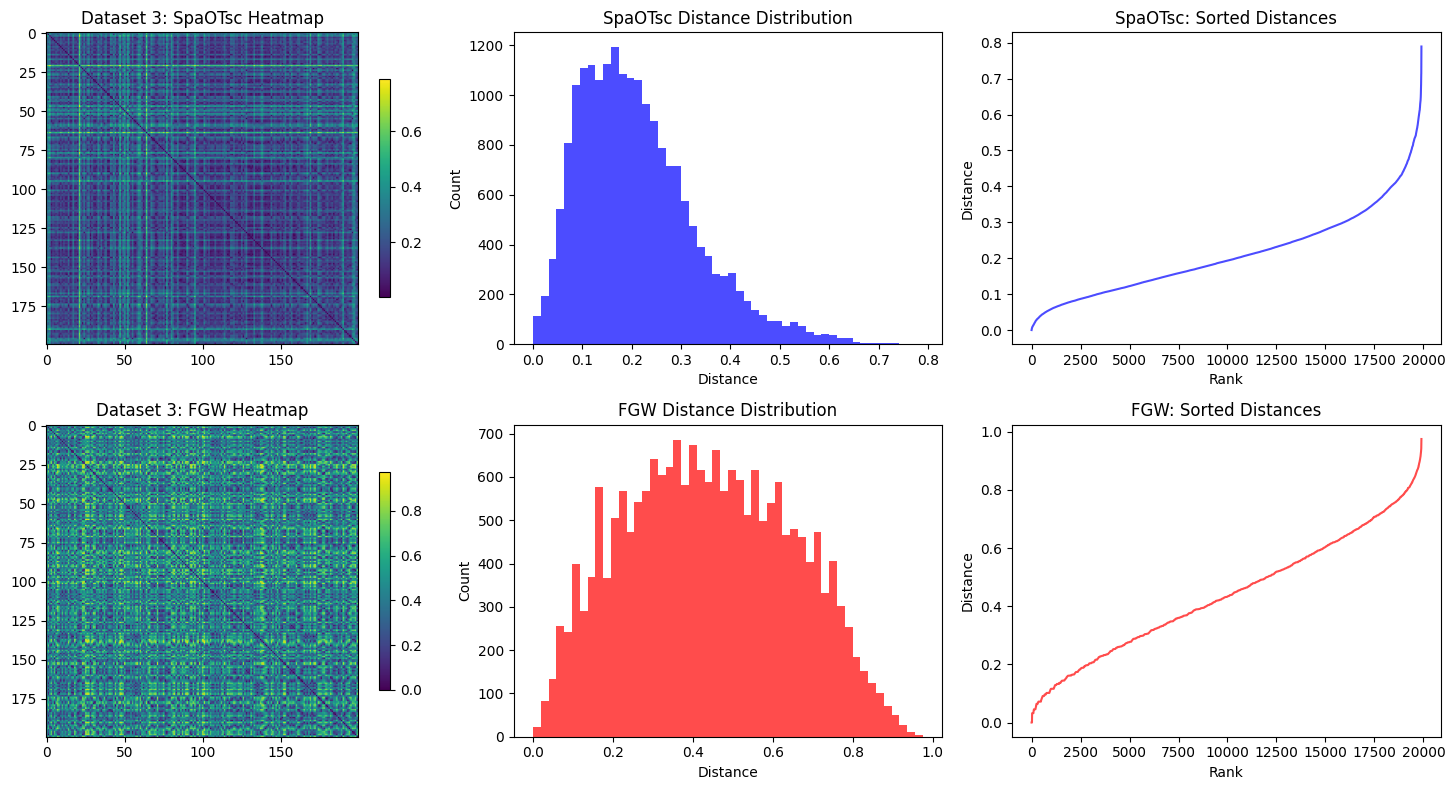

Correlation between methods: 0.211

🎯 SIMPLE RECOMMENDATION
Dataset 1: SpaOTsc=2/4, FGW=3/4
Dataset 2: SpaOTsc=2/4, FGW=3/4
Dataset 3: SpaOTsc=2/4, FGW=3/4

Total scores: SpaOTsc=6/12, FGW=9/12
🏆 Recommendation: Use FGW D_induced


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

def test_which_d_induced_is_better():
    """
    Simple test to see which D_induced method gives better spatial relationships
    """
    
    print("🧪 TESTING: Which D_induced is better?")
    print("="*50)
    
    # We'll test each dataset
    for i in range(3):
        print(f"\n📊 DATASET {i+1}")
        print("-"*30)
        
        # Get the matrices
        D_spaotsc = D_induced_spaotsc_all[i]
        D_fgw = D_induced_all[i]
        
        print(f"SpaOTsc shape: {D_spaotsc.shape}")
        print(f"FGW shape: {D_fgw.shape}")
        
        # Simple tests
        test_1_range_and_scale(D_spaotsc, D_fgw, i+1)
        test_2_local_structure(D_spaotsc, D_fgw, i+1)
        test_3_visual_comparison(D_spaotsc, D_fgw, i+1)

def test_1_range_and_scale(D_spa, D_fgw, dataset_num):
    """Test 1: Check if the distance ranges make sense"""
    
    print(f"\n✅ Test 1: Distance Range & Scale")
    
    # Basic stats
    spa_min, spa_max = D_spa.min(), D_spa.max()
    spa_mean, spa_std = D_spa.mean(), D_spa.std()
    
    fgw_min, fgw_max = D_fgw.min(), D_fgw.max()
    fgw_mean, fgw_std = D_fgw.mean(), D_fgw.std()
    
    print(f"SpaOTsc: [{spa_min:.3f}, {spa_max:.3f}], mean={spa_mean:.3f}, std={spa_std:.3f}")
    print(f"FGW:     [{fgw_min:.3f}, {fgw_max:.3f}], mean={fgw_mean:.3f}, std={fgw_std:.3f}")
    
    # Check if diagonal is zero (distance from cell to itself should be 0)
    spa_diag_ok = np.allclose(np.diag(D_spa), 0, atol=1e-5)
    fgw_diag_ok = np.allclose(np.diag(D_fgw), 0, atol=1e-5)
    
    print(f"Diagonal = 0? SpaOTsc: {spa_diag_ok}, FGW: {fgw_diag_ok}")
    
    # Check if symmetric (distance i->j should equal j->i)
    spa_sym_ok = np.allclose(D_spa, D_spa.T, rtol=1e-5)
    fgw_sym_ok = np.allclose(D_fgw, D_fgw.T, rtol=1e-5)
    
    print(f"Symmetric? SpaOTsc: {spa_sym_ok}, FGW: {fgw_sym_ok}")

def test_2_local_structure(D_spa, D_fgw, dataset_num):
    """Test 2: Check if local neighborhoods are preserved"""
    
    print(f"\n✅ Test 2: Local Neighborhood Structure")
    
    # For each cell, find its 5 nearest neighbors in both matrices
    n_neighbors = 5
    n_cells = min(D_spa.shape[0], 100)  # Test on first 100 cells for speed
    
    spa_consistency = []
    fgw_consistency = []
    
    for cell_i in range(n_cells):
        # Get nearest neighbors in both matrices
        spa_neighbors = np.argsort(D_spa[cell_i, :])[:n_neighbors+1][1:]  # +1 to exclude self
        fgw_neighbors = np.argsort(D_fgw[cell_i, :])[:n_neighbors+1][1:]
        
        # Check how many neighbors overlap
        overlap = len(set(spa_neighbors) & set(fgw_neighbors))
        spa_consistency.append(overlap / n_neighbors)
        
        # Check if distances to neighbors are well-ordered
        spa_dists = D_spa[cell_i, spa_neighbors]
        fgw_dists = D_fgw[cell_i, fgw_neighbors]
        
        # Good if distances increase monotonically
        spa_ordered = np.all(np.diff(spa_dists) >= 0)
        fgw_ordered = np.all(np.diff(fgw_dists) >= 0)
        
    avg_consistency = np.mean(spa_consistency)
    print(f"Neighbor overlap: {avg_consistency:.3f} (higher = more consistent)")

def test_3_visual_comparison(D_spa, D_fgw, dataset_num):
    """Test 3: Visual comparison"""
    
    print(f"\n✅ Test 3: Visual Comparison")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Subsample for visualization if matrix is large
    max_size = 200
    if D_spa.shape[0] > max_size:
        idx = np.random.choice(D_spa.shape[0], max_size, replace=False)
        D_spa_vis = D_spa[np.ix_(idx, idx)]
        D_fgw_vis = D_fgw[np.ix_(idx, idx)]
    else:
        D_spa_vis = D_spa
        D_fgw_vis = D_fgw
    
    # Row 1: SpaOTsc
    # Heatmap
    im1 = axes[0, 0].imshow(D_spa_vis, cmap='viridis')
    axes[0, 0].set_title(f'Dataset {dataset_num}: SpaOTsc Heatmap')
    plt.colorbar(im1, ax=axes[0, 0], shrink=0.7)
    
    # Distance histogram
    axes[0, 1].hist(D_spa_vis[np.triu_indices(D_spa_vis.shape[0], k=1)], 
                   bins=50, alpha=0.7, color='blue')
    axes[0, 1].set_title(f'SpaOTsc Distance Distribution')
    axes[0, 1].set_xlabel('Distance')
    axes[0, 1].set_ylabel('Count')
    
    # Distance vs rank
    spa_flat = D_spa_vis[np.triu_indices(D_spa_vis.shape[0], k=1)]
    spa_sorted = np.sort(spa_flat)
    axes[0, 2].plot(spa_sorted, 'b-', alpha=0.7)
    axes[0, 2].set_title(f'SpaOTsc: Sorted Distances')
    axes[0, 2].set_xlabel('Rank')
    axes[0, 2].set_ylabel('Distance')
    
    # Row 2: FGW
    # Heatmap
    im2 = axes[1, 0].imshow(D_fgw_vis, cmap='viridis')
    axes[1, 0].set_title(f'Dataset {dataset_num}: FGW Heatmap')
    plt.colorbar(im2, ax=axes[1, 0], shrink=0.7)
    
    # Distance histogram
    axes[1, 1].hist(D_fgw_vis[np.triu_indices(D_fgw_vis.shape[0], k=1)], 
                   bins=50, alpha=0.7, color='red')
    axes[1, 1].set_title(f'FGW Distance Distribution')
    axes[1, 1].set_xlabel('Distance')
    axes[1, 1].set_ylabel('Count')
    
    # Distance vs rank
    fgw_flat = D_fgw_vis[np.triu_indices(D_fgw_vis.shape[0], k=1)]
    fgw_sorted = np.sort(fgw_flat)
    axes[1, 2].plot(fgw_sorted, 'r-', alpha=0.7)
    axes[1, 2].set_title(f'FGW: Sorted Distances')
    axes[1, 2].set_xlabel('Rank')
    axes[1, 2].set_ylabel('Distance')
    
    plt.tight_layout()
    plt.show()
    
    # Quick correlation check
    spa_vals = spa_flat
    fgw_vals = fgw_flat
    
    if len(spa_vals) == len(fgw_vals):
        corr, _ = pearsonr(spa_vals, fgw_vals)
        print(f"Correlation between methods: {corr:.3f}")

def simple_recommendation():
    """Give a simple recommendation based on basic checks"""
    
    print(f"\n🎯 SIMPLE RECOMMENDATION")
    print("="*50)
    
    scores_spa = []
    scores_fgw = []
    
    for i in range(3):
        D_spa = D_induced_spaotsc_all[i]
        D_fgw = D_induced_all[i]
        
        # Score based on simple criteria
        spa_score = 0
        fgw_score = 0
        
        # 1. Has proper diagonal (should be 0)
        if np.allclose(np.diag(D_spa), 0, atol=1e-5):
            spa_score += 1
        if np.allclose(np.diag(D_fgw), 0, atol=1e-5):
            fgw_score += 1
            
        # 2. Is symmetric
        if np.allclose(D_spa, D_spa.T, rtol=1e-5):
            spa_score += 1
        if np.allclose(D_fgw, D_fgw.T, rtol=1e-5):
            fgw_score += 1
            
        # 3. Has reasonable range (not all zeros, not too extreme)
        spa_range = D_spa.max() - D_spa.min()
        fgw_range = D_fgw.max() - D_fgw.min()
        
        if 0.1 < spa_range < 10:  # reasonable range
            spa_score += 1
        if 0.1 < fgw_range < 10:
            fgw_score += 1
            
        # 4. Not too sparse (has enough variation)
        spa_nonzero = np.sum(D_spa > 1e-6) / D_spa.size
        fgw_nonzero = np.sum(D_fgw > 1e-6) / D_fgw.size
        
        if spa_nonzero > 0.5:  # at least 50% non-zero
            spa_score += 1
        if fgw_nonzero > 0.5:
            fgw_score += 1
        
        scores_spa.append(spa_score)
        scores_fgw.append(fgw_score)
        
        print(f"Dataset {i+1}: SpaOTsc={spa_score}/4, FGW={fgw_score}/4")
    
    total_spa = sum(scores_spa)
    total_fgw = sum(scores_fgw)
    
    print(f"\nTotal scores: SpaOTsc={total_spa}/12, FGW={total_fgw}/12")
    
    if total_spa > total_fgw:
        print("🏆 Recommendation: Use SpaOTsc D_induced")
    elif total_fgw > total_spa:
        print("🏆 Recommendation: Use FGW D_induced")
    else:
        print("🤔 Recommendation: Both methods seem similar")
        
    return total_spa, total_fgw

# 🚀 RUN THE TESTS
print("🧪 RUNNING SIMPLE TESTS...")
print("This will help you decide which D_induced is better!")
print()

# Uncomment to run:
test_which_d_induced_is_better()
spa_score, fgw_score = simple_recommendation()

In [31]:
# For scikit-learn ≥1.2, the SMACOF core lives in sklearn.manifold._mds
from sklearn.manifold._mds import smacof_single


ImportError: cannot import name 'smacof_single' from 'sklearn.manifold._mds' (/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/sklearn/manifold/_mds.py)

In [32]:
from sklearn.manifold.smacof import smacof_single


ModuleNotFoundError: No module named 'sklearn.manifold.smacof'

In [33]:
from sklearn.manifold import smacof
